Step 1:Fetching World Bank data SSA

In [ ]:
import requests
import pandas as pd
from time import sleep
from tqdm import tqdm
import os

# 1. World Bank SSA Countries (48)
SSA_COUNTRIES = {
    "AGO": "Angola", "BEN": "Benin", "BWA": "Botswana", "BFA": "Burkina Faso",
    "BDI": "Burundi", "CPV": "Cabo Verde", "CMR": "Cameroon", "CAF": "Central African Republic",
    "TCD": "Chad", "COM": "Comoros", "COG": "Congo, Rep.", "CIV": "Côte d'Ivoire",
    "COD": "Congo, Dem. Rep.", "DJI": "Djibouti", "GNQ": "Equatorial Guinea", "ERI": "Eritrea",
    "SWZ": "Eswatini", "ETH": "Ethiopia", "GAB": "Gabon", "GMB": "Gambia, The",
    "GHA": "Ghana", "GIN": "Guinea", "GNB": "Guinea-Bissau", "KEN": "Kenya",
    "LSO": "Lesotho", "LBR": "Liberia", "MDG": "Madagascar", "MWI": "Malawi",
    "MLI": "Mali", "MRT": "Mauritania", "MUS": "Mauritius", "MOZ": "Mozambique",
    "NAM": "Namibia", "NER": "Niger", "NGA": "Nigeria", "RWA": "Rwanda",
    "STP": "Sao Tome and Principe", "SEN": "Senegal", "SYC": "Seychelles", "SLE": "Sierra Leone",
    "SOM": "Somalia", "ZAF": "South Africa", "SSD": "South Sudan", "TZA": "Tanzania",
    "TGO": "Togo", "UGA": "Uganda", "ZMB": "Zambia", "ZWE": "Zimbabwe"
}

# 2. Indicator Groups 
INDICATOR_GROUPS = {
    "Health_Outcomes": {
        "SP.DYN.LE00.IN": "Life_Expectancy",
        "SH.DYN.MORT": "Under5_Mortality",
        "SH.STA.MMRT": "Maternal_Mortality",
        "SH.DYN.AIDS.ZS": "HIV_Prevalence",
    },
    "Health_System_Indicators": {
        "SH.XPD.CHEX.PC.CD": "Health_Expenditure_per_Capita",
        "SH.IMM.MEAS.ZS": "Measles_Immunization_Rate",
        "SH.STA.ANVC.ZS": "Antenatal_Care_Coverage",
        "SH.STA.BRTC.ZS": "Births_Attended_by_Skilled_Staff",
    },
    "Demographic_Indicators": {
        "SP.POP.GROW": "Population_Growth_Rate",
        "SP.POP.TOTL": "Total_Population",
        "SP.DYN.CBRT.IN": "Birth_Rate",
    },
    "Socioeconomic_Indicators": {
        "NY.GDP.PCAP.CD": "GDP_per_Capita",
        "SP.URB.TOTL.IN.ZS": "Urban_Population_Percentage",
        "SE.ADT.LITR.ZS": "Adult_Literacy_Rate",
    }
}

# 3. Function to fetch indicator data
def fetch_indicator_data(country_code, indicator_code, indicator_name):
    """Fetches data for one country + indicator from World Bank API"""
    url = f"http://api.worldbank.org/v2/country/{country_code}/indicator/{indicator_code}?format=json&per_page=2000&date=1980:2023"
    for attempt in range(3):  
        try:
            r = requests.get(url)
            if r.status_code == 200:
                data = r.json()[1]
                df = pd.DataFrame([
                    {
                        "Country": d["country"]["value"],
                        "Country_Code": country_code,
                        "Year": int(d["date"]),
                        indicator_name: d["value"]
                    }
                    for d in data if d["value"] is not None
                ])
                return df
            else:
                print(f" {country_code} | {indicator_name} returned status {r.status_code}")
        except Exception as e:
            print(f" Attempt {attempt+1} failed for {country_code} | {indicator_name}: {e}")
            sleep(2)
    return pd.DataFrame()

# 4. Main Fetch Function
def fetch_all_data():
    all_dfs = []
    print(" Fetching World Bank data for Sub-Saharan Africa (1980–2023)...\n")
    sleep(1)

    total_tasks = len(SSA_COUNTRIES) * sum(len(v) for v in INDICATOR_GROUPS.values())

    with tqdm(total=total_tasks, desc="Fetching data", ncols=100) as pbar:
        for country_code, country_name in SSA_COUNTRIES.items():
            country_frames = []
            for group_name, indicators in INDICATOR_GROUPS.items():
                for ind_code, ind_name in indicators.items():
                    df = fetch_indicator_data(country_code, ind_code, ind_name)
                    if not df.empty:
                        country_frames.append(df)
                    pbar.update(1)
                    sleep(0.2)  # Prevent API overload
            if country_frames:
                merged_country = country_frames[0]
                for sub_df in country_frames[1:]:
                    merged_country = pd.merge(merged_country, sub_df, on=["Country", "Country_Code", "Year"], how="outer")
                all_dfs.append(merged_country)

    full_df = pd.concat(all_dfs, ignore_index=True)
    print("\n Data fetching complete!")
    print(f" Total rows collected: {len(full_df):,}")
    return full_df


if __name__ == "__main__":
    df = fetch_all_data()

    # Clean and sort
    df.drop_duplicates(inplace=True)
    df.sort_values(["Country", "Year"], inplace=True)

    # Save dataset
    os.makedirs("data", exist_ok=True)
    output_path = "data/ssa_health_data_1980_2023.csv"
    df.to_csv(output_path, index=False)
    print(f"\n Saved dataset to: {output_path}")
    print(f" Shape: {df.shape}")

 Fetching World Bank data for Sub-Saharan Africa (1980–2023)...



Fetching data:   0%|                                                        | 0/672 [00:00<?, ?it/s]

 AGO | Life_Expectancy returned status 429
 AGO | Life_Expectancy returned status 429


Fetching data:   0%|                                                | 1/672 [00:03<38:57,  3.48s/it]

 AGO | Life_Expectancy returned status 429
 AGO | Under5_Mortality returned status 429
 AGO | Under5_Mortality returned status 429


Fetching data:   0%|▏                                               | 2/672 [00:07<45:12,  4.05s/it]

 AGO | Under5_Mortality returned status 429
 AGO | Maternal_Mortality returned status 429
 AGO | Maternal_Mortality returned status 429


Fetching data:   0%|▏                                               | 3/672 [00:12<47:23,  4.25s/it]

 AGO | Maternal_Mortality returned status 429


Fetching data:   1%|▎                                               | 4/672 [00:13<33:40,  3.02s/it]

 AGO | Health_Expenditure_per_Capita returned status 429
 AGO | Health_Expenditure_per_Capita returned status 429


Fetching data:   1%|▎                                               | 5/672 [00:17<38:46,  3.49s/it]

 AGO | Health_Expenditure_per_Capita returned status 429
 AGO | Measles_Immunization_Rate returned status 429
 Attempt 2 failed for AGO | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for AGO | Measles_Immunization_Rate: list index out of range


Fetching data:   1%|▋                                               | 9/672 [00:30<27:01,  2.45s/it]

 AGO | Total_Population returned status 429
 AGO | Total_Population returned status 429


Fetching data:   1%|▋                                              | 10/672 [00:34<35:01,  3.17s/it]

 AGO | Total_Population returned status 429


Fetching data:   2%|▊                                              | 11/672 [00:35<28:10,  2.56s/it]

 AGO | GDP_per_Capita returned status 429
 AGO | GDP_per_Capita returned status 429


Fetching data:   2%|▊                                              | 12/672 [00:39<31:16,  2.84s/it]

 AGO | GDP_per_Capita returned status 429
 AGO | Urban_Population_Percentage returned status 429
 AGO | Urban_Population_Percentage returned status 429


Fetching data:   2%|▉                                              | 13/672 [00:43<36:01,  3.28s/it]

 AGO | Urban_Population_Percentage returned status 429
 AGO | Adult_Literacy_Rate returned status 429
 AGO | Adult_Literacy_Rate returned status 429


Fetching data:   2%|▉                                              | 14/672 [00:47<35:57,  3.28s/it]

 AGO | Adult_Literacy_Rate returned status 429


Fetching data:   3%|█▏                                             | 17/672 [00:51<24:03,  2.20s/it]

 BEN | HIV_Prevalence returned status 429
 BEN | HIV_Prevalence returned status 429


Fetching data:   3%|█▎                                             | 18/672 [00:55<28:47,  2.64s/it]

 BEN | HIV_Prevalence returned status 429


Fetching data:   3%|█▎                                             | 19/672 [00:56<24:01,  2.21s/it]

 BEN | Measles_Immunization_Rate returned status 429
 BEN | Measles_Immunization_Rate returned status 429


Fetching data:   3%|█▍                                             | 20/672 [00:59<27:35,  2.54s/it]

 BEN | Measles_Immunization_Rate returned status 429
 BEN | Antenatal_Care_Coverage returned status 429
 BEN | Antenatal_Care_Coverage returned status 429


Fetching data:   3%|█▍                                             | 21/672 [01:04<33:41,  3.11s/it]

 BEN | Antenatal_Care_Coverage returned status 429
 BEN | Births_Attended_by_Skilled_Staff returned status 429
 BEN | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:   3%|█▌                                             | 22/672 [01:09<38:55,  3.59s/it]

 BEN | Births_Attended_by_Skilled_Staff returned status 429
 BEN | Population_Growth_Rate returned status 429
 BEN | Population_Growth_Rate returned status 429


Fetching data:   3%|█▌                                             | 23/672 [01:12<38:58,  3.60s/it]

 BEN | Population_Growth_Rate returned status 429
 BEN | Total_Population returned status 429
 BEN | Total_Population returned status 429


Fetching data:   4%|█▋                                             | 24/672 [01:15<37:47,  3.50s/it]

 BEN | Total_Population returned status 429
 BEN | Birth_Rate returned status 429
 BEN | Birth_Rate returned status 429


Fetching data:   4%|█▋                                             | 25/672 [01:20<40:23,  3.75s/it]

 BEN | Birth_Rate returned status 429


Fetching data:   4%|█▊                                             | 26/672 [01:21<32:31,  3.02s/it]

 BEN | Urban_Population_Percentage returned status 429
 BEN | Urban_Population_Percentage returned status 429


Fetching data:   4%|█▉                                             | 27/672 [01:25<35:25,  3.30s/it]

 BEN | Urban_Population_Percentage returned status 429


Fetching data:   4%|█▉                                             | 28/672 [01:26<28:39,  2.67s/it]

 BWA | Life_Expectancy returned status 429
 BWA | Life_Expectancy returned status 429


Fetching data:   4%|██                                             | 29/672 [01:29<30:24,  2.84s/it]

 BWA | Life_Expectancy returned status 429
 BWA | Under5_Mortality returned status 429


Fetching data:   5%|██▎                                            | 33/672 [01:37<19:57,  1.87s/it]

 Attempt 1 failed for BWA | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for BWA | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for BWA | Measles_Immunization_Rate: list index out of range


Fetching data:   5%|██▍                                            | 34/672 [01:46<44:13,  4.16s/it]

 BWA | Antenatal_Care_Coverage returned status 429
 BWA | Antenatal_Care_Coverage returned status 429


Fetching data:   5%|██▍                                            | 35/672 [01:51<47:08,  4.44s/it]

 BWA | Antenatal_Care_Coverage returned status 429
 BWA | Births_Attended_by_Skilled_Staff returned status 429
 BWA | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:   5%|██▌                                            | 36/672 [01:55<45:02,  4.25s/it]

 BWA | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:   6%|██▌                                            | 37/672 [01:58<38:39,  3.65s/it]

 BWA | Total_Population returned status 429
 BWA | Total_Population returned status 429


Fetching data:   6%|██▋                                            | 38/672 [02:01<38:44,  3.67s/it]

 BWA | Total_Population returned status 429


Fetching data:   6%|██▋                                            | 39/672 [02:02<30:58,  2.94s/it]

 BWA | GDP_per_Capita returned status 429
 BWA | GDP_per_Capita returned status 429


Fetching data:   6%|██▊                                            | 40/672 [02:08<39:45,  3.77s/it]

 BWA | GDP_per_Capita returned status 429


Fetching data:   6%|██▊                                            | 41/672 [02:10<32:05,  3.05s/it]

 BWA | Adult_Literacy_Rate returned status 429
 BWA | Adult_Literacy_Rate returned status 429


Fetching data:   6%|██▉                                            | 42/672 [02:15<40:15,  3.83s/it]

 BWA | Adult_Literacy_Rate returned status 429


Fetching data:   6%|███                                            | 43/672 [02:17<33:18,  3.18s/it]

 BFA | Under5_Mortality returned status 429
 BFA | Under5_Mortality returned status 429


Fetching data:   7%|███                                            | 44/672 [02:21<36:18,  3.47s/it]

 BFA | Under5_Mortality returned status 429
 BFA | Maternal_Mortality returned status 429
 BFA | Maternal_Mortality returned status 429


Fetching data:   7%|███▏                                           | 45/672 [02:26<40:44,  3.90s/it]

 BFA | Maternal_Mortality returned status 429


Fetching data:   7%|███▏                                           | 46/672 [02:27<33:07,  3.18s/it]

 BFA | Health_Expenditure_per_Capita returned status 429
 BFA | Health_Expenditure_per_Capita returned status 429


Fetching data:   7%|███▎                                           | 47/672 [02:31<34:53,  3.35s/it]

 BFA | Health_Expenditure_per_Capita returned status 429
 BFA | Measles_Immunization_Rate returned status 429
 BFA | Measles_Immunization_Rate returned status 429


Fetching data:   7%|███▎                                           | 48/672 [02:35<35:53,  3.45s/it]

 BFA | Measles_Immunization_Rate returned status 429
 BFA | Antenatal_Care_Coverage returned status 429
 BFA | Antenatal_Care_Coverage returned status 429


Fetching data:   7%|███▍                                           | 49/672 [02:43<51:55,  5.00s/it]

 BFA | Births_Attended_by_Skilled_Staff returned status 429
 BFA | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:   7%|███▍                                           | 50/672 [02:47<46:56,  4.53s/it]

 BFA | Births_Attended_by_Skilled_Staff returned status 429
 BFA | Population_Growth_Rate returned status 429
 BFA | Population_Growth_Rate returned status 429


Fetching data:   8%|███▌                                           | 51/672 [02:50<43:02,  4.16s/it]

 BFA | Population_Growth_Rate returned status 429
 BFA | Total_Population returned status 429
 BFA | Total_Population returned status 429


Fetching data:   8%|███▋                                           | 52/672 [02:53<39:38,  3.84s/it]

 BFA | Total_Population returned status 429


Fetching data:   8%|███▉                                           | 56/672 [02:59<20:10,  1.96s/it]

 BDI | Life_Expectancy returned status 429
 BDI | Life_Expectancy returned status 429


Fetching data:   8%|███▉                                           | 57/672 [03:04<29:44,  2.90s/it]

 BDI | Life_Expectancy returned status 429
 BDI | Under5_Mortality returned status 429
 BDI | Under5_Mortality returned status 429


Fetching data:   9%|████                                           | 58/672 [03:08<33:53,  3.31s/it]

 BDI | Under5_Mortality returned status 429
 BDI | Maternal_Mortality returned status 429
 BDI | Maternal_Mortality returned status 429


Fetching data:   9%|████▏                                          | 59/672 [03:12<34:18,  3.36s/it]

 BDI | Maternal_Mortality returned status 429


Fetching data:   9%|████▎                                          | 61/672 [03:14<22:44,  2.23s/it]

 Attempt 1 failed for BDI | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for BDI | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for BDI | Measles_Immunization_Rate: list index out of range


Fetching data:  10%|████▌                                          | 65/672 [03:29<26:44,  2.64s/it]

 BDI | Total_Population returned status 429
 BDI | Total_Population returned status 429


Fetching data:  10%|████▌                                          | 66/672 [03:32<28:58,  2.87s/it]

 BDI | Total_Population returned status 429
 BDI | Birth_Rate returned status 429
 BDI | Birth_Rate returned status 429


Fetching data:  10%|████▋                                          | 67/672 [03:36<30:49,  3.06s/it]

 BDI | Birth_Rate returned status 429
 BDI | GDP_per_Capita returned status 429
 BDI | GDP_per_Capita returned status 429


Fetching data:  10%|████▊                                          | 68/672 [03:42<38:56,  3.87s/it]

 BDI | GDP_per_Capita returned status 429


Fetching data:  11%|█████                                          | 72/672 [03:47<19:49,  1.98s/it]

 CPV | Maternal_Mortality returned status 429
 CPV | Maternal_Mortality returned status 429


Fetching data:  11%|█████                                          | 73/672 [03:53<30:27,  3.05s/it]

 CPV | Maternal_Mortality returned status 429
 CPV | HIV_Prevalence returned status 429
 CPV | HIV_Prevalence returned status 429


Fetching data:  11%|█████▏                                         | 74/672 [03:56<31:29,  3.16s/it]

 CPV | HIV_Prevalence returned status 429
 CPV | Health_Expenditure_per_Capita returned status 429
 CPV | Health_Expenditure_per_Capita returned status 429


Fetching data:  11%|█████▏                                         | 75/672 [04:02<39:51,  4.01s/it]

 CPV | Health_Expenditure_per_Capita returned status 429
 Attempt 1 failed for CPV | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for CPV | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for CPV | Measles_Immunization_Rate: list index out of range


Fetching data:  12%|█████▍                                         | 78/672 [04:15<35:50,  3.62s/it]

 CPV | Population_Growth_Rate returned status 429
 CPV | Population_Growth_Rate returned status 429


Fetching data:  12%|█████▌                                         | 79/672 [04:19<35:03,  3.55s/it]

 CPV | Population_Growth_Rate returned status 429


Fetching data:  12%|█████▋                                         | 81/672 [04:21<22:56,  2.33s/it]

 CPV | GDP_per_Capita returned status 429
 CPV | GDP_per_Capita returned status 429


Fetching data:  12%|█████▋                                         | 82/672 [04:27<32:29,  3.31s/it]

 CPV | GDP_per_Capita returned status 429
 CPV | Urban_Population_Percentage returned status 429
 CPV | Urban_Population_Percentage returned status 429


Fetching data:  12%|█████▊                                         | 83/672 [04:36<49:07,  5.00s/it]

 CPV | Urban_Population_Percentage returned status 429
 CPV | Adult_Literacy_Rate returned status 429
 CPV | Adult_Literacy_Rate returned status 429


Fetching data:  12%|█████▉                                         | 84/672 [04:39<45:50,  4.68s/it]

 CPV | Adult_Literacy_Rate returned status 429


Fetching data:  13%|██████▏                                        | 88/672 [04:46<24:54,  2.56s/it]

 CMR | Health_Expenditure_per_Capita returned status 429


Fetching data:  13%|██████▏                                        | 89/672 [04:50<28:32,  2.94s/it]

 Attempt 1 failed for CMR | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for CMR | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for CMR | Measles_Immunization_Rate: list index out of range


Fetching data:  14%|██████▌                                        | 94/672 [05:05<22:11,  2.30s/it]

 CMR | Birth_Rate returned status 429
 CMR | Birth_Rate returned status 429


Fetching data:  14%|██████▋                                        | 95/672 [05:10<27:49,  2.89s/it]

 CMR | Birth_Rate returned status 429


Fetching data:  15%|███████                                       | 103/672 [05:22<16:15,  1.71s/it]

 Attempt 1 failed for CAF | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for CAF | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for CAF | Measles_Immunization_Rate: list index out of range


Fetching data:  16%|███████▍                                      | 108/672 [05:37<19:29,  2.07s/it]

 CAF | Birth_Rate returned status 429
 CAF | Birth_Rate returned status 429


Fetching data:  16%|███████▍                                      | 109/672 [05:42<25:35,  2.73s/it]

 CAF | Birth_Rate returned status 429


Fetching data:  17%|████████                                      | 117/672 [05:52<13:10,  1.42s/it]

 Attempt 1 failed for TCD | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for TCD | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for TCD | Measles_Immunization_Rate: list index out of range


Fetching data:  19%|████████▊                                     | 128/672 [06:18<14:39,  1.62s/it]

 COM | Maternal_Mortality returned status 429
 COM | Maternal_Mortality returned status 429


Fetching data:  19%|████████▊                                     | 129/672 [06:22<21:19,  2.36s/it]

 COM | Maternal_Mortality returned status 429
 COM | HIV_Prevalence returned status 429
 COM | HIV_Prevalence returned status 429


Fetching data:  19%|████████▉                                     | 130/672 [06:27<28:00,  3.10s/it]

 COM | HIV_Prevalence returned status 429
 COM | Health_Expenditure_per_Capita returned status 429
 COM | Health_Expenditure_per_Capita returned status 429


Fetching data:  19%|████████▉                                     | 131/672 [06:32<31:58,  3.55s/it]

 COM | Health_Expenditure_per_Capita returned status 429
 COM | Measles_Immunization_Rate returned status 429
 COM | Measles_Immunization_Rate returned status 429


Fetching data:  20%|█████████                                     | 132/672 [06:36<33:59,  3.78s/it]

 COM | Measles_Immunization_Rate returned status 429


Fetching data:  20%|█████████                                     | 133/672 [06:37<27:14,  3.03s/it]

 COM | Births_Attended_by_Skilled_Staff returned status 429
 COM | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  20%|█████████▏                                    | 134/672 [06:41<28:36,  3.19s/it]

 COM | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  20%|█████████▏                                    | 135/672 [06:43<26:09,  2.92s/it]

 COM | Total_Population returned status 429
 COM | Total_Population returned status 429


Fetching data:  20%|█████████▎                                    | 136/672 [06:48<32:20,  3.62s/it]

 COM | Total_Population returned status 429
 COM | Birth_Rate returned status 429
 COM | Birth_Rate returned status 429


Fetching data:  20%|█████████▍                                    | 137/672 [06:52<31:23,  3.52s/it]

 COM | Birth_Rate returned status 429


Fetching data:  21%|█████████▍                                    | 138/672 [06:53<25:13,  2.83s/it]

 COM | Urban_Population_Percentage returned status 429
 COM | Urban_Population_Percentage returned status 429


Fetching data:  21%|█████████▌                                    | 139/672 [06:56<26:56,  3.03s/it]

 COM | Urban_Population_Percentage returned status 429


Fetching data:  22%|█████████▉                                    | 145/672 [07:05<13:58,  1.59s/it]

 Attempt 1 failed for COG | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for COG | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for COG | Measles_Immunization_Rate: list index out of range


Fetching data:  22%|██████████                                    | 147/672 [07:19<34:47,  3.98s/it]

 COG | Births_Attended_by_Skilled_Staff returned status 429
 COG | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  22%|██████████▏                                   | 148/672 [07:24<37:20,  4.28s/it]

 COG | Births_Attended_by_Skilled_Staff returned status 429
 COG | Population_Growth_Rate returned status 429
 COG | Population_Growth_Rate returned status 429


Fetching data:  22%|██████████▏                                   | 149/672 [07:28<36:32,  4.19s/it]

 COG | Population_Growth_Rate returned status 429


Fetching data:  22%|██████████▎                                   | 150/672 [07:29<29:16,  3.36s/it]

 COG | Birth_Rate returned status 429
 COG | Birth_Rate returned status 429


Fetching data:  22%|██████████▎                                   | 151/672 [07:33<31:22,  3.61s/it]

 COG | Birth_Rate returned status 429
 COG | GDP_per_Capita returned status 429
 COG | GDP_per_Capita returned status 429


Fetching data:  23%|██████████▍                                   | 152/672 [07:37<31:39,  3.65s/it]

 COG | GDP_per_Capita returned status 429
 COG | Urban_Population_Percentage returned status 429
 COG | Urban_Population_Percentage returned status 429


Fetching data:  23%|██████████▍                                   | 153/672 [07:42<34:52,  4.03s/it]

 COG | Urban_Population_Percentage returned status 429


Fetching data:  23%|██████████▌                                   | 155/672 [07:46<26:41,  3.10s/it]

 CIV | Under5_Mortality returned status 429
 CIV | Under5_Mortality returned status 429


Fetching data:  23%|██████████▋                                   | 156/672 [07:50<28:02,  3.26s/it]

 CIV | Under5_Mortality returned status 429
 CIV | Maternal_Mortality returned status 429
 CIV | Maternal_Mortality returned status 429


Fetching data:  23%|██████████▋                                   | 157/672 [07:54<29:16,  3.41s/it]

 CIV | Maternal_Mortality returned status 429
 CIV | HIV_Prevalence returned status 429
 CIV | HIV_Prevalence returned status 429


Fetching data:  24%|██████████▊                                   | 158/672 [07:57<29:58,  3.50s/it]

 CIV | HIV_Prevalence returned status 429


Fetching data:  24%|██████████▉                                   | 159/672 [07:59<24:06,  2.82s/it]

 Attempt 1 failed for CIV | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for CIV | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for CIV | Measles_Immunization_Rate: list index out of range


Fetching data:  26%|███████████▊                                  | 173/672 [08:29<12:37,  1.52s/it]

 Attempt 1 failed for COD | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for COD | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for COD | Measles_Immunization_Rate: list index out of range


Fetching data:  28%|████████████▊                                 | 187/672 [09:03<13:14,  1.64s/it]

 Attempt 1 failed for DJI | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for DJI | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for DJI | Measles_Immunization_Rate: list index out of range


Fetching data:  30%|█████████████▊                                | 201/672 [09:34<12:27,  1.59s/it]

 Attempt 1 failed for GNQ | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for GNQ | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for GNQ | Measles_Immunization_Rate: list index out of range


Fetching data:  31%|██████████████                                | 206/672 [09:49<15:12,  1.96s/it]

 GNQ | Birth_Rate returned status 429
 GNQ | Birth_Rate returned status 429


Fetching data:  31%|██████████████▏                               | 207/672 [09:53<20:25,  2.63s/it]

 GNQ | Birth_Rate returned status 429
 GNQ | GDP_per_Capita returned status 429
 GNQ | GDP_per_Capita returned status 429


Fetching data:  31%|██████████████▏                               | 208/672 [09:57<22:22,  2.89s/it]

 GNQ | GDP_per_Capita returned status 429
 GNQ | Urban_Population_Percentage returned status 429
 GNQ | Urban_Population_Percentage returned status 429


Fetching data:  31%|██████████████▎                               | 209/672 [10:00<24:25,  3.17s/it]

 GNQ | Urban_Population_Percentage returned status 429
 GNQ | Adult_Literacy_Rate returned status 429
 GNQ | Adult_Literacy_Rate returned status 429


Fetching data:  31%|██████████████▍                               | 210/672 [10:06<29:09,  3.79s/it]

 GNQ | Adult_Literacy_Rate returned status 429


Fetching data:  32%|██████████████▌                               | 212/672 [10:09<20:40,  2.70s/it]

 ERI | Maternal_Mortality returned status 429
 ERI | Maternal_Mortality returned status 429


Fetching data:  32%|██████████████▌                               | 213/672 [10:14<25:54,  3.39s/it]

 ERI | Maternal_Mortality returned status 429
 ERI | HIV_Prevalence returned status 429
 ERI | HIV_Prevalence returned status 429


Fetching data:  32%|██████████████▋                               | 214/672 [10:18<26:58,  3.53s/it]

 ERI | HIV_Prevalence returned status 429
 ERI | Health_Expenditure_per_Capita returned status 429
 ERI | Health_Expenditure_per_Capita returned status 429


Fetching data:  32%|██████████████▋                               | 215/672 [10:23<30:51,  4.05s/it]

 ERI | Health_Expenditure_per_Capita returned status 429
 Attempt 1 failed for ERI | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for ERI | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for ERI | Measles_Immunization_Rate: list index out of range


Fetching data:  34%|███████████████▋                              | 229/672 [10:56<15:16,  2.07s/it]

 Attempt 1 failed for SWZ | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for SWZ | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for SWZ | Measles_Immunization_Rate: list index out of range


Fetching data:  34%|███████████████▋                              | 230/672 [11:06<32:22,  4.39s/it]

 SWZ | Antenatal_Care_Coverage returned status 429
 SWZ | Antenatal_Care_Coverage returned status 429


Fetching data:  34%|███████████████▊                              | 231/672 [11:09<30:14,  4.11s/it]

 SWZ | Antenatal_Care_Coverage returned status 429
 SWZ | Births_Attended_by_Skilled_Staff returned status 429
 SWZ | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  35%|███████████████▉                              | 232/672 [11:14<32:07,  4.38s/it]

 SWZ | Births_Attended_by_Skilled_Staff returned status 429
 SWZ | Population_Growth_Rate returned status 429
 SWZ | Population_Growth_Rate returned status 429


Fetching data:  35%|███████████████▉                              | 233/672 [11:19<32:03,  4.38s/it]

 SWZ | Population_Growth_Rate returned status 429
 SWZ | Total_Population returned status 429
 SWZ | Total_Population returned status 429


Fetching data:  35%|████████████████                              | 234/672 [11:23<30:43,  4.21s/it]

 SWZ | Total_Population returned status 429
 SWZ | Birth_Rate returned status 429
 SWZ | Birth_Rate returned status 429


Fetching data:  35%|████████████████                              | 235/672 [11:30<38:18,  5.26s/it]

 SWZ | Birth_Rate returned status 429
 SWZ | GDP_per_Capita returned status 429
 SWZ | GDP_per_Capita returned status 429


Fetching data:  35%|████████████████▏                             | 236/672 [11:34<33:56,  4.67s/it]

 SWZ | GDP_per_Capita returned status 429


Fetching data:  35%|████████████████▏                             | 237/672 [11:35<26:19,  3.63s/it]

 SWZ | Adult_Literacy_Rate returned status 429
 SWZ | Adult_Literacy_Rate returned status 429


Fetching data:  35%|████████████████▎                             | 238/672 [11:39<26:57,  3.73s/it]

 SWZ | Adult_Literacy_Rate returned status 429
 ETH | Life_Expectancy returned status 429
 ETH | Life_Expectancy returned status 429


Fetching data:  36%|████████████████▋                             | 243/672 [11:55<17:30,  2.45s/it]

 Attempt 1 failed for ETH | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for ETH | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for ETH | Measles_Immunization_Rate: list index out of range


Fetching data:  37%|████████████████▉                             | 248/672 [12:12<17:18,  2.45s/it]

 ETH | Birth_Rate returned status 429
 ETH | Birth_Rate returned status 429


Fetching data:  37%|█████████████████                             | 249/672 [12:16<20:08,  2.86s/it]

 ETH | Birth_Rate returned status 429


Fetching data:  37%|█████████████████                             | 250/672 [12:18<17:44,  2.52s/it]

 ETH | Urban_Population_Percentage returned status 429
 ETH | Urban_Population_Percentage returned status 429


Fetching data:  37%|█████████████████▏                            | 251/672 [12:23<22:12,  3.17s/it]

 ETH | Urban_Population_Percentage returned status 429
 ETH | Adult_Literacy_Rate returned status 429
 ETH | Adult_Literacy_Rate returned status 429


Fetching data:  38%|█████████████████▎                            | 252/672 [12:27<24:30,  3.50s/it]

 ETH | Adult_Literacy_Rate returned status 429
 GAB | Life_Expectancy returned status 429
 GAB | Life_Expectancy returned status 429


Fetching data:  38%|█████████████████▎                            | 253/672 [12:30<24:35,  3.52s/it]

 GAB | Life_Expectancy returned status 429


Fetching data:  38%|█████████████████▍                            | 254/672 [12:32<20:37,  2.96s/it]

 GAB | Maternal_Mortality returned status 429
 GAB | Maternal_Mortality returned status 429


Fetching data:  38%|█████████████████▍                            | 255/672 [12:35<21:31,  3.10s/it]

 GAB | Maternal_Mortality returned status 429
 GAB | HIV_Prevalence returned status 429
 GAB | HIV_Prevalence returned status 429


Fetching data:  38%|█████████████████▌                            | 256/672 [12:39<21:52,  3.16s/it]

 GAB | HIV_Prevalence returned status 429


Fetching data:  38%|█████████████████▌                            | 257/672 [12:40<18:41,  2.70s/it]

 GAB | Measles_Immunization_Rate returned status 429
 GAB | Measles_Immunization_Rate returned status 429


Fetching data:  38%|█████████████████▋                            | 258/672 [12:44<21:08,  3.06s/it]

 GAB | Measles_Immunization_Rate returned status 429


Fetching data:  39%|█████████████████▊                            | 261/672 [12:49<14:30,  2.12s/it]

 GAB | Total_Population returned status 429
 GAB | Total_Population returned status 429


Fetching data:  39%|█████████████████▉                            | 262/672 [12:53<18:09,  2.66s/it]

 GAB | Total_Population returned status 429


Fetching data:  39%|██████████████████                            | 263/672 [12:54<15:46,  2.31s/it]

 GAB | GDP_per_Capita returned status 429
 GAB | GDP_per_Capita returned status 429


Fetching data:  39%|██████████████████                            | 264/672 [12:58<17:20,  2.55s/it]

 GAB | GDP_per_Capita returned status 429
 GAB | Urban_Population_Percentage returned status 429
 GAB | Urban_Population_Percentage returned status 429


Fetching data:  39%|██████████████████▏                           | 265/672 [13:01<19:13,  2.84s/it]

 GAB | Urban_Population_Percentage returned status 429
 GAB | Adult_Literacy_Rate returned status 429
 GAB | Adult_Literacy_Rate returned status 429


Fetching data:  40%|██████████████████▏                           | 266/672 [13:05<21:46,  3.22s/it]

 GAB | Adult_Literacy_Rate returned status 429
 GMB | Life_Expectancy returned status 429
 GMB | Life_Expectancy returned status 429


Fetching data:  40%|██████████████████▎                           | 267/672 [13:10<24:10,  3.58s/it]

 GMB | Life_Expectancy returned status 429
 GMB | Under5_Mortality returned status 429
 GMB | Under5_Mortality returned status 429


Fetching data:  40%|██████████████████▎                           | 268/672 [13:14<26:35,  3.95s/it]

 GMB | Under5_Mortality returned status 429


Fetching data:  40%|██████████████████▌                           | 271/672 [13:19<15:47,  2.36s/it]

 Attempt 1 failed for GMB | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for GMB | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for GMB | Measles_Immunization_Rate: list index out of range


Fetching data:  41%|██████████████████▋                           | 273/672 [13:31<24:35,  3.70s/it]

 GMB | Births_Attended_by_Skilled_Staff returned status 429
 GMB | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  41%|██████████████████▊                           | 274/672 [13:34<24:32,  3.70s/it]

 GMB | Births_Attended_by_Skilled_Staff returned status 429
 GMB | Population_Growth_Rate returned status 429
 GMB | Population_Growth_Rate returned status 429


Fetching data:  41%|██████████████████▊                           | 275/672 [13:38<24:17,  3.67s/it]

 GMB | Population_Growth_Rate returned status 429
 GMB | Total_Population returned status 429
 GMB | Total_Population returned status 429


Fetching data:  41%|██████████████████▉                           | 276/672 [13:41<24:04,  3.65s/it]

 GMB | Total_Population returned status 429


Fetching data:  41%|██████████████████▉                           | 277/672 [13:43<19:27,  2.95s/it]

 GMB | GDP_per_Capita returned status 429
 GMB | GDP_per_Capita returned status 429


Fetching data:  41%|███████████████████                           | 278/672 [13:47<21:30,  3.27s/it]

 GMB | GDP_per_Capita returned status 429
 GMB | Urban_Population_Percentage returned status 429


Fetching data:  42%|███████████████████▎                          | 283/672 [13:57<13:09,  2.03s/it]

 GHA | HIV_Prevalence returned status 429
 GHA | HIV_Prevalence returned status 429


Fetching data:  42%|███████████████████▍                          | 284/672 [14:02<19:31,  3.02s/it]

 GHA | HIV_Prevalence returned status 429
 GHA | Health_Expenditure_per_Capita returned status 429
 GHA | Health_Expenditure_per_Capita returned status 429


Fetching data:  42%|███████████████████▌                          | 285/672 [14:08<24:20,  3.77s/it]

 GHA | Health_Expenditure_per_Capita returned status 429
 GHA | Measles_Immunization_Rate returned status 429
 GHA | Measles_Immunization_Rate returned status 429


Fetching data:  43%|███████████████████▌                          | 286/672 [14:12<26:10,  4.07s/it]

 GHA | Measles_Immunization_Rate returned status 429
 GHA | Antenatal_Care_Coverage returned status 429
 GHA | Antenatal_Care_Coverage returned status 429


Fetching data:  43%|███████████████████▋                          | 287/672 [14:16<25:14,  3.93s/it]

 GHA | Antenatal_Care_Coverage returned status 429


Fetching data:  43%|███████████████████▋                          | 288/672 [14:17<20:34,  3.22s/it]

 GHA | Population_Growth_Rate returned status 429
 GHA | Population_Growth_Rate returned status 429


Fetching data:  43%|███████████████████▊                          | 289/672 [14:22<23:14,  3.64s/it]

 GHA | Population_Growth_Rate returned status 429


Fetching data:  43%|███████████████████▊                          | 290/672 [14:23<18:19,  2.88s/it]

 GHA | Birth_Rate returned status 429
 GHA | Birth_Rate returned status 429


Fetching data:  43%|███████████████████▉                          | 291/672 [14:27<20:37,  3.25s/it]

 GHA | Birth_Rate returned status 429


Fetching data:  44%|████████████████████                          | 293/672 [14:30<14:23,  2.28s/it]

 GHA | Adult_Literacy_Rate returned status 429
 GHA | Adult_Literacy_Rate returned status 429


Fetching data:  44%|████████████████████▏                         | 294/672 [14:34<17:54,  2.84s/it]

 GHA | Adult_Literacy_Rate returned status 429
 GIN | Life_Expectancy returned status 429
 GIN | Life_Expectancy returned status 429


Fetching data:  44%|████████████████████▏                         | 295/672 [14:38<20:03,  3.19s/it]

 GIN | Life_Expectancy returned status 429


Fetching data:  44%|████████████████████▍                         | 298/672 [14:43<13:43,  2.20s/it]

 GIN | Health_Expenditure_per_Capita returned status 429
 GIN | Health_Expenditure_per_Capita returned status 429


Fetching data:  44%|████████████████████▍                         | 299/672 [14:48<18:52,  3.04s/it]

 GIN | Health_Expenditure_per_Capita returned status 429
 GIN | Measles_Immunization_Rate returned status 429
 GIN | Measles_Immunization_Rate returned status 429
 Attempt 3 failed for GIN | Measles_Immunization_Rate: list index out of range


Fetching data:  45%|████████████████████▋                         | 302/672 [14:58<17:56,  2.91s/it]

 GIN | Population_Growth_Rate returned status 429
 GIN | Population_Growth_Rate returned status 429


Fetching data:  45%|████████████████████▋                         | 303/672 [15:02<19:10,  3.12s/it]

 GIN | Population_Growth_Rate returned status 429
 GIN | Total_Population returned status 429
 GIN | Total_Population returned status 429


Fetching data:  45%|████████████████████▊                         | 304/672 [15:06<20:45,  3.39s/it]

 GIN | Total_Population returned status 429


Fetching data:  46%|█████████████████████                         | 307/672 [15:11<13:06,  2.15s/it]

 GIN | Adult_Literacy_Rate returned status 429
 GIN | Adult_Literacy_Rate returned status 429


Fetching data:  46%|█████████████████████                         | 308/672 [15:15<16:27,  2.71s/it]

 GIN | Adult_Literacy_Rate returned status 429
 GNB | Life_Expectancy returned status 429
 GNB | Life_Expectancy returned status 429


Fetching data:  46%|█████████████████████▏                        | 309/672 [15:19<18:45,  3.10s/it]

 GNB | Life_Expectancy returned status 429


Fetching data:  46%|█████████████████████▎                        | 311/672 [15:22<14:12,  2.36s/it]

 GNB | HIV_Prevalence returned status 429
 GNB | HIV_Prevalence returned status 429


Fetching data:  46%|█████████████████████▎                        | 312/672 [15:26<17:19,  2.89s/it]

 GNB | HIV_Prevalence returned status 429


Fetching data:  47%|█████████████████████▍                        | 313/672 [15:27<14:18,  2.39s/it]

 Attempt 1 failed for GNB | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for GNB | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for GNB | Measles_Immunization_Rate: list index out of range


Fetching data:  47%|█████████████████████▍                        | 314/672 [15:38<28:17,  4.74s/it]

 GNB | Antenatal_Care_Coverage returned status 429
 GNB | Antenatal_Care_Coverage returned status 429


Fetching data:  47%|█████████████████████▌                        | 315/672 [15:42<26:44,  4.50s/it]

 GNB | Antenatal_Care_Coverage returned status 429
 GNB | Births_Attended_by_Skilled_Staff returned status 429
 GNB | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  47%|█████████████████████▋                        | 316/672 [15:45<25:17,  4.26s/it]

 GNB | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  47%|█████████████████████▋                        | 317/672 [15:47<20:44,  3.51s/it]

 GNB | Total_Population returned status 429
 GNB | Total_Population returned status 429


Fetching data:  47%|█████████████████████▊                        | 318/672 [15:52<23:01,  3.90s/it]

 GNB | Total_Population returned status 429
 GNB | Birth_Rate returned status 429
 GNB | Birth_Rate returned status 429


Fetching data:  47%|█████████████████████▊                        | 319/672 [15:56<23:15,  3.95s/it]

 GNB | Birth_Rate returned status 429


Fetching data:  48%|██████████████████████                        | 323/672 [16:02<12:12,  2.10s/it]

 KEN | Under5_Mortality returned status 429
 KEN | Under5_Mortality returned status 429


Fetching data:  48%|██████████████████████▏                       | 324/672 [16:08<19:37,  3.38s/it]

 KEN | Under5_Mortality returned status 429
 KEN | Maternal_Mortality returned status 429
 KEN | Maternal_Mortality returned status 429


Fetching data:  48%|██████████████████████▏                       | 325/672 [16:14<23:51,  4.13s/it]

 KEN | Maternal_Mortality returned status 429
 KEN | HIV_Prevalence returned status 429
 KEN | HIV_Prevalence returned status 429


Fetching data:  49%|██████████████████████▎                       | 326/672 [16:20<26:05,  4.52s/it]

 KEN | HIV_Prevalence returned status 429


Fetching data:  49%|██████████████████████▍                       | 327/672 [16:22<21:26,  3.73s/it]

 Attempt 1 failed for KEN | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for KEN | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for KEN | Measles_Immunization_Rate: list index out of range


Fetching data:  49%|██████████████████████▍                       | 328/672 [16:34<36:02,  6.29s/it]

 KEN | Antenatal_Care_Coverage returned status 429
 KEN | Antenatal_Care_Coverage returned status 429


Fetching data:  49%|██████████████████████▌                       | 329/672 [16:41<37:36,  6.58s/it]

 KEN | Antenatal_Care_Coverage returned status 429
 KEN | Births_Attended_by_Skilled_Staff returned status 429
 KEN | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  49%|██████████████████████▌                       | 330/672 [16:48<38:01,  6.67s/it]

 KEN | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  51%|███████████████████████▎                      | 341/672 [17:12<12:45,  2.31s/it]

 LSO | Measles_Immunization_Rate returned status 429
 LSO | Measles_Immunization_Rate returned status 429


Fetching data:  51%|███████████████████████▍                      | 342/672 [17:18<19:30,  3.55s/it]

 LSO | Measles_Immunization_Rate returned status 429


Fetching data:  51%|███████████████████████▌                      | 345/672 [17:25<15:02,  2.76s/it]

 LSO | Total_Population returned status 429
 LSO | Total_Population returned status 429


Fetching data:  51%|███████████████████████▋                      | 346/672 [17:34<24:35,  4.53s/it]

 LSO | Total_Population returned status 429
 LSO | Birth_Rate returned status 429
 LSO | Birth_Rate returned status 429


Fetching data:  52%|███████████████████████▊                      | 347/672 [17:39<25:20,  4.68s/it]

 LSO | Birth_Rate returned status 429


Fetching data:  53%|████████████████████████▎                     | 355/672 [17:57<12:03,  2.28s/it]

 Attempt 1 failed for LBR | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for LBR | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for LBR | Measles_Immunization_Rate: list index out of range


Fetching data:  55%|█████████████████████████▏                    | 368/672 [18:36<11:28,  2.26s/it]

 MDG | Health_Expenditure_per_Capita returned status 429
 MDG | Health_Expenditure_per_Capita returned status 429


Fetching data:  55%|█████████████████████████▎                    | 369/672 [18:42<16:25,  3.25s/it]

 MDG | Health_Expenditure_per_Capita returned status 429
 Attempt 1 failed for MDG | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for MDG | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for MDG | Measles_Immunization_Rate: list index out of range


Fetching data:  57%|██████████████████████████▏                   | 383/672 [19:26<12:04,  2.51s/it]

 MWI | Measles_Immunization_Rate returned status 429
 MWI | Measles_Immunization_Rate returned status 429


Fetching data:  57%|██████████████████████████▎                   | 384/672 [19:32<17:20,  3.61s/it]

 MWI | Measles_Immunization_Rate returned status 429


Fetching data:  58%|██████████████████████████▋                   | 389/672 [19:43<11:58,  2.54s/it]

 MWI | GDP_per_Capita returned status 429
 MWI | GDP_per_Capita returned status 429


Fetching data:  58%|██████████████████████████▋                   | 390/672 [19:51<19:22,  4.12s/it]

 MWI | GDP_per_Capita returned status 429


Fetching data:  58%|██████████████████████████▊                   | 391/672 [19:53<16:58,  3.63s/it]

 MWI | Adult_Literacy_Rate returned status 429
 MWI | Adult_Literacy_Rate returned status 429


Fetching data:  58%|██████████████████████████▊                   | 392/672 [19:59<19:20,  4.14s/it]

 MWI | Adult_Literacy_Rate returned status 429
 MLI | Life_Expectancy returned status 429
 MLI | Life_Expectancy returned status 429


Fetching data:  58%|██████████████████████████▉                   | 393/672 [20:05<21:30,  4.63s/it]

 MLI | Life_Expectancy returned status 429
 MLI | Under5_Mortality returned status 429
 MLI | Under5_Mortality returned status 429


Fetching data:  59%|██████████████████████████▉                   | 394/672 [20:10<22:21,  4.82s/it]

 MLI | Under5_Mortality returned status 429


Fetching data:  59%|███████████████████████████                   | 395/672 [20:12<18:49,  4.08s/it]

 MLI | HIV_Prevalence returned status 429
 MLI | HIV_Prevalence returned status 429


Fetching data:  59%|███████████████████████████                   | 396/672 [20:18<20:33,  4.47s/it]

 MLI | HIV_Prevalence returned status 429


Fetching data:  59%|███████████████████████████▏                  | 397/672 [20:20<17:23,  3.80s/it]

 Attempt 1 failed for MLI | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for MLI | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for MLI | Measles_Immunization_Rate: list index out of range


Fetching data:  60%|███████████████████████████▋                  | 405/672 [20:47<10:48,  2.43s/it]

 MLI | Adult_Literacy_Rate returned status 429
 MLI | Adult_Literacy_Rate returned status 429


Fetching data:  60%|███████████████████████████▊                  | 406/672 [20:52<14:55,  3.37s/it]

 MLI | Adult_Literacy_Rate returned status 429


Fetching data:  61%|███████████████████████████▉                  | 409/672 [20:59<11:37,  2.65s/it]

 MRT | HIV_Prevalence returned status 429
 MRT | HIV_Prevalence returned status 429


Fetching data:  61%|████████████████████████████                  | 410/672 [21:05<15:55,  3.65s/it]

 MRT | HIV_Prevalence returned status 429
 MRT | Health_Expenditure_per_Capita returned status 429
 MRT | Health_Expenditure_per_Capita returned status 429


Fetching data:  61%|████████████████████████████▏                 | 411/672 [21:10<17:41,  4.07s/it]

 MRT | Health_Expenditure_per_Capita returned status 429
 MRT | Measles_Immunization_Rate returned status 429
 MRT | Measles_Immunization_Rate returned status 429


Fetching data:  61%|████████████████████████████▏                 | 412/672 [21:16<19:53,  4.59s/it]

 MRT | Measles_Immunization_Rate returned status 429
 MRT | Antenatal_Care_Coverage returned status 429
 MRT | Antenatal_Care_Coverage returned status 429


Fetching data:  61%|████████████████████████████▎                 | 413/672 [21:28<29:18,  6.79s/it]

 MRT | Antenatal_Care_Coverage returned status 429


Fetching data:  62%|████████████████████████████▎                 | 414/672 [21:30<22:48,  5.30s/it]

 MRT | Population_Growth_Rate returned status 429
 MRT | Population_Growth_Rate returned status 429


Fetching data:  62%|████████████████████████████▍                 | 415/672 [21:37<24:48,  5.79s/it]

 MRT | Population_Growth_Rate returned status 429


Fetching data:  63%|█████████████████████████████                 | 425/672 [21:59<09:44,  2.36s/it]

 Attempt 1 failed for MUS | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for MUS | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for MUS | Measles_Immunization_Rate: list index out of range


Fetching data:  63%|█████████████████████████████▏                | 426/672 [22:11<21:55,  5.35s/it]

 MUS | Antenatal_Care_Coverage returned status 429
 MUS | Antenatal_Care_Coverage returned status 429


Fetching data:  64%|█████████████████████████████▏                | 427/672 [22:18<23:59,  5.88s/it]

 MUS | Antenatal_Care_Coverage returned status 429
 MUS | Births_Attended_by_Skilled_Staff returned status 429
 MUS | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  64%|█████████████████████████████▎                | 428/672 [22:24<23:30,  5.78s/it]

 MUS | Births_Attended_by_Skilled_Staff returned status 429
 MUS | Population_Growth_Rate returned status 429
 MUS | Population_Growth_Rate returned status 429


Fetching data:  64%|█████████████████████████████▎                | 429/672 [22:29<23:07,  5.71s/it]

 MUS | Population_Growth_Rate returned status 429


Fetching data:  65%|██████████████████████████████                | 439/672 [22:52<10:12,  2.63s/it]

 Attempt 1 failed for MOZ | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for MOZ | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for MOZ | Measles_Immunization_Rate: list index out of range


Fetching data:  67%|███████████████████████████████               | 453/672 [23:32<08:30,  2.33s/it]

 Attempt 1 failed for NAM | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for NAM | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for NAM | Measles_Immunization_Rate: list index out of range


Fetching data:  69%|███████████████████████████████▉              | 467/672 [24:16<07:34,  2.22s/it]

 Attempt 1 failed for NER | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for NER | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for NER | Measles_Immunization_Rate: list index out of range


Fetching data:  72%|████████████████████████████████▉             | 481/672 [24:58<07:14,  2.27s/it]

 Attempt 1 failed for NGA | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for NGA | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for NGA | Measles_Immunization_Rate: list index out of range


Fetching data:  74%|█████████████████████████████████▉            | 495/672 [25:38<06:23,  2.17s/it]

 RWA | Measles_Immunization_Rate returned status 429
 RWA | Measles_Immunization_Rate returned status 429


Fetching data:  74%|█████████████████████████████████▉            | 496/672 [25:44<09:18,  3.18s/it]

 RWA | Measles_Immunization_Rate returned status 429


Fetching data:  74%|██████████████████████████████████            | 498/672 [25:48<08:02,  2.77s/it]

 RWA | Population_Growth_Rate returned status 429
 RWA | Population_Growth_Rate returned status 429


Fetching data:  74%|██████████████████████████████████▏           | 499/672 [25:54<10:50,  3.76s/it]

 RWA | Population_Growth_Rate returned status 429
 RWA | Total_Population returned status 429
 RWA | Total_Population returned status 429


Fetching data:  74%|██████████████████████████████████▏           | 500/672 [26:01<12:47,  4.46s/it]

 RWA | Total_Population returned status 429
 RWA | Birth_Rate returned status 429
 RWA | Birth_Rate returned status 429


Fetching data:  75%|██████████████████████████████████▎           | 501/672 [26:06<13:32,  4.75s/it]

 RWA | Birth_Rate returned status 429
 RWA | GDP_per_Capita returned status 429


Fetching data:  75%|██████████████████████████████████▎           | 502/672 [26:11<13:24,  4.73s/it]

 RWA | Urban_Population_Percentage returned status 429
 RWA | Urban_Population_Percentage returned status 429


Fetching data:  75%|██████████████████████████████████▍           | 503/672 [26:18<15:21,  5.45s/it]

 RWA | Urban_Population_Percentage returned status 429
 RWA | Adult_Literacy_Rate returned status 429
 RWA | Adult_Literacy_Rate returned status 429


Fetching data:  75%|██████████████████████████████████▌           | 504/672 [26:25<16:59,  6.07s/it]

 RWA | Adult_Literacy_Rate returned status 429
 STP | Life_Expectancy returned status 429
 STP | Life_Expectancy returned status 429


Fetching data:  75%|██████████████████████████████████▌           | 505/672 [26:31<16:22,  5.88s/it]

 STP | Life_Expectancy returned status 429
 STP | Under5_Mortality returned status 429
 STP | Under5_Mortality returned status 429


Fetching data:  75%|██████████████████████████████████▋           | 506/672 [26:36<16:05,  5.81s/it]

 STP | Under5_Mortality returned status 429


Fetching data:  76%|██████████████████████████████████▊           | 509/672 [26:43<09:18,  3.42s/it]

 Attempt 1 failed for STP | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for STP | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for STP | Measles_Immunization_Rate: list index out of range


Fetching data:  76%|███████████████████████████████████           | 512/672 [26:59<10:41,  4.01s/it]

 STP | Population_Growth_Rate returned status 429
 STP | Population_Growth_Rate returned status 429


Fetching data:  76%|███████████████████████████████████           | 513/672 [27:06<13:24,  5.06s/it]

 STP | Population_Growth_Rate returned status 429
 STP | Total_Population returned status 429
 STP | Total_Population returned status 429


Fetching data:  76%|███████████████████████████████████▏          | 514/672 [27:12<13:42,  5.21s/it]

 STP | Total_Population returned status 429


Fetching data:  77%|███████████████████████████████████▍          | 518/672 [27:21<07:31,  2.93s/it]

 SEN | Life_Expectancy returned status 429
 SEN | Life_Expectancy returned status 429


Fetching data:  77%|███████████████████████████████████▌          | 519/672 [27:26<09:34,  3.75s/it]

 SEN | Life_Expectancy returned status 429
 SEN | Under5_Mortality returned status 429
 SEN | Under5_Mortality returned status 429


Fetching data:  77%|███████████████████████████████████▌          | 520/672 [27:32<10:52,  4.29s/it]

 SEN | Under5_Mortality returned status 429


Fetching data:  78%|███████████████████████████████████▊          | 523/672 [27:38<06:44,  2.72s/it]

 Attempt 1 failed for SEN | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for SEN | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for SEN | Measles_Immunization_Rate: list index out of range


Fetching data:  78%|███████████████████████████████████▊          | 524/672 [27:48<12:16,  4.97s/it]

 SEN | Antenatal_Care_Coverage returned status 429
 SEN | Antenatal_Care_Coverage returned status 429


Fetching data:  78%|███████████████████████████████████▉          | 525/672 [27:52<11:21,  4.64s/it]

 SEN | Antenatal_Care_Coverage returned status 429
 SEN | Births_Attended_by_Skilled_Staff returned status 429
 SEN | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  78%|████████████████████████████████████          | 526/672 [27:56<10:40,  4.39s/it]

 SEN | Births_Attended_by_Skilled_Staff returned status 429
 SEN | Population_Growth_Rate returned status 429
 SEN | Population_Growth_Rate returned status 429


Fetching data:  78%|████████████████████████████████████          | 527/672 [27:59<09:53,  4.09s/it]

 SEN | Population_Growth_Rate returned status 429


Fetching data:  80%|████████████████████████████████████▌         | 535/672 [28:11<03:59,  1.75s/it]

 SYC | HIV_Prevalence returned status 429
 SYC | HIV_Prevalence returned status 429


Fetching data:  80%|████████████████████████████████████▋         | 536/672 [28:15<05:25,  2.39s/it]

 SYC | HIV_Prevalence returned status 429


Fetching data:  80%|████████████████████████████████████▊         | 537/672 [28:16<04:31,  2.01s/it]

 SYC | Measles_Immunization_Rate returned status 429
 SYC | Measles_Immunization_Rate returned status 429
 Attempt 3 failed for SYC | Measles_Immunization_Rate: list index out of range


Fetching data:  81%|█████████████████████████████████████▎        | 545/672 [28:31<03:14,  1.53s/it]

 SYC | Adult_Literacy_Rate returned status 429
 SYC | Adult_Literacy_Rate returned status 429


Fetching data:  81%|█████████████████████████████████████▍        | 546/672 [28:34<04:23,  2.09s/it]

 SYC | Adult_Literacy_Rate returned status 429


Fetching data:  82%|█████████████████████████████████████▋        | 551/672 [28:41<03:03,  1.51s/it]

 SLE | Measles_Immunization_Rate returned status 429
 SLE | Measles_Immunization_Rate returned status 429


Fetching data:  82%|█████████████████████████████████████▊        | 552/672 [28:45<04:35,  2.29s/it]

 SLE | Measles_Immunization_Rate returned status 429


Fetching data:  84%|██████████████████████████████████████▋       | 565/672 [29:04<02:42,  1.51s/it]

 Attempt 1 failed for SOM | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for SOM | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for SOM | Measles_Immunization_Rate: list index out of range


Fetching data:  86%|███████████████████████████████████████▋      | 579/672 [29:34<02:23,  1.54s/it]

 Attempt 1 failed for ZAF | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for ZAF | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for ZAF | Measles_Immunization_Rate: list index out of range


Fetching data:  88%|████████████████████████████████████████▌     | 593/672 [30:03<02:16,  1.73s/it]

 Attempt 1 failed for SSD | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for SSD | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for SSD | Measles_Immunization_Rate: list index out of range


Fetching data:  90%|█████████████████████████████████████████▌    | 607/672 [30:30<01:28,  1.36s/it]

 Attempt 1 failed for TZA | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for TZA | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for TZA | Measles_Immunization_Rate: list index out of range


Fetching data:  92%|██████████████████████████████████████████▌   | 621/672 [30:59<01:07,  1.33s/it]

 Attempt 1 failed for TGO | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for TGO | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for TGO | Measles_Immunization_Rate: list index out of range


Fetching data:  93%|██████████████████████████████████████████▋   | 623/672 [31:10<02:28,  3.04s/it]

 TGO | Births_Attended_by_Skilled_Staff returned status 429
 TGO | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  93%|██████████████████████████████████████████▋   | 624/672 [31:14<02:32,  3.17s/it]

 TGO | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  94%|███████████████████████████████████████████▏  | 630/672 [31:21<01:01,  1.47s/it]

 UGA | Life_Expectancy returned status 429
 UGA | Life_Expectancy returned status 429


Fetching data:  94%|███████████████████████████████████████████▏  | 631/672 [31:24<01:23,  2.05s/it]

 UGA | Life_Expectancy returned status 429


Fetching data:  94%|███████████████████████████████████████████▍  | 635/672 [31:30<00:56,  1.53s/it]

 Attempt 1 failed for UGA | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for UGA | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for UGA | Measles_Immunization_Rate: list index out of range


Fetching data:  97%|████████████████████████████████████████████▍ | 649/672 [32:02<00:44,  1.92s/it]

 Attempt 1 failed for ZMB | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for ZMB | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for ZMB | Measles_Immunization_Rate: list index out of range


Fetching data:  99%|█████████████████████████████████████████████▍| 663/672 [32:40<00:17,  2.00s/it]

 Attempt 1 failed for ZWE | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for ZWE | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for ZWE | Measles_Immunization_Rate: list index out of range


Fetching data:  99%|█████████████████████████████████████████████▋| 668/672 [32:59<00:11,  2.84s/it]

 ZWE | Birth_Rate returned status 429
 ZWE | Birth_Rate returned status 429


Fetching data: 100%|█████████████████████████████████████████████▊| 669/672 [33:05<00:10,  3.58s/it]

 ZWE | Birth_Rate returned status 429


Fetching data: 100%|██████████████████████████████████████████████| 672/672 [33:11<00:00,  2.96s/it]


 Data fetching complete!
 Total rows collected: 2,112

 Saved dataset to: data/ssa_health_data_1980_2023.csv
 Shape: (2112, 16)


Step 2:Fetching WHO API for SSA

In [ ]:
import requests
import pandas as pd
from time import sleep
from tqdm import tqdm
import os

# 1. Sub-Saharan African Countries (48)
SSA_COUNTRIES = {
    "AGO": "Angola", "BEN": "Benin", "BWA": "Botswana", "BFA": "Burkina Faso",
    "BDI": "Burundi", "CPV": "Cabo Verde", "CMR": "Cameroon", "CAF": "Central African Republic",
    "TCD": "Chad", "COM": "Comoros", "COG": "Congo, Rep.", "CIV": "Côte d'Ivoire",
    "COD": "Congo, Dem. Rep.", "DJI": "Djibouti", "GNQ": "Equatorial Guinea", "ERI": "Eritrea",
    "SWZ": "Eswatini", "ETH": "Ethiopia", "GAB": "Gabon", "GMB": "Gambia, The",
    "GHA": "Ghana", "GIN": "Guinea", "GNB": "Guinea-Bissau", "KEN": "Kenya",
    "LSO": "Lesotho", "LBR": "Liberia", "MDG": "Madagascar", "MWI": "Malawi",
    "MLI": "Mali", "MRT": "Mauritania", "MUS": "Mauritius", "MOZ": "Mozambique",
    "NAM": "Namibia", "NER": "Niger", "NGA": "Nigeria", "RWA": "Rwanda",
    "STP": "Sao Tome and Principe", "SEN": "Senegal", "SYC": "Seychelles", "SLE": "Sierra Leone",
    "SOM": "Somalia", "ZAF": "South Africa", "SSD": "South Sudan", "TZA": "Tanzania",
    "TGO": "Togo", "UGA": "Uganda", "ZMB": "Zambia", "ZWE": "Zimbabwe"
}

# 2. Indicator Groups (Categorized WHO codes)
INDICATOR_GROUPS = {
    "Health_Outcomes": {
        "WHOSIS_000001": "Life_Expectancy",
        "MDG_0000000001": "Under5_Mortality",
        "MDG_0000000026": "Maternal_Mortality",
    },
    "Health_System": {
        "WHOSIS_003020": "Health_Expenditure_Percent_GDP",
        "WHS9_88": "Immunization_Coverage_DTP3",
        "WHS9_92": "Antenatal_Care_Coverage",
        "WHS9_94": "Births_Attended_by_Skilled_Staff",
    },
    "Disease_Burden": {
        "HIV_0000000015": "HIV_Prevalence",
        "TB_Incidence": "TB_Incidence",
        "MALARIA_Incidence": "Malaria_Incidence",
    },
    "Demographic_Factors": {
        "WHS9_110": "Adolescent_Birth_Rate",
        "WHS9_111": "Crude_Birth_Rate",
        "WHS9_112": "Crude_Death_Rate",
    },
}

# 3. Function to Fetch WHO Indicator for a Country
def fetch_who_indicator(country_code, indicator_code, indicator_name):
    url = f"https://ghoapi.azureedge.net/api/{indicator_code}?$filter=SpatialDim eq '{country_code}'"
    for attempt in range(3):
        try:
            r = requests.get(url)
            if r.status_code == 200:
                data = r.json().get("value", [])
                df = pd.DataFrame([
                    {
                        "Country_Code": country_code,
                        "Country": SSA_COUNTRIES[country_code],
                        "Year": int(d["TimeDim"]),
                        indicator_name: d["NumericValue"]
                    }
                    for d in data if d.get("NumericValue") is not None
                ])
                return df
            else:
                print(f" {country_code} | {indicator_name} returned {r.status_code}")
        except Exception as e:
            print(f" Error for {country_code} | {indicator_name}: {e}")
            sleep(2)
    return pd.DataFrame()

# 4. Main Fetch Function
def fetch_all_who_data():
    all_dfs = []
    print(" Fetching WHO data for Sub-Saharan Africa (1980–2023)...\n")
    total_tasks = len(SSA_COUNTRIES) * sum(len(v) for v in INDICATOR_GROUPS.values())

    with tqdm(total=total_tasks, desc="Fetching WHO Data", ncols=100) as pbar:
        for country_code in SSA_COUNTRIES.keys():
            country_frames = []
            for group_name, indicators in INDICATOR_GROUPS.items():
                for ind_code, ind_name in indicators.items():
                    df = fetch_who_indicator(country_code, ind_code, ind_name)
                    if not df.empty:
                        country_frames.append(df)
                    pbar.update(1)
                    sleep(0.2)
            if country_frames:
                merged_country = country_frames[0]
                for sub_df in country_frames[1:]:
                    merged_country = pd.merge(
                        merged_country, sub_df, on=["Country", "Country_Code", "Year"], how="outer"
                    )
                all_dfs.append(merged_country)

    full_df = pd.concat(all_dfs, ignore_index=True)
    print("\n WHO data collection complete!")
    print(f" Total rows collected: {len(full_df):,}")
    return full_df

# 5. Run & Save
if __name__ == "__main__":
    df = fetch_all_who_data()
    df.drop_duplicates(inplace=True)
    df.sort_values(["Country", "Year"], inplace=True)

    os.makedirs("data", exist_ok=True)
    output_path = "data/who_health_data_1980_2023.csv"
    df.to_csv(output_path, index=False)
    print(f"\n Saved WHO dataset to: {output_path}")
    print(f" Shape: {df.shape}")


 Fetching WHO data for Sub-Saharan Africa (1980–2023)...



Fetching WHO Data:   0%|▏                                           | 3/624 [00:04<14:00,  1.35s/it]

 AGO | Health_Expenditure_Percent_GDP returned 404
 AGO | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:   1%|▎                                           | 4/624 [00:06<16:50,  1.63s/it]

 AGO | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:   1%|▌                                           | 8/624 [00:17<26:44,  2.60s/it]

 AGO | TB_Incidence returned 404
 AGO | TB_Incidence returned 404


Fetching WHO Data:   1%|▋                                           | 9/624 [00:20<29:13,  2.85s/it]

 AGO | TB_Incidence returned 404
 AGO | Malaria_Incidence returned 404
 AGO | Malaria_Incidence returned 404


Fetching WHO Data:   2%|▋                                          | 10/624 [00:24<32:00,  3.13s/it]

 AGO | Malaria_Incidence returned 404
 AGO | Adolescent_Birth_Rate returned 404
 AGO | Adolescent_Birth_Rate returned 404


Fetching WHO Data:   2%|▊                                          | 11/624 [00:27<32:09,  3.15s/it]

 AGO | Adolescent_Birth_Rate returned 404
 AGO | Crude_Birth_Rate returned 404
 AGO | Crude_Birth_Rate returned 404


Fetching WHO Data:   2%|▊                                          | 12/624 [00:32<38:06,  3.74s/it]

 AGO | Crude_Birth_Rate returned 404
 AGO | Crude_Death_Rate returned 404
 AGO | Crude_Death_Rate returned 404


Fetching WHO Data:   2%|▉                                          | 13/624 [00:35<35:15,  3.46s/it]

 AGO | Crude_Death_Rate returned 404


Fetching WHO Data:   3%|█                                          | 16/624 [00:40<23:49,  2.35s/it]

 BEN | Health_Expenditure_Percent_GDP returned 404
 BEN | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:   3%|█▏                                         | 17/624 [00:44<29:08,  2.88s/it]

 BEN | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:   3%|█▍                                         | 21/624 [00:51<22:54,  2.28s/it]

 BEN | TB_Incidence returned 404
 BEN | TB_Incidence returned 404


Fetching WHO Data:   4%|█▌                                         | 22/624 [00:59<39:23,  3.93s/it]

 BEN | TB_Incidence returned 404
 BEN | Malaria_Incidence returned 404
 BEN | Malaria_Incidence returned 404


Fetching WHO Data:   4%|█▌                                       | 23/624 [01:17<1:23:20,  8.32s/it]

 BEN | Malaria_Incidence returned 404
 BEN | Adolescent_Birth_Rate returned 404
 BEN | Adolescent_Birth_Rate returned 404


Fetching WHO Data:   4%|█▌                                       | 24/624 [01:31<1:38:19,  9.83s/it]

 BEN | Adolescent_Birth_Rate returned 404
 BEN | Crude_Birth_Rate returned 404
 BEN | Crude_Birth_Rate returned 404


Fetching WHO Data:   4%|█▋                                       | 25/624 [01:34<1:19:35,  7.97s/it]

 BEN | Crude_Birth_Rate returned 404
 BEN | Crude_Death_Rate returned 404
 BEN | Crude_Death_Rate returned 404


Fetching WHO Data:   4%|█▋                                       | 26/624 [01:37<1:04:14,  6.45s/it]

 BEN | Crude_Death_Rate returned 404


Fetching WHO Data:   5%|█▉                                         | 29/624 [01:43<35:03,  3.54s/it]

 BWA | Health_Expenditure_Percent_GDP returned 404
 BWA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:   5%|██                                         | 30/624 [01:45<31:12,  3.15s/it]

 BWA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:   5%|██▎                                        | 34/624 [01:50<15:53,  1.62s/it]

 BWA | TB_Incidence returned 404
 BWA | TB_Incidence returned 404


Fetching WHO Data:   6%|██▍                                        | 35/624 [01:54<23:00,  2.34s/it]

 BWA | TB_Incidence returned 404
 BWA | Malaria_Incidence returned 404
 BWA | Malaria_Incidence returned 404


Fetching WHO Data:   6%|██▍                                        | 36/624 [01:59<31:03,  3.17s/it]

 BWA | Malaria_Incidence returned 404
 BWA | Adolescent_Birth_Rate returned 404
 BWA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:   6%|██▌                                        | 37/624 [02:07<44:32,  4.55s/it]

 BWA | Adolescent_Birth_Rate returned 404
 BWA | Crude_Birth_Rate returned 404
 BWA | Crude_Birth_Rate returned 404


Fetching WHO Data:   6%|██▌                                        | 38/624 [02:11<45:07,  4.62s/it]

 BWA | Crude_Birth_Rate returned 404
 BWA | Crude_Death_Rate returned 404
 BWA | Crude_Death_Rate returned 404


Fetching WHO Data:   6%|██▋                                        | 39/624 [02:14<37:56,  3.89s/it]

 BWA | Crude_Death_Rate returned 404


Fetching WHO Data:   7%|██▉                                        | 42/624 [02:23<30:19,  3.13s/it]

 BFA | Health_Expenditure_Percent_GDP returned 404
 BFA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:   7%|██▉                                        | 43/624 [02:25<26:53,  2.78s/it]

 BFA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:   8%|███▏                                       | 47/624 [02:28<11:56,  1.24s/it]

 BFA | TB_Incidence returned 404
 BFA | TB_Incidence returned 404


Fetching WHO Data:   8%|███▎                                       | 48/624 [02:30<14:15,  1.48s/it]

 BFA | TB_Incidence returned 404
 BFA | Malaria_Incidence returned 404
 BFA | Malaria_Incidence returned 404


Fetching WHO Data:   8%|███▍                                       | 49/624 [02:33<17:24,  1.82s/it]

 BFA | Malaria_Incidence returned 404
 BFA | Adolescent_Birth_Rate returned 404
 BFA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:   8%|███▍                                       | 50/624 [02:37<24:46,  2.59s/it]

 BFA | Adolescent_Birth_Rate returned 404
 BFA | Crude_Birth_Rate returned 404
 BFA | Crude_Birth_Rate returned 404


Fetching WHO Data:   8%|███▌                                       | 51/624 [02:39<23:08,  2.42s/it]

 BFA | Crude_Birth_Rate returned 404
 BFA | Crude_Death_Rate returned 404
 BFA | Crude_Death_Rate returned 404


Fetching WHO Data:   8%|███▌                                       | 52/624 [02:41<22:05,  2.32s/it]

 BFA | Crude_Death_Rate returned 404


Fetching WHO Data:   9%|███▊                                       | 55/624 [02:44<13:36,  1.44s/it]

 BDI | Health_Expenditure_Percent_GDP returned 404
 BDI | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:   9%|███▊                                       | 56/624 [02:47<15:40,  1.66s/it]

 BDI | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  10%|████▏                                      | 60/624 [02:50<09:40,  1.03s/it]

 BDI | TB_Incidence returned 404
 BDI | TB_Incidence returned 404


Fetching WHO Data:  10%|████▏                                      | 61/624 [02:52<12:53,  1.37s/it]

 BDI | TB_Incidence returned 404
 BDI | Malaria_Incidence returned 404
 BDI | Malaria_Incidence returned 404


Fetching WHO Data:  10%|████▎                                      | 62/624 [02:54<13:36,  1.45s/it]

 BDI | Malaria_Incidence returned 404
 BDI | Adolescent_Birth_Rate returned 404
 BDI | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  10%|████▎                                      | 63/624 [02:56<15:52,  1.70s/it]

 BDI | Adolescent_Birth_Rate returned 404
 BDI | Crude_Birth_Rate returned 404
 BDI | Crude_Birth_Rate returned 404


Fetching WHO Data:  10%|████▍                                      | 64/624 [03:00<22:18,  2.39s/it]

 BDI | Crude_Birth_Rate returned 404
 BDI | Crude_Death_Rate returned 404
 BDI | Crude_Death_Rate returned 404


Fetching WHO Data:  10%|████▍                                      | 65/624 [03:02<21:23,  2.30s/it]

 BDI | Crude_Death_Rate returned 404


Fetching WHO Data:  11%|████▋                                      | 68/624 [03:05<14:14,  1.54s/it]

 CPV | Health_Expenditure_Percent_GDP returned 404
 CPV | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  11%|████▊                                      | 69/624 [03:07<15:22,  1.66s/it]

 CPV | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  12%|█████                                      | 73/624 [03:12<10:28,  1.14s/it]

 CPV | TB_Incidence returned 404
 CPV | TB_Incidence returned 404


Fetching WHO Data:  12%|█████                                      | 74/624 [03:14<12:32,  1.37s/it]

 CPV | TB_Incidence returned 404
 CPV | Malaria_Incidence returned 404
 CPV | Malaria_Incidence returned 404


Fetching WHO Data:  12%|█████▏                                     | 75/624 [03:16<16:42,  1.83s/it]

 CPV | Malaria_Incidence returned 404
 CPV | Adolescent_Birth_Rate returned 404
 CPV | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  12%|█████▏                                     | 76/624 [03:19<17:17,  1.89s/it]

 CPV | Adolescent_Birth_Rate returned 404
 CPV | Crude_Birth_Rate returned 404
 CPV | Crude_Birth_Rate returned 404


Fetching WHO Data:  12%|█████▎                                     | 77/624 [03:21<19:43,  2.16s/it]

 CPV | Crude_Birth_Rate returned 404
 CPV | Crude_Death_Rate returned 404
 CPV | Crude_Death_Rate returned 404


Fetching WHO Data:  12%|█████▍                                     | 78/624 [03:24<21:36,  2.37s/it]

 CPV | Crude_Death_Rate returned 404


Fetching WHO Data:  13%|█████▌                                     | 81/624 [03:29<15:51,  1.75s/it]

 CMR | Health_Expenditure_Percent_GDP returned 404
 CMR | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  13%|█████▋                                     | 82/624 [03:31<16:55,  1.87s/it]

 CMR | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  14%|█████▉                                     | 86/624 [03:36<12:14,  1.37s/it]

 CMR | TB_Incidence returned 404
 CMR | TB_Incidence returned 404


Fetching WHO Data:  14%|█████▉                                     | 87/624 [03:39<14:54,  1.67s/it]

 CMR | TB_Incidence returned 404
 CMR | Malaria_Incidence returned 404
 CMR | Malaria_Incidence returned 404


Fetching WHO Data:  14%|██████                                     | 88/624 [03:41<15:56,  1.78s/it]

 CMR | Malaria_Incidence returned 404
 CMR | Adolescent_Birth_Rate returned 404
 CMR | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  14%|██████▏                                    | 89/624 [03:45<22:25,  2.52s/it]

 CMR | Adolescent_Birth_Rate returned 404
 CMR | Crude_Birth_Rate returned 404
 CMR | Crude_Birth_Rate returned 404


Fetching WHO Data:  14%|██████▏                                    | 90/624 [03:47<21:25,  2.41s/it]

 CMR | Crude_Birth_Rate returned 404
 CMR | Crude_Death_Rate returned 404
 CMR | Crude_Death_Rate returned 404


Fetching WHO Data:  15%|██████▎                                    | 91/624 [03:49<20:43,  2.33s/it]

 CMR | Crude_Death_Rate returned 404


Fetching WHO Data:  15%|██████▍                                    | 94/624 [03:53<14:06,  1.60s/it]

 CAF | Health_Expenditure_Percent_GDP returned 404
 CAF | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  15%|██████▌                                    | 95/624 [03:55<15:54,  1.80s/it]

 CAF | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  16%|██████▊                                    | 99/624 [04:00<11:46,  1.35s/it]

 CAF | TB_Incidence returned 404
 CAF | TB_Incidence returned 404


Fetching WHO Data:  16%|██████▋                                   | 100/624 [04:05<19:18,  2.21s/it]

 CAF | TB_Incidence returned 404
 CAF | Malaria_Incidence returned 404
 CAF | Malaria_Incidence returned 404


Fetching WHO Data:  16%|██████▊                                   | 101/624 [04:09<25:35,  2.94s/it]

 CAF | Malaria_Incidence returned 404
 CAF | Adolescent_Birth_Rate returned 404
 CAF | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  16%|██████▊                                   | 102/624 [04:14<31:05,  3.57s/it]

 CAF | Adolescent_Birth_Rate returned 404
 CAF | Crude_Birth_Rate returned 404
 CAF | Crude_Birth_Rate returned 404


Fetching WHO Data:  17%|██████▉                                   | 103/624 [04:19<33:15,  3.83s/it]

 CAF | Crude_Birth_Rate returned 404
 CAF | Crude_Death_Rate returned 404
 CAF | Crude_Death_Rate returned 404


Fetching WHO Data:  17%|███████                                   | 104/624 [04:23<33:54,  3.91s/it]

 CAF | Crude_Death_Rate returned 404


Fetching WHO Data:  17%|███████▏                                  | 107/624 [04:28<21:06,  2.45s/it]

 TCD | Health_Expenditure_Percent_GDP returned 404
 TCD | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  17%|███████▎                                  | 108/624 [04:32<25:03,  2.91s/it]

 TCD | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  18%|███████▌                                  | 112/624 [04:39<16:28,  1.93s/it]

 TCD | TB_Incidence returned 404
 TCD | TB_Incidence returned 404


Fetching WHO Data:  18%|███████▌                                  | 113/624 [04:43<22:02,  2.59s/it]

 TCD | TB_Incidence returned 404
 TCD | Malaria_Incidence returned 404
 TCD | Malaria_Incidence returned 404


Fetching WHO Data:  18%|███████▋                                  | 114/624 [04:47<25:51,  3.04s/it]

 TCD | Malaria_Incidence returned 404
 TCD | Adolescent_Birth_Rate returned 404
 TCD | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  18%|███████▋                                  | 115/624 [04:52<30:07,  3.55s/it]

 TCD | Adolescent_Birth_Rate returned 404
 TCD | Crude_Birth_Rate returned 404
 TCD | Crude_Birth_Rate returned 404


Fetching WHO Data:  19%|███████▊                                  | 116/624 [04:56<31:12,  3.69s/it]

 TCD | Crude_Birth_Rate returned 404
 TCD | Crude_Death_Rate returned 404
 TCD | Crude_Death_Rate returned 404


Fetching WHO Data:  19%|███████▉                                  | 117/624 [05:00<33:17,  3.94s/it]

 TCD | Crude_Death_Rate returned 404


Fetching WHO Data:  19%|████████                                  | 120/624 [05:05<20:10,  2.40s/it]

 COM | Health_Expenditure_Percent_GDP returned 404
 COM | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  19%|████████▏                                 | 121/624 [05:09<24:40,  2.94s/it]

 COM | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  20%|████████▍                                 | 125/624 [05:15<16:30,  1.98s/it]

 COM | TB_Incidence returned 404
 COM | TB_Incidence returned 404


Fetching WHO Data:  20%|████████▍                                 | 126/624 [05:19<21:32,  2.59s/it]

 COM | TB_Incidence returned 404
 COM | Malaria_Incidence returned 404
 COM | Malaria_Incidence returned 404


Fetching WHO Data:  20%|████████▌                                 | 127/624 [05:25<28:25,  3.43s/it]

 COM | Malaria_Incidence returned 404
 COM | Adolescent_Birth_Rate returned 404
 COM | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  21%|████████▌                                 | 128/624 [05:31<34:22,  4.16s/it]

 COM | Adolescent_Birth_Rate returned 404
 COM | Crude_Birth_Rate returned 404
 COM | Crude_Birth_Rate returned 404


Fetching WHO Data:  21%|████████▋                                 | 129/624 [05:35<34:07,  4.14s/it]

 COM | Crude_Birth_Rate returned 404
 COM | Crude_Death_Rate returned 404
 COM | Crude_Death_Rate returned 404


Fetching WHO Data:  21%|████████▊                                 | 130/624 [05:40<37:07,  4.51s/it]

 COM | Crude_Death_Rate returned 404


Fetching WHO Data:  21%|████████▉                                 | 133/624 [05:46<23:10,  2.83s/it]

 COG | Health_Expenditure_Percent_GDP returned 404
 COG | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  21%|█████████                                 | 134/624 [05:52<29:32,  3.62s/it]

 COG | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  22%|█████████▎                                | 138/624 [05:59<17:10,  2.12s/it]

 COG | TB_Incidence returned 404
 COG | TB_Incidence returned 404


Fetching WHO Data:  22%|█████████▎                                | 139/624 [06:03<21:24,  2.65s/it]

 COG | TB_Incidence returned 404
 COG | Malaria_Incidence returned 404
 COG | Malaria_Incidence returned 404


Fetching WHO Data:  22%|█████████▍                                | 140/624 [06:06<24:09,  3.00s/it]

 COG | Malaria_Incidence returned 404
 COG | Adolescent_Birth_Rate returned 404
 COG | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  23%|█████████▍                                | 141/624 [06:10<26:21,  3.28s/it]

 COG | Adolescent_Birth_Rate returned 404
 COG | Crude_Birth_Rate returned 404
 COG | Crude_Birth_Rate returned 404


Fetching WHO Data:  23%|█████████▌                                | 142/624 [06:15<30:16,  3.77s/it]

 COG | Crude_Birth_Rate returned 404
 COG | Crude_Death_Rate returned 404
 COG | Crude_Death_Rate returned 404


Fetching WHO Data:  23%|█████████▋                                | 143/624 [06:20<32:46,  4.09s/it]

 COG | Crude_Death_Rate returned 404


Fetching WHO Data:  23%|█████████▊                                | 146/624 [06:26<20:26,  2.57s/it]

 CIV | Health_Expenditure_Percent_GDP returned 404
 CIV | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  24%|█████████▉                                | 147/624 [06:30<24:11,  3.04s/it]

 CIV | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  24%|██████████▏                               | 151/624 [06:35<14:28,  1.84s/it]

 CIV | TB_Incidence returned 404
 CIV | TB_Incidence returned 404


Fetching WHO Data:  24%|██████████▏                               | 152/624 [06:41<22:10,  2.82s/it]

 CIV | TB_Incidence returned 404
 CIV | Malaria_Incidence returned 404
 CIV | Malaria_Incidence returned 404


Fetching WHO Data:  25%|██████████▎                               | 153/624 [06:45<26:54,  3.43s/it]

 CIV | Malaria_Incidence returned 404
 CIV | Adolescent_Birth_Rate returned 404
 CIV | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  25%|██████████▎                               | 154/624 [06:50<29:11,  3.73s/it]

 CIV | Adolescent_Birth_Rate returned 404
 CIV | Crude_Birth_Rate returned 404
 CIV | Crude_Birth_Rate returned 404


Fetching WHO Data:  25%|██████████▍                               | 155/624 [06:54<30:16,  3.87s/it]

 CIV | Crude_Birth_Rate returned 404
 CIV | Crude_Death_Rate returned 404
 CIV | Crude_Death_Rate returned 404


Fetching WHO Data:  25%|██████████▌                               | 156/624 [06:58<31:31,  4.04s/it]

 CIV | Crude_Death_Rate returned 404


Fetching WHO Data:  25%|██████████▋                               | 159/624 [07:03<18:53,  2.44s/it]

 COD | Health_Expenditure_Percent_GDP returned 404
 COD | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  26%|██████████▊                               | 160/624 [07:08<24:10,  3.13s/it]

 COD | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  26%|███████████                               | 164/624 [07:15<15:20,  2.00s/it]

 COD | TB_Incidence returned 404
 COD | TB_Incidence returned 404


Fetching WHO Data:  26%|███████████                               | 165/624 [07:19<19:18,  2.52s/it]

 COD | TB_Incidence returned 404
 COD | Malaria_Incidence returned 404
 COD | Malaria_Incidence returned 404


Fetching WHO Data:  27%|███████████▏                              | 166/624 [07:23<23:31,  3.08s/it]

 COD | Malaria_Incidence returned 404
 COD | Adolescent_Birth_Rate returned 404
 COD | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  27%|███████████▏                              | 167/624 [07:28<27:00,  3.55s/it]

 COD | Adolescent_Birth_Rate returned 404
 COD | Crude_Birth_Rate returned 404
 COD | Crude_Birth_Rate returned 404


Fetching WHO Data:  27%|███████████▎                              | 168/624 [07:32<28:59,  3.81s/it]

 COD | Crude_Birth_Rate returned 404
 COD | Crude_Death_Rate returned 404
 COD | Crude_Death_Rate returned 404


Fetching WHO Data:  27%|███████████▍                              | 169/624 [07:37<30:16,  3.99s/it]

 COD | Crude_Death_Rate returned 404


Fetching WHO Data:  28%|███████████▌                              | 172/624 [07:43<20:04,  2.67s/it]

 DJI | Health_Expenditure_Percent_GDP returned 404
 DJI | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  28%|███████████▋                              | 173/624 [07:49<27:04,  3.60s/it]

 DJI | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  28%|███████████▉                              | 177/624 [07:56<15:34,  2.09s/it]

 DJI | TB_Incidence returned 404
 DJI | TB_Incidence returned 404


Fetching WHO Data:  29%|███████████▉                              | 178/624 [08:01<22:22,  3.01s/it]

 DJI | TB_Incidence returned 404
 DJI | Malaria_Incidence returned 404
 DJI | Malaria_Incidence returned 404


Fetching WHO Data:  29%|████████████                              | 179/624 [08:05<24:20,  3.28s/it]

 DJI | Malaria_Incidence returned 404
 DJI | Adolescent_Birth_Rate returned 404
 DJI | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  29%|████████████                              | 180/624 [08:11<30:28,  4.12s/it]

 DJI | Adolescent_Birth_Rate returned 404
 DJI | Crude_Birth_Rate returned 404
 DJI | Crude_Birth_Rate returned 404


Fetching WHO Data:  29%|████████████▏                             | 181/624 [08:16<32:40,  4.42s/it]

 DJI | Crude_Birth_Rate returned 404
 DJI | Crude_Death_Rate returned 404
 DJI | Crude_Death_Rate returned 404


Fetching WHO Data:  29%|████████████▎                             | 182/624 [08:21<32:52,  4.46s/it]

 DJI | Crude_Death_Rate returned 404


Fetching WHO Data:  30%|████████████▍                             | 185/624 [08:26<18:59,  2.60s/it]

 GNQ | Health_Expenditure_Percent_GDP returned 404
 GNQ | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  30%|████████████▌                             | 186/624 [08:30<22:12,  3.04s/it]

 GNQ | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  30%|████████████▊                             | 190/624 [08:37<14:47,  2.05s/it]

 GNQ | TB_Incidence returned 404
 GNQ | TB_Incidence returned 404


Fetching WHO Data:  31%|████████████▊                             | 191/624 [08:41<19:54,  2.76s/it]

 GNQ | TB_Incidence returned 404
 GNQ | Malaria_Incidence returned 404
 GNQ | Malaria_Incidence returned 404


Fetching WHO Data:  31%|████████████▉                             | 192/624 [08:46<23:00,  3.20s/it]

 GNQ | Malaria_Incidence returned 404
 GNQ | Adolescent_Birth_Rate returned 404
 GNQ | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  31%|████████████▉                             | 193/624 [08:51<27:22,  3.81s/it]

 GNQ | Adolescent_Birth_Rate returned 404
 GNQ | Crude_Birth_Rate returned 404
 GNQ | Crude_Birth_Rate returned 404


Fetching WHO Data:  31%|█████████████                             | 194/624 [08:55<27:38,  3.86s/it]

 GNQ | Crude_Birth_Rate returned 404
 GNQ | Crude_Death_Rate returned 404
 GNQ | Crude_Death_Rate returned 404


Fetching WHO Data:  31%|█████████████▏                            | 195/624 [08:59<28:54,  4.04s/it]

 GNQ | Crude_Death_Rate returned 404


Fetching WHO Data:  32%|█████████████▎                            | 198/624 [09:06<19:28,  2.74s/it]

 ERI | Health_Expenditure_Percent_GDP returned 404
 ERI | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  32%|█████████████▍                            | 199/624 [09:11<23:02,  3.25s/it]

 ERI | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  33%|█████████████▋                            | 203/624 [09:17<13:25,  1.91s/it]

 ERI | TB_Incidence returned 404
 ERI | TB_Incidence returned 404


Fetching WHO Data:  33%|█████████████▋                            | 204/624 [09:20<17:07,  2.45s/it]

 ERI | TB_Incidence returned 404
 ERI | Malaria_Incidence returned 404
 ERI | Malaria_Incidence returned 404


Fetching WHO Data:  33%|█████████████▊                            | 205/624 [09:25<20:47,  2.98s/it]

 ERI | Malaria_Incidence returned 404
 ERI | Adolescent_Birth_Rate returned 404
 ERI | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  33%|█████████████▊                            | 206/624 [09:29<22:54,  3.29s/it]

 ERI | Adolescent_Birth_Rate returned 404
 ERI | Crude_Birth_Rate returned 404
 ERI | Crude_Birth_Rate returned 404


Fetching WHO Data:  33%|█████████████▉                            | 207/624 [09:33<24:21,  3.50s/it]

 ERI | Crude_Birth_Rate returned 404
 ERI | Crude_Death_Rate returned 404
 ERI | Crude_Death_Rate returned 404


Fetching WHO Data:  33%|██████████████                            | 208/624 [09:37<26:00,  3.75s/it]

 ERI | Crude_Death_Rate returned 404


Fetching WHO Data:  34%|██████████████▏                           | 211/624 [09:42<16:06,  2.34s/it]

 SWZ | Health_Expenditure_Percent_GDP returned 404
 SWZ | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  34%|██████████████▎                           | 212/624 [09:46<19:05,  2.78s/it]

 SWZ | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  35%|██████████████▌                           | 216/624 [09:51<11:51,  1.74s/it]

 SWZ | TB_Incidence returned 404
 SWZ | TB_Incidence returned 404


Fetching WHO Data:  35%|██████████████▌                           | 217/624 [09:55<16:36,  2.45s/it]

 SWZ | TB_Incidence returned 404
 SWZ | Malaria_Incidence returned 404
 SWZ | Malaria_Incidence returned 404


Fetching WHO Data:  35%|██████████████▋                           | 218/624 [09:59<19:44,  2.92s/it]

 SWZ | Malaria_Incidence returned 404
 SWZ | Adolescent_Birth_Rate returned 404
 SWZ | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  35%|██████████████▋                           | 219/624 [10:03<21:30,  3.19s/it]

 SWZ | Adolescent_Birth_Rate returned 404
 SWZ | Crude_Birth_Rate returned 404
 SWZ | Crude_Birth_Rate returned 404


Fetching WHO Data:  35%|██████████████▊                           | 220/624 [10:07<23:17,  3.46s/it]

 SWZ | Crude_Birth_Rate returned 404
 SWZ | Crude_Death_Rate returned 404
 SWZ | Crude_Death_Rate returned 404


Fetching WHO Data:  35%|██████████████▉                           | 221/624 [10:12<24:58,  3.72s/it]

 SWZ | Crude_Death_Rate returned 404


Fetching WHO Data:  36%|███████████████                           | 224/624 [10:16<14:49,  2.22s/it]

 ETH | Health_Expenditure_Percent_GDP returned 404
 ETH | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  36%|███████████████▏                          | 225/624 [10:20<18:45,  2.82s/it]

 ETH | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  37%|███████████████▍                          | 229/624 [10:26<11:34,  1.76s/it]

 ETH | TB_Incidence returned 404
 ETH | TB_Incidence returned 404


Fetching WHO Data:  37%|███████████████▍                          | 230/624 [10:30<15:24,  2.35s/it]

 ETH | TB_Incidence returned 404
 ETH | Malaria_Incidence returned 404
 ETH | Malaria_Incidence returned 404


Fetching WHO Data:  37%|███████████████▌                          | 231/624 [10:34<18:22,  2.80s/it]

 ETH | Malaria_Incidence returned 404
 ETH | Adolescent_Birth_Rate returned 404
 ETH | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  37%|███████████████▌                          | 232/624 [10:38<20:41,  3.17s/it]

 ETH | Adolescent_Birth_Rate returned 404
 ETH | Crude_Birth_Rate returned 404
 ETH | Crude_Birth_Rate returned 404


Fetching WHO Data:  37%|███████████████▋                          | 233/624 [10:42<22:28,  3.45s/it]

 ETH | Crude_Birth_Rate returned 404
 ETH | Crude_Death_Rate returned 404
 ETH | Crude_Death_Rate returned 404


Fetching WHO Data:  38%|███████████████▊                          | 234/624 [10:47<25:35,  3.94s/it]

 ETH | Crude_Death_Rate returned 404


Fetching WHO Data:  38%|███████████████▉                          | 237/624 [10:52<15:22,  2.38s/it]

 GAB | Health_Expenditure_Percent_GDP returned 404
 GAB | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  38%|████████████████                          | 238/624 [10:56<18:47,  2.92s/it]

 GAB | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  39%|████████████████▎                         | 242/624 [11:02<12:52,  2.02s/it]

 GAB | TB_Incidence returned 404
 GAB | TB_Incidence returned 404


Fetching WHO Data:  39%|████████████████▎                         | 243/624 [11:06<16:27,  2.59s/it]

 GAB | TB_Incidence returned 404
 GAB | Malaria_Incidence returned 404
 GAB | Malaria_Incidence returned 404


Fetching WHO Data:  39%|████████████████▍                         | 244/624 [11:10<19:05,  3.01s/it]

 GAB | Malaria_Incidence returned 404
 GAB | Adolescent_Birth_Rate returned 404
 GAB | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  39%|████████████████▍                         | 245/624 [11:14<20:58,  3.32s/it]

 GAB | Adolescent_Birth_Rate returned 404
 GAB | Crude_Birth_Rate returned 404
 GAB | Crude_Birth_Rate returned 404


Fetching WHO Data:  39%|████████████████▌                         | 246/624 [11:18<22:22,  3.55s/it]

 GAB | Crude_Birth_Rate returned 404
 GAB | Crude_Death_Rate returned 404
 GAB | Crude_Death_Rate returned 404


Fetching WHO Data:  40%|████████████████▋                         | 247/624 [11:23<23:34,  3.75s/it]

 GAB | Crude_Death_Rate returned 404


Fetching WHO Data:  40%|████████████████▊                         | 250/624 [11:27<14:02,  2.25s/it]

 GMB | Health_Expenditure_Percent_GDP returned 404
 GMB | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  40%|████████████████▉                         | 251/624 [11:31<16:48,  2.70s/it]

 GMB | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  41%|█████████████████▏                        | 255/624 [11:37<10:46,  1.75s/it]

 GMB | TB_Incidence returned 404
 GMB | TB_Incidence returned 404


Fetching WHO Data:  41%|█████████████████▏                        | 256/624 [11:41<14:53,  2.43s/it]

 GMB | TB_Incidence returned 404
 GMB | Malaria_Incidence returned 404
 GMB | Malaria_Incidence returned 404


Fetching WHO Data:  41%|█████████████████▎                        | 257/624 [11:45<18:07,  2.96s/it]

 GMB | Malaria_Incidence returned 404
 GMB | Adolescent_Birth_Rate returned 404
 GMB | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  41%|█████████████████▎                        | 258/624 [11:49<20:34,  3.37s/it]

 GMB | Adolescent_Birth_Rate returned 404
 GMB | Crude_Birth_Rate returned 404
 GMB | Crude_Birth_Rate returned 404


Fetching WHO Data:  42%|█████████████████▍                        | 259/624 [11:53<22:00,  3.62s/it]

 GMB | Crude_Birth_Rate returned 404
 GMB | Crude_Death_Rate returned 404
 GMB | Crude_Death_Rate returned 404


Fetching WHO Data:  42%|█████████████████▌                        | 260/624 [11:57<22:19,  3.68s/it]

 GMB | Crude_Death_Rate returned 404


Fetching WHO Data:  42%|█████████████████▋                        | 263/624 [12:01<13:15,  2.20s/it]

 GHA | Health_Expenditure_Percent_GDP returned 404
 GHA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  42%|█████████████████▊                        | 264/624 [12:05<15:53,  2.65s/it]

 GHA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  43%|██████████████████                        | 268/624 [12:12<11:23,  1.92s/it]

 GHA | TB_Incidence returned 404
 GHA | TB_Incidence returned 404


Fetching WHO Data:  43%|██████████████████                        | 269/624 [12:17<16:31,  2.79s/it]

 GHA | TB_Incidence returned 404
 GHA | Malaria_Incidence returned 404
 GHA | Malaria_Incidence returned 404


Fetching WHO Data:  43%|██████████████████▏                       | 270/624 [12:21<19:54,  3.37s/it]

 GHA | Malaria_Incidence returned 404
 GHA | Adolescent_Birth_Rate returned 404
 GHA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  43%|██████████████████▏                       | 271/624 [12:26<22:39,  3.85s/it]

 GHA | Adolescent_Birth_Rate returned 404
 GHA | Crude_Birth_Rate returned 404
 GHA | Crude_Birth_Rate returned 404


Fetching WHO Data:  44%|██████████████████▎                       | 272/624 [12:31<24:31,  4.18s/it]

 GHA | Crude_Birth_Rate returned 404
 GHA | Crude_Death_Rate returned 404
 GHA | Crude_Death_Rate returned 404


Fetching WHO Data:  44%|██████████████████▍                       | 273/624 [12:36<25:35,  4.37s/it]

 GHA | Crude_Death_Rate returned 404


Fetching WHO Data:  44%|██████████████████▌                       | 276/624 [12:42<15:48,  2.73s/it]

 GIN | Health_Expenditure_Percent_GDP returned 404
 GIN | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  44%|██████████████████▋                       | 277/624 [12:47<20:21,  3.52s/it]

 GIN | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  45%|██████████████████▉                       | 281/624 [12:55<13:12,  2.31s/it]

 GIN | TB_Incidence returned 404
 GIN | TB_Incidence returned 404


Fetching WHO Data:  45%|██████████████████▉                       | 282/624 [13:00<18:06,  3.18s/it]

 GIN | TB_Incidence returned 404
 GIN | Malaria_Incidence returned 404
 GIN | Malaria_Incidence returned 404


Fetching WHO Data:  45%|███████████████████                       | 283/624 [13:05<21:33,  3.79s/it]

 GIN | Malaria_Incidence returned 404
 GIN | Adolescent_Birth_Rate returned 404
 GIN | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  46%|███████████████████                       | 284/624 [13:10<23:11,  4.09s/it]

 GIN | Adolescent_Birth_Rate returned 404
 GIN | Crude_Birth_Rate returned 404
 GIN | Crude_Birth_Rate returned 404


Fetching WHO Data:  46%|███████████████████▏                      | 285/624 [13:16<25:18,  4.48s/it]

 GIN | Crude_Birth_Rate returned 404
 GIN | Crude_Death_Rate returned 404
 GIN | Crude_Death_Rate returned 404


Fetching WHO Data:  46%|███████████████████▎                      | 286/624 [13:21<27:15,  4.84s/it]

 GIN | Crude_Death_Rate returned 404


Fetching WHO Data:  46%|███████████████████▍                      | 289/624 [13:28<16:59,  3.04s/it]

 GNB | Health_Expenditure_Percent_GDP returned 404
 GNB | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  46%|███████████████████▌                      | 290/624 [13:33<21:36,  3.88s/it]

 GNB | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  47%|███████████████████▊                      | 294/624 [13:40<12:12,  2.22s/it]

 GNB | TB_Incidence returned 404
 GNB | TB_Incidence returned 404


Fetching WHO Data:  47%|███████████████████▊                      | 295/624 [13:46<18:19,  3.34s/it]

 GNB | TB_Incidence returned 404
 GNB | Malaria_Incidence returned 404
 GNB | Malaria_Incidence returned 404


Fetching WHO Data:  47%|███████████████████▉                      | 296/624 [13:51<20:55,  3.83s/it]

 GNB | Malaria_Incidence returned 404
 GNB | Adolescent_Birth_Rate returned 404
 GNB | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  48%|███████████████████▉                      | 297/624 [13:57<23:10,  4.25s/it]

 GNB | Adolescent_Birth_Rate returned 404
 GNB | Crude_Birth_Rate returned 404
 GNB | Crude_Birth_Rate returned 404


Fetching WHO Data:  48%|████████████████████                      | 298/624 [14:03<27:01,  4.98s/it]

 GNB | Crude_Birth_Rate returned 404
 GNB | Crude_Death_Rate returned 404
 GNB | Crude_Death_Rate returned 404


Fetching WHO Data:  48%|████████████████████▏                     | 299/624 [14:09<28:02,  5.18s/it]

 GNB | Crude_Death_Rate returned 404


Fetching WHO Data:  48%|████████████████████▎                     | 302/624 [14:17<18:45,  3.50s/it]

 KEN | Health_Expenditure_Percent_GDP returned 404
 KEN | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  49%|████████████████████▍                     | 303/624 [14:22<21:20,  3.99s/it]

 KEN | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  49%|████████████████████▋                     | 307/624 [14:30<13:09,  2.49s/it]

 KEN | TB_Incidence returned 404
 KEN | TB_Incidence returned 404


Fetching WHO Data:  49%|████████████████████▋                     | 308/624 [14:35<16:55,  3.21s/it]

 KEN | TB_Incidence returned 404
 KEN | Malaria_Incidence returned 404
 KEN | Malaria_Incidence returned 404


Fetching WHO Data:  50%|████████████████████▊                     | 309/624 [14:40<19:15,  3.67s/it]

 KEN | Malaria_Incidence returned 404
 KEN | Adolescent_Birth_Rate returned 404
 KEN | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  50%|████████████████████▊                     | 310/624 [14:45<22:09,  4.23s/it]

 KEN | Adolescent_Birth_Rate returned 404
 KEN | Crude_Birth_Rate returned 404
 KEN | Crude_Birth_Rate returned 404


Fetching WHO Data:  50%|████████████████████▉                     | 311/624 [14:50<23:13,  4.45s/it]

 KEN | Crude_Birth_Rate returned 404
 KEN | Crude_Death_Rate returned 404
 KEN | Crude_Death_Rate returned 404


Fetching WHO Data:  50%|█████████████████████                     | 312/624 [14:55<24:02,  4.62s/it]

 KEN | Crude_Death_Rate returned 404


Fetching WHO Data:  50%|█████████████████████▏                    | 315/624 [15:01<14:18,  2.78s/it]

 LSO | Health_Expenditure_Percent_GDP returned 404
 LSO | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  51%|█████████████████████▎                    | 316/624 [15:07<20:31,  4.00s/it]

 LSO | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  51%|█████████████████████▌                    | 320/624 [15:15<12:28,  2.46s/it]

 LSO | TB_Incidence returned 404
 LSO | TB_Incidence returned 404


Fetching WHO Data:  51%|█████████████████████▌                    | 321/624 [15:21<17:28,  3.46s/it]

 LSO | TB_Incidence returned 404
 LSO | Malaria_Incidence returned 404
 LSO | Malaria_Incidence returned 404


Fetching WHO Data:  52%|█████████████████████▋                    | 322/624 [15:26<20:09,  4.01s/it]

 LSO | Malaria_Incidence returned 404
 LSO | Adolescent_Birth_Rate returned 404
 LSO | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  52%|█████████████████████▋                    | 323/624 [15:31<21:17,  4.24s/it]

 LSO | Adolescent_Birth_Rate returned 404
 LSO | Crude_Birth_Rate returned 404
 LSO | Crude_Birth_Rate returned 404


Fetching WHO Data:  52%|█████████████████████▊                    | 324/624 [15:36<22:52,  4.57s/it]

 LSO | Crude_Birth_Rate returned 404
 LSO | Crude_Death_Rate returned 404
 LSO | Crude_Death_Rate returned 404


Fetching WHO Data:  52%|█████████████████████▉                    | 325/624 [15:41<22:53,  4.59s/it]

 LSO | Crude_Death_Rate returned 404


Fetching WHO Data:  53%|██████████████████████                    | 328/624 [15:46<13:33,  2.75s/it]

 LBR | Health_Expenditure_Percent_GDP returned 404
 LBR | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  53%|██████████████████████▏                   | 329/624 [15:51<16:44,  3.40s/it]

 LBR | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  53%|██████████████████████▍                   | 333/624 [16:00<12:33,  2.59s/it]

 LBR | TB_Incidence returned 404
 LBR | TB_Incidence returned 404


Fetching WHO Data:  54%|██████████████████████▍                   | 334/624 [16:05<16:04,  3.33s/it]

 LBR | TB_Incidence returned 404
 LBR | Malaria_Incidence returned 404
 LBR | Malaria_Incidence returned 404


Fetching WHO Data:  54%|██████████████████████▌                   | 335/624 [16:10<18:20,  3.81s/it]

 LBR | Malaria_Incidence returned 404
 LBR | Adolescent_Birth_Rate returned 404
 LBR | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  54%|██████████████████████▌                   | 336/624 [16:16<20:56,  4.36s/it]

 LBR | Adolescent_Birth_Rate returned 404
 LBR | Crude_Birth_Rate returned 404
 LBR | Crude_Birth_Rate returned 404


Fetching WHO Data:  54%|██████████████████████▋                   | 337/624 [16:20<21:32,  4.50s/it]

 LBR | Crude_Birth_Rate returned 404
 LBR | Crude_Death_Rate returned 404
 LBR | Crude_Death_Rate returned 404


Fetching WHO Data:  54%|██████████████████████▊                   | 338/624 [16:26<23:08,  4.85s/it]

 LBR | Crude_Death_Rate returned 404


Fetching WHO Data:  55%|██████████████████████▉                   | 341/624 [16:32<13:40,  2.90s/it]

 MDG | Health_Expenditure_Percent_GDP returned 404
 MDG | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  55%|███████████████████████                   | 342/624 [16:36<15:54,  3.39s/it]

 MDG | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  55%|███████████████████████▎                  | 346/624 [16:43<09:52,  2.13s/it]

 MDG | TB_Incidence returned 404
 MDG | TB_Incidence returned 404


Fetching WHO Data:  56%|███████████████████████▎                  | 347/624 [16:50<16:26,  3.56s/it]

 MDG | TB_Incidence returned 404
 MDG | Malaria_Incidence returned 404
 MDG | Malaria_Incidence returned 404


Fetching WHO Data:  56%|███████████████████████▍                  | 348/624 [16:55<18:05,  3.93s/it]

 MDG | Malaria_Incidence returned 404
 MDG | Adolescent_Birth_Rate returned 404
 MDG | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  56%|███████████████████████▍                  | 349/624 [17:00<19:36,  4.28s/it]

 MDG | Adolescent_Birth_Rate returned 404
 MDG | Crude_Birth_Rate returned 404
 MDG | Crude_Birth_Rate returned 404


Fetching WHO Data:  56%|███████████████████████▌                  | 350/624 [17:05<20:51,  4.57s/it]

 MDG | Crude_Birth_Rate returned 404
 MDG | Crude_Death_Rate returned 404
 MDG | Crude_Death_Rate returned 404


Fetching WHO Data:  56%|███████████████████████▋                  | 351/624 [17:11<21:44,  4.78s/it]

 MDG | Crude_Death_Rate returned 404


Fetching WHO Data:  57%|███████████████████████▊                  | 354/624 [17:17<13:31,  3.01s/it]

 MWI | Health_Expenditure_Percent_GDP returned 404
 MWI | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  57%|███████████████████████▉                  | 355/624 [17:22<15:59,  3.57s/it]

 MWI | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  58%|████████████████████████▏                 | 359/624 [17:29<09:26,  2.14s/it]

 MWI | TB_Incidence returned 404
 MWI | TB_Incidence returned 404


Fetching WHO Data:  58%|████████████████████████▏                 | 360/624 [17:33<12:41,  2.89s/it]

 MWI | TB_Incidence returned 404
 MWI | Malaria_Incidence returned 404
 MWI | Malaria_Incidence returned 404


Fetching WHO Data:  58%|████████████████████████▎                 | 361/624 [17:39<15:52,  3.62s/it]

 MWI | Malaria_Incidence returned 404
 MWI | Adolescent_Birth_Rate returned 404
 MWI | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  58%|████████████████████████▎                 | 362/624 [17:44<17:25,  3.99s/it]

 MWI | Adolescent_Birth_Rate returned 404
 MWI | Crude_Birth_Rate returned 404
 MWI | Crude_Birth_Rate returned 404


Fetching WHO Data:  58%|████████████████████████▍                 | 363/624 [17:48<18:21,  4.22s/it]

 MWI | Crude_Birth_Rate returned 404
 MWI | Crude_Death_Rate returned 404
 MWI | Crude_Death_Rate returned 404


Fetching WHO Data:  58%|████████████████████████▌                 | 364/624 [17:53<18:55,  4.37s/it]

 MWI | Crude_Death_Rate returned 404


Fetching WHO Data:  59%|████████████████████████▋                 | 367/624 [17:58<11:20,  2.65s/it]

 MLI | Health_Expenditure_Percent_GDP returned 404
 MLI | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  59%|████████████████████████▊                 | 368/624 [18:04<15:28,  3.63s/it]

 MLI | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  60%|█████████████████████████                 | 372/624 [18:12<09:41,  2.31s/it]

 MLI | TB_Incidence returned 404
 MLI | TB_Incidence returned 404


Fetching WHO Data:  60%|█████████████████████████                 | 373/624 [18:17<13:23,  3.20s/it]

 MLI | TB_Incidence returned 404
 MLI | Malaria_Incidence returned 404
 MLI | Malaria_Incidence returned 404


Fetching WHO Data:  60%|█████████████████████████▏                | 374/624 [18:22<15:15,  3.66s/it]

 MLI | Malaria_Incidence returned 404
 MLI | Adolescent_Birth_Rate returned 404
 MLI | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  60%|█████████████████████████▏                | 375/624 [18:27<17:10,  4.14s/it]

 MLI | Adolescent_Birth_Rate returned 404
 MLI | Crude_Birth_Rate returned 404
 MLI | Crude_Birth_Rate returned 404


Fetching WHO Data:  60%|█████████████████████████▎                | 376/624 [18:32<17:50,  4.32s/it]

 MLI | Crude_Birth_Rate returned 404
 MLI | Crude_Death_Rate returned 404
 MLI | Crude_Death_Rate returned 404


Fetching WHO Data:  60%|█████████████████████████▍                | 377/624 [18:37<18:39,  4.53s/it]

 MLI | Crude_Death_Rate returned 404


Fetching WHO Data:  61%|█████████████████████████▌                | 380/624 [18:42<11:08,  2.74s/it]

 MRT | Health_Expenditure_Percent_GDP returned 404
 MRT | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  61%|█████████████████████████▋                | 381/624 [18:47<13:50,  3.42s/it]

 MRT | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  62%|█████████████████████████▉                | 385/624 [18:55<08:25,  2.12s/it]

 MRT | TB_Incidence returned 404
 MRT | TB_Incidence returned 404


Fetching WHO Data:  62%|█████████████████████████▉                | 386/624 [19:00<12:14,  3.09s/it]

 MRT | TB_Incidence returned 404
 MRT | Malaria_Incidence returned 404
 MRT | Malaria_Incidence returned 404


Fetching WHO Data:  62%|██████████████████████████                | 387/624 [19:05<14:01,  3.55s/it]

 MRT | Malaria_Incidence returned 404
 MRT | Adolescent_Birth_Rate returned 404
 MRT | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  62%|██████████████████████████                | 388/624 [19:09<15:21,  3.90s/it]

 MRT | Adolescent_Birth_Rate returned 404
 MRT | Crude_Birth_Rate returned 404
 MRT | Crude_Birth_Rate returned 404


Fetching WHO Data:  62%|██████████████████████████▏               | 389/624 [19:15<17:27,  4.46s/it]

 MRT | Crude_Birth_Rate returned 404
 MRT | Crude_Death_Rate returned 404
 MRT | Crude_Death_Rate returned 404


Fetching WHO Data:  62%|██████████████████████████▎               | 390/624 [19:20<17:44,  4.55s/it]

 MRT | Crude_Death_Rate returned 404


Fetching WHO Data:  63%|██████████████████████████▍               | 393/624 [19:25<10:20,  2.69s/it]

 MUS | Health_Expenditure_Percent_GDP returned 404
 MUS | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  63%|██████████████████████████▌               | 394/624 [19:29<12:27,  3.25s/it]

 MUS | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  64%|██████████████████████████▊               | 398/624 [19:38<09:17,  2.47s/it]

 MUS | TB_Incidence returned 404
 MUS | TB_Incidence returned 404


Fetching WHO Data:  64%|██████████████████████████▊               | 399/624 [19:43<12:06,  3.23s/it]

 MUS | TB_Incidence returned 404
 MUS | Malaria_Incidence returned 404
 MUS | Malaria_Incidence returned 404


Fetching WHO Data:  64%|██████████████████████████▉               | 400/624 [19:48<14:00,  3.75s/it]

 MUS | Malaria_Incidence returned 404
 MUS | Adolescent_Birth_Rate returned 404
 MUS | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  64%|██████████████████████████▉               | 401/624 [19:53<15:22,  4.14s/it]

 MUS | Adolescent_Birth_Rate returned 404
 MUS | Crude_Birth_Rate returned 404
 MUS | Crude_Birth_Rate returned 404


Fetching WHO Data:  64%|███████████████████████████               | 402/624 [19:58<16:08,  4.36s/it]

 MUS | Crude_Birth_Rate returned 404
 MUS | Crude_Death_Rate returned 404
 MUS | Crude_Death_Rate returned 404


Fetching WHO Data:  65%|███████████████████████████▏              | 403/624 [20:04<17:38,  4.79s/it]

 MUS | Crude_Death_Rate returned 404


Fetching WHO Data:  65%|███████████████████████████▎              | 406/624 [20:10<10:26,  2.87s/it]

 MOZ | Health_Expenditure_Percent_GDP returned 404
 MOZ | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  65%|███████████████████████████▍              | 407/624 [20:16<13:52,  3.84s/it]

 MOZ | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  66%|███████████████████████████▋              | 411/624 [20:23<08:09,  2.30s/it]

 MOZ | TB_Incidence returned 404
 MOZ | TB_Incidence returned 404


Fetching WHO Data:  66%|███████████████████████████▋              | 412/624 [20:28<10:19,  2.92s/it]

 MOZ | TB_Incidence returned 404
 MOZ | Malaria_Incidence returned 404
 MOZ | Malaria_Incidence returned 404


Fetching WHO Data:  66%|███████████████████████████▊              | 413/624 [20:33<12:30,  3.56s/it]

 MOZ | Malaria_Incidence returned 404
 MOZ | Adolescent_Birth_Rate returned 404
 MOZ | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  66%|███████████████████████████▊              | 414/624 [20:37<13:34,  3.88s/it]

 MOZ | Adolescent_Birth_Rate returned 404
 MOZ | Crude_Birth_Rate returned 404
 MOZ | Crude_Birth_Rate returned 404


Fetching WHO Data:  67%|███████████████████████████▉              | 415/624 [20:43<14:49,  4.26s/it]

 MOZ | Crude_Birth_Rate returned 404
 MOZ | Crude_Death_Rate returned 404
 MOZ | Crude_Death_Rate returned 404


Fetching WHO Data:  67%|████████████████████████████              | 416/624 [20:48<15:34,  4.49s/it]

 MOZ | Crude_Death_Rate returned 404


Fetching WHO Data:  67%|████████████████████████████▏             | 419/624 [20:54<09:49,  2.88s/it]

 NAM | Health_Expenditure_Percent_GDP returned 404
 NAM | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  67%|████████████████████████████▎             | 420/624 [20:59<12:05,  3.56s/it]

 NAM | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  68%|████████████████████████████▌             | 424/624 [21:06<07:33,  2.27s/it]

 NAM | TB_Incidence returned 404
 NAM | TB_Incidence returned 404


Fetching WHO Data:  68%|████████████████████████████▌             | 425/624 [21:12<10:59,  3.32s/it]

 NAM | TB_Incidence returned 404
 NAM | Malaria_Incidence returned 404
 NAM | Malaria_Incidence returned 404


Fetching WHO Data:  68%|████████████████████████████▋             | 426/624 [21:17<13:04,  3.96s/it]

 NAM | Malaria_Incidence returned 404
 NAM | Adolescent_Birth_Rate returned 404
 NAM | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  68%|████████████████████████████▋             | 427/624 [21:22<13:57,  4.25s/it]

 NAM | Adolescent_Birth_Rate returned 404
 NAM | Crude_Birth_Rate returned 404
 NAM | Crude_Birth_Rate returned 404


Fetching WHO Data:  69%|████████████████████████████▊             | 428/624 [21:28<15:09,  4.64s/it]

 NAM | Crude_Birth_Rate returned 404
 NAM | Crude_Death_Rate returned 404
 NAM | Crude_Death_Rate returned 404


Fetching WHO Data:  69%|████████████████████████████▉             | 429/624 [21:33<15:28,  4.76s/it]

 NAM | Crude_Death_Rate returned 404


Fetching WHO Data:  69%|█████████████████████████████             | 432/624 [21:39<09:09,  2.86s/it]

 NER | Health_Expenditure_Percent_GDP returned 404
 NER | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  69%|█████████████████████████████▏            | 433/624 [21:43<10:30,  3.30s/it]

 NER | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  70%|█████████████████████████████▍            | 437/624 [21:50<06:32,  2.10s/it]

 NER | TB_Incidence returned 404
 NER | TB_Incidence returned 404


Fetching WHO Data:  70%|█████████████████████████████▍            | 438/624 [21:55<09:20,  3.01s/it]

 NER | TB_Incidence returned 404
 NER | Malaria_Incidence returned 404
 NER | Malaria_Incidence returned 404


Fetching WHO Data:  70%|█████████████████████████████▌            | 439/624 [22:00<10:52,  3.53s/it]

 NER | Malaria_Incidence returned 404
 NER | Adolescent_Birth_Rate returned 404
 NER | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  71%|█████████████████████████████▌            | 440/624 [22:04<11:40,  3.81s/it]

 NER | Adolescent_Birth_Rate returned 404
 NER | Crude_Birth_Rate returned 404
 NER | Crude_Birth_Rate returned 404


Fetching WHO Data:  71%|█████████████████████████████▋            | 441/624 [22:09<12:36,  4.13s/it]

 NER | Crude_Birth_Rate returned 404
 NER | Crude_Death_Rate returned 404
 NER | Crude_Death_Rate returned 404


Fetching WHO Data:  71%|█████████████████████████████▊            | 442/624 [22:14<13:05,  4.32s/it]

 NER | Crude_Death_Rate returned 404


Fetching WHO Data:  71%|█████████████████████████████▉            | 445/624 [22:20<08:31,  2.86s/it]

 NGA | Health_Expenditure_Percent_GDP returned 404
 NGA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  71%|██████████████████████████████            | 446/624 [22:24<09:46,  3.30s/it]

 NGA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  72%|██████████████████████████████▎           | 450/624 [22:31<06:07,  2.11s/it]

 NGA | TB_Incidence returned 404
 NGA | TB_Incidence returned 404


Fetching WHO Data:  72%|██████████████████████████████▎           | 451/624 [22:37<08:37,  2.99s/it]

 NGA | TB_Incidence returned 404
 NGA | Malaria_Incidence returned 404
 NGA | Malaria_Incidence returned 404


Fetching WHO Data:  72%|██████████████████████████████▍           | 452/624 [22:41<09:52,  3.44s/it]

 NGA | Malaria_Incidence returned 404
 NGA | Adolescent_Birth_Rate returned 404
 NGA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  73%|██████████████████████████████▍           | 453/624 [22:46<11:12,  3.93s/it]

 NGA | Adolescent_Birth_Rate returned 404
 NGA | Crude_Birth_Rate returned 404
 NGA | Crude_Birth_Rate returned 404


Fetching WHO Data:  73%|██████████████████████████████▌           | 454/624 [22:51<12:04,  4.26s/it]

 NGA | Crude_Birth_Rate returned 404
 NGA | Crude_Death_Rate returned 404
 NGA | Crude_Death_Rate returned 404


Fetching WHO Data:  73%|██████████████████████████████▋           | 455/624 [22:56<12:44,  4.53s/it]

 NGA | Crude_Death_Rate returned 404


Fetching WHO Data:  73%|██████████████████████████████▊           | 458/624 [23:02<07:35,  2.75s/it]

 RWA | Health_Expenditure_Percent_GDP returned 404
 RWA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  74%|██████████████████████████████▉           | 459/624 [23:07<09:14,  3.36s/it]

 RWA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  74%|███████████████████████████████▏          | 463/624 [23:14<05:32,  2.06s/it]

 RWA | TB_Incidence returned 404
 RWA | TB_Incidence returned 404


Fetching WHO Data:  74%|███████████████████████████████▏          | 464/624 [23:18<07:30,  2.81s/it]

 RWA | TB_Incidence returned 404
 RWA | Malaria_Incidence returned 404
 RWA | Malaria_Incidence returned 404


Fetching WHO Data:  75%|███████████████████████████████▎          | 465/624 [23:23<08:53,  3.36s/it]

 RWA | Malaria_Incidence returned 404
 RWA | Adolescent_Birth_Rate returned 404
 RWA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  75%|███████████████████████████████▎          | 466/624 [23:28<10:07,  3.84s/it]

 RWA | Adolescent_Birth_Rate returned 404
 RWA | Crude_Birth_Rate returned 404
 RWA | Crude_Birth_Rate returned 404


Fetching WHO Data:  75%|███████████████████████████████▍          | 467/624 [23:33<11:00,  4.21s/it]

 RWA | Crude_Birth_Rate returned 404
 RWA | Crude_Death_Rate returned 404
 RWA | Crude_Death_Rate returned 404


Fetching WHO Data:  75%|███████████████████████████████▌          | 468/624 [23:37<10:52,  4.19s/it]

 RWA | Crude_Death_Rate returned 404


Fetching WHO Data:  75%|███████████████████████████████▋          | 471/624 [23:42<06:19,  2.48s/it]

 STP | Health_Expenditure_Percent_GDP returned 404
 STP | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  76%|███████████████████████████████▊          | 472/624 [23:45<07:00,  2.77s/it]

 STP | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  76%|████████████████████████████████          | 476/624 [23:51<04:18,  1.75s/it]

 STP | TB_Incidence returned 404
 STP | TB_Incidence returned 404


Fetching WHO Data:  76%|████████████████████████████████          | 477/624 [23:54<05:25,  2.21s/it]

 STP | TB_Incidence returned 404
 STP | Malaria_Incidence returned 404
 STP | Malaria_Incidence returned 404


Fetching WHO Data:  77%|████████████████████████████████▏         | 478/624 [23:58<06:46,  2.79s/it]

 STP | Malaria_Incidence returned 404
 STP | Adolescent_Birth_Rate returned 404
 STP | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  77%|████████████████████████████████▏         | 479/624 [24:01<06:43,  2.78s/it]

 STP | Adolescent_Birth_Rate returned 404
 STP | Crude_Birth_Rate returned 404
 STP | Crude_Birth_Rate returned 404


Fetching WHO Data:  77%|████████████████████████████████▎         | 480/624 [24:04<06:40,  2.78s/it]

 STP | Crude_Birth_Rate returned 404
 STP | Crude_Death_Rate returned 404
 STP | Crude_Death_Rate returned 404


Fetching WHO Data:  77%|████████████████████████████████▍         | 481/624 [24:08<07:43,  3.24s/it]

 STP | Crude_Death_Rate returned 404


Fetching WHO Data:  78%|████████████████████████████████▌         | 484/624 [24:12<04:12,  1.81s/it]

 SEN | Health_Expenditure_Percent_GDP returned 404
 SEN | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  78%|████████████████████████████████▋         | 485/624 [24:17<06:38,  2.87s/it]

 SEN | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  78%|████████████████████████████████▉         | 489/624 [24:24<04:18,  1.92s/it]

 SEN | TB_Incidence returned 404
 SEN | TB_Incidence returned 404


Fetching WHO Data:  79%|████████████████████████████████▉         | 490/624 [24:27<05:20,  2.39s/it]

 SEN | TB_Incidence returned 404
 SEN | Malaria_Incidence returned 404
 SEN | Malaria_Incidence returned 404


Fetching WHO Data:  79%|█████████████████████████████████         | 491/624 [24:30<05:45,  2.60s/it]

 SEN | Malaria_Incidence returned 404
 SEN | Adolescent_Birth_Rate returned 404
 SEN | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  79%|█████████████████████████████████         | 492/624 [24:33<05:33,  2.53s/it]

 SEN | Adolescent_Birth_Rate returned 404
 SEN | Crude_Birth_Rate returned 404
 SEN | Crude_Birth_Rate returned 404


Fetching WHO Data:  79%|█████████████████████████████████▏        | 493/624 [24:35<05:40,  2.60s/it]

 SEN | Crude_Birth_Rate returned 404
 SEN | Crude_Death_Rate returned 404
 SEN | Crude_Death_Rate returned 404


Fetching WHO Data:  79%|█████████████████████████████████▎        | 494/624 [24:38<05:37,  2.59s/it]

 SEN | Crude_Death_Rate returned 404


Fetching WHO Data:  80%|█████████████████████████████████▍        | 497/624 [24:42<03:33,  1.68s/it]

 SYC | Health_Expenditure_Percent_GDP returned 404
 SYC | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  80%|█████████████████████████████████▌        | 498/624 [24:44<04:07,  1.96s/it]

 SYC | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  80%|█████████████████████████████████▊        | 502/624 [24:48<02:23,  1.17s/it]

 SYC | TB_Incidence returned 404
 SYC | TB_Incidence returned 404


Fetching WHO Data:  81%|█████████████████████████████████▊        | 503/624 [24:50<03:12,  1.59s/it]

 SYC | TB_Incidence returned 404
 SYC | Malaria_Incidence returned 404
 SYC | Malaria_Incidence returned 404


Fetching WHO Data:  81%|█████████████████████████████████▉        | 504/624 [24:53<03:38,  1.82s/it]

 SYC | Malaria_Incidence returned 404
 SYC | Adolescent_Birth_Rate returned 404
 SYC | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  81%|█████████████████████████████████▉        | 505/624 [24:56<04:34,  2.31s/it]

 SYC | Adolescent_Birth_Rate returned 404
 SYC | Crude_Birth_Rate returned 404
 SYC | Crude_Birth_Rate returned 404


Fetching WHO Data:  81%|██████████████████████████████████        | 506/624 [24:59<04:39,  2.37s/it]

 SYC | Crude_Birth_Rate returned 404
 SYC | Crude_Death_Rate returned 404
 SYC | Crude_Death_Rate returned 404


Fetching WHO Data:  81%|██████████████████████████████████▏       | 507/624 [25:01<04:37,  2.37s/it]

 SYC | Crude_Death_Rate returned 404


Fetching WHO Data:  82%|██████████████████████████████████▎       | 510/624 [25:04<02:49,  1.48s/it]

 SLE | Health_Expenditure_Percent_GDP returned 404
 SLE | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  82%|██████████████████████████████████▍       | 511/624 [25:07<03:28,  1.84s/it]

 SLE | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  83%|██████████████████████████████████▋       | 515/624 [25:10<01:58,  1.09s/it]

 SLE | TB_Incidence returned 404
 SLE | TB_Incidence returned 404


Fetching WHO Data:  83%|██████████████████████████████████▋       | 516/624 [25:15<03:48,  2.11s/it]

 SLE | TB_Incidence returned 404
 SLE | Malaria_Incidence returned 404
 SLE | Malaria_Incidence returned 404


Fetching WHO Data:  83%|██████████████████████████████████▊       | 517/624 [25:18<04:30,  2.52s/it]

 SLE | Malaria_Incidence returned 404
 SLE | Adolescent_Birth_Rate returned 404
 SLE | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  83%|██████████████████████████████████▊       | 518/624 [25:21<04:34,  2.59s/it]

 SLE | Adolescent_Birth_Rate returned 404
 SLE | Crude_Birth_Rate returned 404
 SLE | Crude_Birth_Rate returned 404


Fetching WHO Data:  83%|██████████████████████████████████▉       | 519/624 [25:24<04:56,  2.82s/it]

 SLE | Crude_Birth_Rate returned 404
 SLE | Crude_Death_Rate returned 404
 SLE | Crude_Death_Rate returned 404


Fetching WHO Data:  83%|███████████████████████████████████       | 520/624 [25:28<05:08,  2.97s/it]

 SLE | Crude_Death_Rate returned 404


Fetching WHO Data:  84%|███████████████████████████████████▏      | 523/624 [25:31<02:58,  1.77s/it]

 SOM | Health_Expenditure_Percent_GDP returned 404
 SOM | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  84%|███████████████████████████████████▎      | 524/624 [25:35<03:51,  2.31s/it]

 SOM | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  85%|███████████████████████████████████▌      | 528/624 [25:41<02:30,  1.57s/it]

 SOM | TB_Incidence returned 404
 SOM | TB_Incidence returned 404


Fetching WHO Data:  85%|███████████████████████████████████▌      | 529/624 [25:43<02:51,  1.80s/it]

 SOM | TB_Incidence returned 404
 SOM | Malaria_Incidence returned 404
 SOM | Malaria_Incidence returned 404


Fetching WHO Data:  85%|███████████████████████████████████▋      | 530/624 [25:47<03:40,  2.34s/it]

 SOM | Malaria_Incidence returned 404
 SOM | Adolescent_Birth_Rate returned 404
 SOM | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  85%|███████████████████████████████████▋      | 531/624 [25:49<03:46,  2.44s/it]

 SOM | Adolescent_Birth_Rate returned 404
 SOM | Crude_Birth_Rate returned 404
 SOM | Crude_Birth_Rate returned 404


Fetching WHO Data:  85%|███████████████████████████████████▊      | 532/624 [25:52<03:43,  2.43s/it]

 SOM | Crude_Birth_Rate returned 404
 SOM | Crude_Death_Rate returned 404
 SOM | Crude_Death_Rate returned 404


Fetching WHO Data:  85%|███████████████████████████████████▉      | 533/624 [25:55<04:00,  2.64s/it]

 SOM | Crude_Death_Rate returned 404


Fetching WHO Data:  86%|████████████████████████████████████      | 536/624 [25:59<02:27,  1.68s/it]

 ZAF | Health_Expenditure_Percent_GDP returned 404
 ZAF | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  86%|████████████████████████████████████▏     | 537/624 [26:02<03:02,  2.10s/it]

 ZAF | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  87%|████████████████████████████████████▍     | 541/624 [26:07<01:53,  1.37s/it]

 ZAF | TB_Incidence returned 404
 ZAF | TB_Incidence returned 404


Fetching WHO Data:  87%|████████████████████████████████████▍     | 542/624 [26:10<02:37,  1.92s/it]

 ZAF | TB_Incidence returned 404
 ZAF | Malaria_Incidence returned 404
 ZAF | Malaria_Incidence returned 404


Fetching WHO Data:  87%|████████████████████████████████████▌     | 543/624 [26:14<03:18,  2.45s/it]

 ZAF | Malaria_Incidence returned 404
 ZAF | Adolescent_Birth_Rate returned 404
 ZAF | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  87%|████████████████████████████████████▌     | 544/624 [26:16<03:19,  2.49s/it]

 ZAF | Adolescent_Birth_Rate returned 404
 ZAF | Crude_Birth_Rate returned 404
 ZAF | Crude_Birth_Rate returned 404


Fetching WHO Data:  87%|████████████████████████████████████▋     | 545/624 [26:19<03:11,  2.43s/it]

 ZAF | Crude_Birth_Rate returned 404
 ZAF | Crude_Death_Rate returned 404
 ZAF | Crude_Death_Rate returned 404


Fetching WHO Data:  88%|████████████████████████████████████▊     | 546/624 [26:21<03:12,  2.47s/it]

 ZAF | Crude_Death_Rate returned 404


Fetching WHO Data:  88%|████████████████████████████████████▉     | 549/624 [26:24<01:56,  1.56s/it]

 SSD | Health_Expenditure_Percent_GDP returned 404
 SSD | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  88%|█████████████████████████████████████     | 550/624 [26:27<02:12,  1.80s/it]

 SSD | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  89%|█████████████████████████████████████▎    | 554/624 [26:31<01:17,  1.11s/it]

 SSD | TB_Incidence returned 404
 SSD | TB_Incidence returned 404


Fetching WHO Data:  89%|█████████████████████████████████████▎    | 555/624 [26:33<01:41,  1.47s/it]

 SSD | TB_Incidence returned 404
 SSD | Malaria_Incidence returned 404
 SSD | Malaria_Incidence returned 404


Fetching WHO Data:  89%|█████████████████████████████████████▍    | 556/624 [26:36<02:07,  1.88s/it]

 SSD | Malaria_Incidence returned 404
 SSD | Adolescent_Birth_Rate returned 404
 SSD | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  89%|█████████████████████████████████████▍    | 557/624 [26:38<02:15,  2.02s/it]

 SSD | Adolescent_Birth_Rate returned 404
 SSD | Crude_Birth_Rate returned 404
 SSD | Crude_Birth_Rate returned 404


Fetching WHO Data:  89%|█████████████████████████████████████▌    | 558/624 [26:40<02:16,  2.06s/it]

 SSD | Crude_Birth_Rate returned 404
 SSD | Crude_Death_Rate returned 404
 SSD | Crude_Death_Rate returned 404


Fetching WHO Data:  90%|█████████████████████████████████████▋    | 559/624 [26:42<02:16,  2.10s/it]

 SSD | Crude_Death_Rate returned 404


Fetching WHO Data:  90%|█████████████████████████████████████▊    | 562/624 [26:46<01:29,  1.44s/it]

 TZA | Health_Expenditure_Percent_GDP returned 404
 TZA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  90%|█████████████████████████████████████▉    | 563/624 [26:49<01:56,  1.90s/it]

 TZA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  91%|██████████████████████████████████████▏   | 567/624 [26:53<01:12,  1.27s/it]

 TZA | TB_Incidence returned 404
 TZA | TB_Incidence returned 404


Fetching WHO Data:  91%|██████████████████████████████████████▏   | 568/624 [26:55<01:29,  1.60s/it]

 TZA | TB_Incidence returned 404
 TZA | Malaria_Incidence returned 404
 TZA | Malaria_Incidence returned 404


Fetching WHO Data:  91%|██████████████████████████████████████▎   | 569/624 [26:58<01:38,  1.80s/it]

 TZA | Malaria_Incidence returned 404
 TZA | Adolescent_Birth_Rate returned 404
 TZA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  91%|██████████████████████████████████████▎   | 570/624 [27:00<01:49,  2.03s/it]

 TZA | Adolescent_Birth_Rate returned 404
 TZA | Crude_Birth_Rate returned 404
 TZA | Crude_Birth_Rate returned 404


Fetching WHO Data:  92%|██████████████████████████████████████▍   | 571/624 [27:03<02:01,  2.30s/it]

 TZA | Crude_Birth_Rate returned 404
 TZA | Crude_Death_Rate returned 404
 TZA | Crude_Death_Rate returned 404


Fetching WHO Data:  92%|██████████████████████████████████████▌   | 572/624 [27:06<02:03,  2.38s/it]

 TZA | Crude_Death_Rate returned 404


Fetching WHO Data:  92%|██████████████████████████████████████▋   | 575/624 [27:11<01:36,  1.98s/it]

 TGO | Health_Expenditure_Percent_GDP returned 404
 TGO | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  92%|██████████████████████████████████████▊   | 576/624 [27:15<02:05,  2.61s/it]

 TGO | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  93%|███████████████████████████████████████   | 580/624 [27:19<00:59,  1.34s/it]

 TGO | TB_Incidence returned 404
 TGO | TB_Incidence returned 404


Fetching WHO Data:  93%|███████████████████████████████████████   | 581/624 [27:21<01:14,  1.73s/it]

 TGO | TB_Incidence returned 404
 TGO | Malaria_Incidence returned 404
 TGO | Malaria_Incidence returned 404


Fetching WHO Data:  93%|███████████████████████████████████████▏  | 582/624 [27:26<01:44,  2.48s/it]

 TGO | Malaria_Incidence returned 404
 TGO | Adolescent_Birth_Rate returned 404
 TGO | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  93%|███████████████████████████████████████▏  | 583/624 [27:30<01:59,  2.91s/it]

 TGO | Adolescent_Birth_Rate returned 404
 TGO | Crude_Birth_Rate returned 404
 TGO | Crude_Birth_Rate returned 404


Fetching WHO Data:  94%|███████████████████████████████████████▎  | 584/624 [27:32<01:54,  2.87s/it]

 TGO | Crude_Birth_Rate returned 404
 TGO | Crude_Death_Rate returned 404
 TGO | Crude_Death_Rate returned 404


Fetching WHO Data:  94%|███████████████████████████████████████▍  | 585/624 [27:35<01:48,  2.78s/it]

 TGO | Crude_Death_Rate returned 404


Fetching WHO Data:  94%|███████████████████████████████████████▌  | 588/624 [27:39<01:02,  1.73s/it]

 UGA | Health_Expenditure_Percent_GDP returned 404
 UGA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  94%|███████████████████████████████████████▋  | 589/624 [27:42<01:15,  2.14s/it]

 UGA | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  95%|███████████████████████████████████████▉  | 593/624 [27:45<00:36,  1.16s/it]

 UGA | TB_Incidence returned 404
 UGA | TB_Incidence returned 404


Fetching WHO Data:  95%|███████████████████████████████████████▉  | 594/624 [27:47<00:44,  1.48s/it]

 UGA | TB_Incidence returned 404
 UGA | Malaria_Incidence returned 404
 UGA | Malaria_Incidence returned 404


Fetching WHO Data:  95%|████████████████████████████████████████  | 595/624 [27:50<00:49,  1.72s/it]

 UGA | Malaria_Incidence returned 404
 UGA | Adolescent_Birth_Rate returned 404
 UGA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  96%|████████████████████████████████████████  | 596/624 [27:52<00:52,  1.88s/it]

 UGA | Adolescent_Birth_Rate returned 404
 UGA | Crude_Birth_Rate returned 404
 UGA | Crude_Birth_Rate returned 404


Fetching WHO Data:  96%|████████████████████████████████████████▏ | 597/624 [27:55<01:02,  2.30s/it]

 UGA | Crude_Birth_Rate returned 404
 UGA | Crude_Death_Rate returned 404
 UGA | Crude_Death_Rate returned 404


Fetching WHO Data:  96%|████████████████████████████████████████▎ | 598/624 [27:58<01:01,  2.35s/it]

 UGA | Crude_Death_Rate returned 404


Fetching WHO Data:  96%|████████████████████████████████████████▍ | 601/624 [28:02<00:39,  1.70s/it]

 ZMB | Health_Expenditure_Percent_GDP returned 404
 ZMB | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  96%|████████████████████████████████████████▌ | 602/624 [28:04<00:40,  1.84s/it]

 ZMB | Health_Expenditure_Percent_GDP returned 404


Fetching WHO Data:  97%|████████████████████████████████████████▊ | 606/624 [28:07<00:19,  1.10s/it]

 ZMB | TB_Incidence returned 404
 ZMB | TB_Incidence returned 404


Fetching WHO Data:  97%|████████████████████████████████████████▊ | 607/624 [28:10<00:25,  1.52s/it]

 ZMB | TB_Incidence returned 404
 ZMB | Malaria_Incidence returned 404
 ZMB | Malaria_Incidence returned 404


Fetching WHO Data:  97%|████████████████████████████████████████▉ | 608/624 [28:12<00:28,  1.77s/it]

 ZMB | Malaria_Incidence returned 404
 ZMB | Adolescent_Birth_Rate returned 404
 ZMB | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  98%|████████████████████████████████████████▉ | 609/624 [28:14<00:29,  1.95s/it]

 ZMB | Adolescent_Birth_Rate returned 404


Checking if both datasets exist

In [15]:
import os

print("World Bank file exists:", os.path.exists("data/ssa_health_data_1980_2023.csv"))
print("WHO file exists:", os.path.exists("data/who_health_data_1980_2023.csv"))

World Bank file exists: True
WHO file exists: True


Cleaning numeric columns

In [79]:
# Fill missing numeric columns with each country's mean
num_cols = df.select_dtypes("number").columns
df[num_cols] = df.groupby("country_name")[num_cols].transform(lambda x: x.fillna(x.mean()))

In [80]:
print(df.info())
print(df.describe().T)

# Save cleaned dataset
df.to_csv("cleaned_final_health_dataset.csv", index=False)
print("\n💾 Cleaned dataset saved as: cleaned_final_health_dataset.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country_name                      3263 non-null   object 
 1   year                              3263 non-null   int64  
 2   hiv_prevalence                    2902 non-null   float64
 3   health_expenditure_per_capita     3154 non-null   float64
 4   antenatal_care_coverage           3005 non-null   float64
 5   births_attended_by_skilled_staff  3154 non-null   float64
 6   population_growth_rate            3154 non-null   float64
 7   total_population                  3154 non-null   float64
 8   birth_rate                        3154 non-null   float64
 9   gdp_per_capita                    3154 non-null   float64
 10  urban_population_percentage       3154 non-null   float64
 11  adult_literacy_rate               3108 non-null   float64
 12  life_e

Exploratory Data Analysis

In [ ]:
#Loading the cleaned dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv("cleaned_final_health_dataset.csv")

# Display shape and first few rows
print(df.shape)
df.head()


(3263, 16)


,country_name,year,hiv_prevalence,health_expenditure_per_capita,antenatal_care_coverage,births_attended_by_skilled_staff,population_growth_rate,total_population,birth_rate,gdp_per_capita,urban_population_percentage,adult_literacy_rate,life_expectancy,under5_mortality,maternal_mortality,country_code
0,Angola,1980,1.45,84.085203,75.675,41.025,3.587940,8133872.0,49.154,729.111965,24.298,66.56,42.242,238.1,528.128205,AGO
1,Angola,1981,1.45,84.085203,75.675,41.025,3.642460,8435607.0,49.404,657.982648,25.437,66.56,42.556,235.3,528.128205,AGO
2,Angola,1982,1.45,84.085203,75.675,41.025,3.678035,8751648.0,49.622,634.221467,26.612,66.56,42.857,232.9,528.128205,AGO
3,Angola,1983,1.45,84.085203,75.675,41.025,3.716064,9082983.0,49.940,636.832811,27.821,66.56,41.972,230.0,528.128205,AGO
4,Angola,1984,1.45,84.085203,75.675,41.025,3.706036,9425917.0,50.308,650.491094,29.065,66.56,42.245,228.0,528.128205,AGO


In [82]:
# Basic stats and info
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country_name                      3263 non-null   object 
 1   year                              3263 non-null   int64  
 2   hiv_prevalence                    2902 non-null   float64
 3   health_expenditure_per_capita     3154 non-null   float64
 4   antenatal_care_coverage           3005 non-null   float64
 5   births_attended_by_skilled_staff  3154 non-null   float64
 6   population_growth_rate            3154 non-null   float64
 7   total_population                  3154 non-null   float64
 8   birth_rate                        3154 non-null   float64
 9   gdp_per_capita                    3154 non-null   float64
 10  urban_population_percentage       3154 non-null   float64
 11  adult_literacy_rate               3108 non-null   float64
 12  life_e

,count,mean,std,min,25%,50%,75%,max
year,3263.0,1.989552e+03,2.090700e+01,1932.000000,1.974000e+03,1.991000e+03,2.007000e+03,2.023000e+03
hiv_prevalence,2902.0,5.151884e+00,6.373510e+00,0.100000,1.382353e+00,2.200000e+00,5.775000e+00,2.960000e+01
health_expenditure_per_capita,3154.0,9.743786e+01,1.307054e+02,4.175786,3.005560e+01,4.681798e+01,8.676455e+01,7.086996e+02
antenatal_care_coverage,3005.0,8.123779e+01,1.629415e+01,24.000000,7.652500e+01,8.745714e+01,9.237500e+01,9.940000e+01
births_attended_by_skilled_staff,3154.0,5.922947e+01,2.095839e+01,5.000000,4.610000e+01,5.885000e+01,7.290000e+01,1.000000e+02
population_growth_rate,3154.0,2.498271e+00,1.263177e+00,-17.988214,2.086524e+00,2.665554e+00,2.985560e+00,1.674996e+01
total_population,3154.0,1.434652e+07,2.400257e+07,63261.000000,1.904894e+06,7.557856e+06,1.526329e+07,2.278829e+08
birth_rate,3154.0,3.888905e+01,8.064293e+00,9.600000,3.469575e+01,4.024850e+01,4.431325e+01,5.659600e+01
gdp_per_capita,3154.0,1.541197e+03,2.248031e+03,61.490431,4.375366e+02,7.604542e+02,1.402850e+03,1.914151e+04
urban_population_percentage,3154.0,3.621501e+01,1.660475e+01,4.339000,2.214450e+01,3.600500e+01,4.633618e+01,9.102900e+01


Confirming geographical coverage

Uploading data to bigquery

In [3]:
#Loading the dataset
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv(r"C:\Users\User\Desktop\pydata\data_analytics2_project\cleaned_final_health_dataset.csv")

print("✅ Data loaded successfully!")
print("Shape:", df.shape)
print(df.head())


✅ Data loaded successfully!
Shape: (3263, 16)
  country_name  year  hiv_prevalence  health_expenditure_per_capita  \
0       Angola  1980            1.45                      84.085203   
1       Angola  1981            1.45                      84.085203   
2       Angola  1982            1.45                      84.085203   
3       Angola  1983            1.45                      84.085203   
4       Angola  1984            1.45                      84.085203   

   antenatal_care_coverage  births_attended_by_skilled_staff  \
0                   75.675                            41.025   
1                   75.675                            41.025   
2                   75.675                            41.025   
3                   75.675                            41.025   
4                   75.675                            41.025   

   population_growth_rate  total_population  birth_rate  gdp_per_capita  \
0                3.587940         8133872.0      49.154      729.11

In [6]:
#Authenticating with google cloud
from google.oauth2 import service_account

# Path to the downloaded JSON key file
key_path = "C:/Users/User/Desktop/sub-saharan-africa-analysis-842fb2c90a74.json"  

# Create credentials
credentials = service_account.Credentials.from_service_account_file(key_path)


In [8]:
#Using pandas_gbq to upload dataframe directly to bigquery
import pandas_gbq

project_id = "sub-saharan-africa-analysis"        
dataset_name = "Health_analysis_SSA"            
table_name = "cleaned_health_data"          

# Full table path
table_id = f"{dataset_name}.{table_name}"

# Upload to BigQuery
pandas_gbq.to_gbq(
    df,
    destination_table=table_id,
    project_id=project_id,
    credentials=credentials,
    if_exists="replace"   
)

print("✅ Upload complete! Data is now available in BigQuery.")

100%|██████████| 1/1 [00:00<00:00, 8272.79it/s]

✅ Upload complete! Data is now available in BigQuery.


AFRICA

Fetching indicators from worldbank API for Africa

In [9]:
import requests
import pandas as pd
from time import sleep
from tqdm import tqdm
import os

# 1️. All African Countries (SSA + North Africa)
AFRICAN_COUNTRIES = {
    # North Africa
    "DZA": "Algeria", "EGY": "Egypt, Arab Rep.", "LBY": "Libya",
    "MAR": "Morocco", "SDN": "Sudan", "TUN": "Tunisia",

    # Sub-Saharan Africa (48)
    "AGO": "Angola", "BEN": "Benin", "BWA": "Botswana", "BFA": "Burkina Faso",
    "BDI": "Burundi", "CPV": "Cabo Verde", "CMR": "Cameroon", "CAF": "Central African Republic",
    "TCD": "Chad", "COM": "Comoros", "COG": "Congo, Rep.", "CIV": "Côte d'Ivoire",
    "COD": "Congo, Dem. Rep.", "DJI": "Djibouti", "GNQ": "Equatorial Guinea", "ERI": "Eritrea",
    "SWZ": "Eswatini", "ETH": "Ethiopia", "GAB": "Gabon", "GMB": "Gambia, The",
    "GHA": "Ghana", "GIN": "Guinea", "GNB": "Guinea-Bissau", "KEN": "Kenya",
    "LSO": "Lesotho", "LBR": "Liberia", "MDG": "Madagascar", "MWI": "Malawi",
    "MLI": "Mali", "MRT": "Mauritania", "MUS": "Mauritius", "MOZ": "Mozambique",
    "NAM": "Namibia", "NER": "Niger", "NGA": "Nigeria", "RWA": "Rwanda",
    "STP": "Sao Tome and Principe", "SEN": "Senegal", "SYC": "Seychelles", "SLE": "Sierra Leone",
    "SOM": "Somalia", "ZAF": "South Africa", "SSD": "South Sudan", "TZA": "Tanzania",
    "TGO": "Togo", "UGA": "Uganda", "ZMB": "Zambia", "ZWE": "Zimbabwe"
}

# 2️. Indicator Groups 
INDICATOR_GROUPS = {
    "Health_Outcomes": {
        "SP.DYN.LE00.IN": "Life_Expectancy",
        "SH.DYN.MORT": "Under5_Mortality",
        "SH.STA.MMRT": "Maternal_Mortality",
        "SH.DYN.AIDS.ZS": "HIV_Prevalence",
    },
    "Health_System_Indicators": {
        "SH.XPD.CHEX.PC.CD": "Health_Expenditure_per_Capita",
        "SH.IMM.MEAS.ZS": "Measles_Immunization_Rate",
        "SH.STA.ANVC.ZS": "Antenatal_Care_Coverage",
        "SH.STA.BRTC.ZS": "Births_Attended_by_Skilled_Staff",
    },
    "Demographic_Indicators": {
        "SP.POP.GROW": "Population_Growth_Rate",
        "SP.POP.TOTL": "Total_Population",
        "SP.DYN.CBRT.IN": "Birth_Rate",
    },
    "Socioeconomic_Indicators": {
        "NY.GDP.PCAP.CD": "GDP_per_Capita",
        "SP.URB.TOTL.IN.ZS": "Urban_Population_Percentage",
        "SE.ADT.LITR.ZS": "Adult_Literacy_Rate",
    }
}

# 3️. Function to fetch data for one country + one indicator
def fetch_indicator_data(country_code, indicator_code, indicator_name):
    url = f"http://api.worldbank.org/v2/country/{country_code}/indicator/{indicator_code}?format=json&per_page=2000&date=1980:2023"
    for attempt in range(3):
        try:
            r = requests.get(url)
            if r.status_code == 200:
                data = r.json()[1]
                df = pd.DataFrame([
                    {
                        "Country": d["country"]["value"],
                        "Country_Code": country_code,
                        "Year": int(d["date"]),
                        indicator_name: d["value"]
                    }
                    for d in data if d["value"] is not None
                ])
                return df
            else:
                print(f" {country_code} | {indicator_name} returned status {r.status_code}")
        except Exception as e:
            print(f" Attempt {attempt+1} failed for {country_code} | {indicator_name}: {e}")
            sleep(2)
    return pd.DataFrame()

# 4️. Main Fetch Function for All Africa
def fetch_all_africa_data():
    all_dfs = []
    print(" Fetching World Bank data for **ALL African countries (1980–2023)**...\n")
    sleep(1)

    total_tasks = len(AFRICAN_COUNTRIES) * sum(len(v) for v in INDICATOR_GROUPS.values())

    with tqdm(total=total_tasks, desc="Fetching data", ncols=100) as pbar:
        for country_code, country_name in AFRICAN_COUNTRIES.items():
            country_frames = []
            for group_name, indicators in INDICATOR_GROUPS.items():
                for ind_code, ind_name in indicators.items():
                    df = fetch_indicator_data(country_code, ind_code, ind_name)
                    if not df.empty:
                        country_frames.append(df)
                    pbar.update(1)
                    sleep(0.2)  # avoid API throttling
            if country_frames:
                merged_country = country_frames[0]
                for sub_df in country_frames[1:]:
                    merged_country = pd.merge(
                        merged_country, sub_df,
                        on=["Country", "Country_Code", "Year"], how="outer"
                    )
                all_dfs.append(merged_country)

    full_df = pd.concat(all_dfs, ignore_index=True)
    print("\n Data fetching complete!")
    print(f" Total rows collected: {len(full_df):,}")
    return full_df


# 5️. Run and Save
if __name__ == "__main__":
    df = fetch_all_africa_data()
    df.drop_duplicates(inplace=True)
    df.sort_values(["Country", "Year"], inplace=True)

    os.makedirs("data", exist_ok=True)
    output_path = "data/africa_health_data_1980_2023.csv"
    df.to_csv(output_path, index=False)

    print(f"\n Saved dataset to: {output_path}")
    print(f"Shape: {df.shape}")

 Fetching World Bank data for **ALL African countries (1980–2023)**...



Fetching data:   0%|                                                        | 0/756 [00:00<?, ?it/s]

 DZA | Life_Expectancy returned status 429
 DZA | Life_Expectancy returned status 429


Fetching data:   0%|                                                | 1/756 [00:03<38:33,  3.06s/it]

 DZA | Life_Expectancy returned status 429
 DZA | Under5_Mortality returned status 429
 DZA | Under5_Mortality returned status 429


Fetching data:   0%|▏                                               | 2/756 [00:06<40:22,  3.21s/it]

 DZA | Under5_Mortality returned status 429
 DZA | Maternal_Mortality returned status 429
 DZA | Maternal_Mortality returned status 429


Fetching data:   0%|▏                                               | 3/756 [00:11<52:13,  4.16s/it]

 DZA | Maternal_Mortality returned status 429
 DZA | HIV_Prevalence returned status 429
 DZA | HIV_Prevalence returned status 429


Fetching data:   1%|▎                                               | 4/756 [00:14<47:00,  3.75s/it]

 DZA | HIV_Prevalence returned status 429
 DZA | Health_Expenditure_per_Capita returned status 429
 DZA | Health_Expenditure_per_Capita returned status 429


Fetching data:   1%|▎                                               | 5/756 [00:19<53:17,  4.26s/it]

 DZA | Health_Expenditure_per_Capita returned status 429
 DZA | Measles_Immunization_Rate returned status 429
 DZA | Measles_Immunization_Rate returned status 429
 Attempt 3 failed for DZA | Measles_Immunization_Rate: list index out of range


Fetching data:   1%|▌                                               | 8/756 [00:32<49:13,  3.95s/it]

 DZA | Population_Growth_Rate returned status 429
 DZA | Population_Growth_Rate returned status 429


Fetching data:   1%|▌                                               | 9/756 [00:38<57:30,  4.62s/it]

 DZA | Population_Growth_Rate returned status 429
 DZA | Total_Population returned status 429
 DZA | Total_Population returned status 429


Fetching data:   1%|▌                                              | 10/756 [00:43<58:19,  4.69s/it]

 DZA | Total_Population returned status 429
 DZA | Birth_Rate returned status 429
 DZA | Birth_Rate returned status 429


Fetching data:   1%|▋                                              | 11/756 [00:46<52:13,  4.21s/it]

 DZA | Birth_Rate returned status 429
 DZA | GDP_per_Capita returned status 429
 DZA | GDP_per_Capita returned status 429


Fetching data:   2%|▋                                              | 12/756 [00:50<48:21,  3.90s/it]

 DZA | GDP_per_Capita returned status 429


Fetching data:   3%|█▏                                             | 19/756 [00:59<19:41,  1.60s/it]

 Attempt 1 failed for EGY | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for EGY | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for EGY | Measles_Immunization_Rate: list index out of range


Fetching data:   4%|█▋                                             | 27/756 [01:16<17:15,  1.42s/it]

 EGY | Adult_Literacy_Rate returned status 429
 EGY | Adult_Literacy_Rate returned status 429


Fetching data:   4%|█▋                                             | 28/756 [01:19<23:04,  1.90s/it]

 EGY | Adult_Literacy_Rate returned status 429


Fetching data:   4%|██                                             | 33/756 [01:27<20:45,  1.72s/it]

 Attempt 1 failed for LBY | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for LBY | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for LBY | Measles_Immunization_Rate: list index out of range


Fetching data:   6%|██▋                                            | 43/756 [01:49<15:06,  1.27s/it]

 MAR | Under5_Mortality returned status 429
 MAR | Under5_Mortality returned status 429


Fetching data:   6%|██▋                                            | 44/756 [01:53<21:32,  1.82s/it]

 MAR | Under5_Mortality returned status 429


Fetching data:   6%|██▊                                            | 46/756 [01:55<17:00,  1.44s/it]

 MAR | Health_Expenditure_per_Capita returned status 429
 MAR | Health_Expenditure_per_Capita returned status 429


Fetching data:   6%|██▉                                            | 47/756 [01:58<22:03,  1.87s/it]

 MAR | Health_Expenditure_per_Capita returned status 429
 Attempt 1 failed for MAR | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for MAR | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for MAR | Measles_Immunization_Rate: list index out of range


Fetching data:   6%|██▉                                            | 48/756 [02:07<47:45,  4.05s/it]

 MAR | Antenatal_Care_Coverage returned status 429
 MAR | Antenatal_Care_Coverage returned status 429


Fetching data:   6%|███                                            | 49/756 [02:10<44:53,  3.81s/it]

 MAR | Antenatal_Care_Coverage returned status 429
 MAR | Births_Attended_by_Skilled_Staff returned status 429
 MAR | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:   7%|███                                            | 50/756 [02:13<41:57,  3.57s/it]

 MAR | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:   7%|███▏                                           | 51/756 [02:14<33:11,  2.83s/it]

 MAR | Total_Population returned status 429
 MAR | Total_Population returned status 429


Fetching data:   7%|███▏                                           | 52/756 [02:17<33:49,  2.88s/it]

 MAR | Total_Population returned status 429


Fetching data:   7%|███▎                                           | 53/756 [02:18<27:21,  2.34s/it]

 MAR | GDP_per_Capita returned status 429
 MAR | GDP_per_Capita returned status 429


Fetching data:   7%|███▎                                           | 54/756 [02:21<29:56,  2.56s/it]

 MAR | GDP_per_Capita returned status 429


Fetching data:   7%|███▍                                           | 56/756 [02:23<21:05,  1.81s/it]

 SDN | Life_Expectancy returned status 429
 SDN | Life_Expectancy returned status 429


Fetching data:   8%|███▌                                           | 57/756 [02:27<27:37,  2.37s/it]

 SDN | Life_Expectancy returned status 429


Fetching data:   8%|███▊                                           | 61/756 [02:31<16:23,  1.42s/it]

 SDN | Measles_Immunization_Rate returned status 429
 SDN | Measles_Immunization_Rate returned status 429


Fetching data:   8%|███▊                                           | 62/756 [02:35<22:21,  1.93s/it]

 SDN | Measles_Immunization_Rate returned status 429


Fetching data:   9%|████                                           | 65/756 [02:38<15:46,  1.37s/it]

 SDN | Total_Population returned status 429
 SDN | Total_Population returned status 429


Fetching data:   9%|████                                           | 66/756 [02:41<22:40,  1.97s/it]

 SDN | Total_Population returned status 429


Fetching data:  10%|████▋                                          | 75/756 [02:51<13:15,  1.17s/it]

 TUN | Measles_Immunization_Rate returned status 429
 TUN | Measles_Immunization_Rate returned status 429


Fetching data:  10%|████▋                                          | 76/756 [02:54<19:45,  1.74s/it]

 TUN | Measles_Immunization_Rate returned status 429


Fetching data:  10%|████▊                                          | 77/756 [02:55<17:28,  1.54s/it]

 TUN | Births_Attended_by_Skilled_Staff returned status 429
 TUN | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  10%|████▊                                          | 78/756 [02:59<22:51,  2.02s/it]

 TUN | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  11%|█████                                          | 81/756 [03:02<15:53,  1.41s/it]

 TUN | GDP_per_Capita returned status 429
 TUN | GDP_per_Capita returned status 429


Fetching data:  11%|█████                                          | 82/756 [03:05<22:36,  2.01s/it]

 TUN | GDP_per_Capita returned status 429


Fetching data:  11%|█████▏                                         | 84/756 [03:07<17:05,  1.53s/it]

 AGO | Life_Expectancy returned status 429
 AGO | Life_Expectancy returned status 429


Fetching data:  11%|█████▎                                         | 85/756 [03:11<22:55,  2.05s/it]

 AGO | Life_Expectancy returned status 429
 AGO | Under5_Mortality returned status 429
 AGO | Under5_Mortality returned status 429


Fetching data:  11%|█████▎                                         | 86/756 [03:14<26:03,  2.33s/it]

 AGO | Under5_Mortality returned status 429
 AGO | Maternal_Mortality returned status 429
 AGO | Maternal_Mortality returned status 429


Fetching data:  12%|█████▍                                         | 87/756 [03:17<28:11,  2.53s/it]

 AGO | Maternal_Mortality returned status 429


Fetching data:  12%|█████▍                                         | 88/756 [03:18<23:26,  2.11s/it]

 AGO | Health_Expenditure_per_Capita returned status 429
 AGO | Health_Expenditure_per_Capita returned status 429


Fetching data:  12%|█████▌                                         | 89/756 [03:22<31:21,  2.82s/it]

 AGO | Health_Expenditure_per_Capita returned status 429
 Attempt 1 failed for AGO | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for AGO | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for AGO | Measles_Immunization_Rate: list index out of range


Fetching data:  12%|█████▊                                         | 93/756 [03:36<30:26,  2.75s/it]

 AGO | Total_Population returned status 429
 AGO | Total_Population returned status 429


Fetching data:  12%|█████▊                                         | 94/756 [03:39<31:30,  2.86s/it]

 AGO | Total_Population returned status 429


Fetching data:  13%|█████▉                                         | 95/756 [03:40<25:31,  2.32s/it]

 AGO | GDP_per_Capita returned status 429
 AGO | GDP_per_Capita returned status 429


Fetching data:  13%|█████▉                                         | 96/756 [03:43<28:13,  2.57s/it]

 AGO | GDP_per_Capita returned status 429
 AGO | Urban_Population_Percentage returned status 429
 AGO | Urban_Population_Percentage returned status 429


Fetching data:  13%|██████                                         | 97/756 [03:46<29:21,  2.67s/it]

 AGO | Urban_Population_Percentage returned status 429
 AGO | Adult_Literacy_Rate returned status 429
 AGO | Adult_Literacy_Rate returned status 429


Fetching data:  13%|██████                                         | 98/756 [03:49<30:42,  2.80s/it]

 AGO | Adult_Literacy_Rate returned status 429


Fetching data:  14%|██████▎                                       | 103/756 [03:55<15:56,  1.46s/it]

 Attempt 1 failed for BEN | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for BEN | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for BEN | Measles_Immunization_Rate: list index out of range


Fetching data:  14%|██████▎                                       | 104/756 [04:04<40:38,  3.74s/it]

 BEN | Antenatal_Care_Coverage returned status 429
 BEN | Antenatal_Care_Coverage returned status 429


Fetching data:  14%|██████▍                                       | 105/756 [04:07<38:32,  3.55s/it]

 BEN | Antenatal_Care_Coverage returned status 429
 BEN | Births_Attended_by_Skilled_Staff returned status 429
 BEN | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  14%|██████▍                                       | 106/756 [04:10<36:55,  3.41s/it]

 BEN | Births_Attended_by_Skilled_Staff returned status 429
 BEN | Population_Growth_Rate returned status 429
 BEN | Population_Growth_Rate returned status 429


Fetching data:  14%|██████▌                                       | 107/756 [04:13<35:54,  3.32s/it]

 BEN | Population_Growth_Rate returned status 429
 BEN | Total_Population returned status 429
 BEN | Total_Population returned status 429


Fetching data:  14%|██████▌                                       | 108/756 [04:16<34:56,  3.24s/it]

 BEN | Total_Population returned status 429
 BEN | Birth_Rate returned status 429
 BEN | Birth_Rate returned status 429


Fetching data:  14%|██████▋                                       | 109/756 [04:20<34:57,  3.24s/it]

 BEN | Birth_Rate returned status 429


Fetching data:  15%|██████▋                                       | 110/756 [04:21<28:11,  2.62s/it]

 BEN | Urban_Population_Percentage returned status 429
 BEN | Urban_Population_Percentage returned status 429


Fetching data:  15%|██████▊                                       | 111/756 [04:24<29:51,  2.78s/it]

 BEN | Urban_Population_Percentage returned status 429


Fetching data:  15%|██████▊                                       | 112/756 [04:25<24:22,  2.27s/it]

 BWA | Life_Expectancy returned status 429
 BWA | Life_Expectancy returned status 429


Fetching data:  15%|██████▉                                       | 113/756 [04:28<27:07,  2.53s/it]

 BWA | Life_Expectancy returned status 429


Fetching data:  15%|███████                                       | 117/756 [04:33<15:18,  1.44s/it]

 Attempt 1 failed for BWA | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for BWA | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for BWA | Measles_Immunization_Rate: list index out of range


Fetching data:  16%|███████▏                                      | 118/756 [04:41<38:59,  3.67s/it]

 BWA | Antenatal_Care_Coverage returned status 429
 BWA | Antenatal_Care_Coverage returned status 429


Fetching data:  16%|███████▏                                      | 119/756 [04:45<37:15,  3.51s/it]

 BWA | Antenatal_Care_Coverage returned status 429
 BWA | Births_Attended_by_Skilled_Staff returned status 429
 BWA | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  16%|███████▎                                      | 120/756 [04:48<36:14,  3.42s/it]

 BWA | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  16%|███████▎                                      | 121/756 [04:49<28:53,  2.73s/it]

 BWA | Total_Population returned status 429
 BWA | Total_Population returned status 429


Fetching data:  16%|███████▍                                      | 122/756 [04:52<29:51,  2.83s/it]

 BWA | Total_Population returned status 429


Fetching data:  16%|███████▍                                      | 123/756 [04:53<24:14,  2.30s/it]

 BWA | GDP_per_Capita returned status 429
 BWA | GDP_per_Capita returned status 429


Fetching data:  17%|███████▎                                    | 125/756 [05:17<1:05:37,  6.24s/it]

 BWA | Adult_Literacy_Rate returned status 429
 BWA | Adult_Literacy_Rate returned status 429


Fetching data:  17%|███████▋                                      | 126/756 [05:20<55:46,  5.31s/it]

 BWA | Adult_Literacy_Rate returned status 429


Fetching data:  17%|███████▋                                      | 127/756 [05:22<46:01,  4.39s/it]

 BFA | Under5_Mortality returned status 429
 BFA | Under5_Mortality returned status 429


Fetching data:  17%|███████▊                                      | 128/756 [05:26<43:12,  4.13s/it]

 BFA | Under5_Mortality returned status 429
 BFA | Maternal_Mortality returned status 429
 BFA | Maternal_Mortality returned status 429


Fetching data:  17%|███████▊                                      | 129/756 [05:29<40:26,  3.87s/it]

 BFA | Maternal_Mortality returned status 429


Fetching data:  17%|███████▉                                      | 130/756 [05:30<31:43,  3.04s/it]

 BFA | Health_Expenditure_per_Capita returned status 429
 BFA | Health_Expenditure_per_Capita returned status 429


Fetching data:  17%|███████▉                                      | 131/756 [05:34<32:44,  3.14s/it]

 BFA | Health_Expenditure_per_Capita returned status 429
 BFA | Measles_Immunization_Rate returned status 429
 BFA | Measles_Immunization_Rate returned status 429


Fetching data:  17%|████████                                      | 132/756 [05:37<34:22,  3.30s/it]

 BFA | Measles_Immunization_Rate returned status 429


Fetching data:  18%|████████                                      | 133/756 [05:39<28:05,  2.71s/it]

 BFA | Births_Attended_by_Skilled_Staff returned status 429
 BFA | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  18%|████████▏                                     | 134/756 [05:42<29:25,  2.84s/it]

 BFA | Births_Attended_by_Skilled_Staff returned status 429
 BFA | Population_Growth_Rate returned status 429
 BFA | Population_Growth_Rate returned status 429


Fetching data:  18%|████████▏                                     | 135/756 [05:45<30:11,  2.92s/it]

 BFA | Population_Growth_Rate returned status 429
 BFA | Total_Population returned status 429
 BFA | Total_Population returned status 429


Fetching data:  18%|████████▎                                     | 136/756 [05:48<31:24,  3.04s/it]

 BFA | Total_Population returned status 429


Fetching data:  19%|████████▌                                     | 140/756 [05:53<15:58,  1.56s/it]

 BDI | Life_Expectancy returned status 429
 BDI | Life_Expectancy returned status 429


Fetching data:  19%|████████▌                                     | 141/756 [05:56<20:45,  2.03s/it]

 BDI | Life_Expectancy returned status 429
 BDI | Under5_Mortality returned status 429
 BDI | Under5_Mortality returned status 429


Fetching data:  19%|████████▋                                     | 142/756 [06:00<28:07,  2.75s/it]

 BDI | Under5_Mortality returned status 429
 BDI | Maternal_Mortality returned status 429


Fetching data:  19%|████████▊                                     | 145/756 [06:05<19:14,  1.89s/it]

 Attempt 1 failed for BDI | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for BDI | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for BDI | Measles_Immunization_Rate: list index out of range


Fetching data:  20%|█████████                                     | 149/756 [06:18<22:20,  2.21s/it]

 BDI | Total_Population returned status 429
 BDI | Total_Population returned status 429


Fetching data:  20%|█████████▏                                    | 150/756 [06:21<25:42,  2.54s/it]

 BDI | Total_Population returned status 429
 BDI | Birth_Rate returned status 429
 BDI | Birth_Rate returned status 429


Fetching data:  20%|█████████▏                                    | 151/756 [06:24<28:21,  2.81s/it]

 BDI | Birth_Rate returned status 429
 BDI | GDP_per_Capita returned status 429
 BDI | GDP_per_Capita returned status 429


Fetching data:  20%|█████████▏                                    | 152/756 [06:28<30:48,  3.06s/it]

 BDI | GDP_per_Capita returned status 429


Fetching data:  21%|█████████▍                                    | 156/756 [06:33<17:10,  1.72s/it]

 CPV | Maternal_Mortality returned status 429
 CPV | Maternal_Mortality returned status 429


Fetching data:  21%|█████████▌                                    | 157/756 [06:37<24:12,  2.43s/it]

 CPV | Maternal_Mortality returned status 429
 CPV | HIV_Prevalence returned status 429
 CPV | HIV_Prevalence returned status 429


Fetching data:  21%|█████████▌                                    | 158/756 [06:41<28:07,  2.82s/it]

 CPV | HIV_Prevalence returned status 429
 CPV | Health_Expenditure_per_Capita returned status 429
 CPV | Health_Expenditure_per_Capita returned status 429


Fetching data:  21%|█████████▋                                    | 159/756 [06:45<30:16,  3.04s/it]

 CPV | Health_Expenditure_per_Capita returned status 429
 Attempt 1 failed for CPV | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for CPV | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for CPV | Measles_Immunization_Rate: list index out of range


Fetching data:  21%|█████████▊                                    | 162/756 [06:57<30:33,  3.09s/it]

 CPV | Population_Growth_Rate returned status 429
 CPV | Population_Growth_Rate returned status 429


Fetching data:  22%|█████████▉                                    | 163/756 [07:00<32:30,  3.29s/it]

 CPV | Population_Growth_Rate returned status 429


Fetching data:  22%|██████████                                    | 165/756 [07:03<22:06,  2.24s/it]

 CPV | GDP_per_Capita returned status 429
 CPV | GDP_per_Capita returned status 429


Fetching data:  22%|██████████                                    | 166/756 [07:07<27:18,  2.78s/it]

 CPV | GDP_per_Capita returned status 429
 CPV | Urban_Population_Percentage returned status 429
 CPV | Urban_Population_Percentage returned status 429


Fetching data:  22%|██████████▏                                   | 167/756 [07:10<29:39,  3.02s/it]

 CPV | Urban_Population_Percentage returned status 429


Fetching data:  23%|██████████▌                                   | 173/756 [07:22<16:25,  1.69s/it]

 Attempt 1 failed for CMR | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for CMR | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for CMR | Measles_Immunization_Rate: list index out of range


Fetching data:  24%|██████████▊                                   | 178/756 [07:36<18:13,  1.89s/it]

 CMR | Birth_Rate returned status 429
 CMR | Birth_Rate returned status 429


Fetching data:  24%|██████████▉                                   | 179/756 [07:39<22:26,  2.33s/it]

 CMR | Birth_Rate returned status 429


Fetching data:  25%|███████████▍                                  | 187/756 [07:49<11:21,  1.20s/it]

 Attempt 1 failed for CAF | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for CAF | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for CAF | Measles_Immunization_Rate: list index out of range


Fetching data:  25%|███████████▋                                  | 192/756 [08:03<16:39,  1.77s/it]

 CAF | Birth_Rate returned status 429
 CAF | Birth_Rate returned status 429


Fetching data:  26%|███████████▋                                  | 193/756 [08:06<21:26,  2.29s/it]

 CAF | Birth_Rate returned status 429


Fetching data:  27%|████████████▏                                 | 201/756 [08:16<12:22,  1.34s/it]

 Attempt 1 failed for TCD | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for TCD | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for TCD | Measles_Immunization_Rate: list index out of range


Fetching data:  28%|████████████▉                                 | 212/756 [08:37<11:37,  1.28s/it]

 COM | Maternal_Mortality returned status 429
 COM | Maternal_Mortality returned status 429


Fetching data:  28%|████████████▉                                 | 213/756 [08:41<17:48,  1.97s/it]

 COM | Maternal_Mortality returned status 429
 COM | HIV_Prevalence returned status 429
 COM | HIV_Prevalence returned status 429


Fetching data:  28%|█████████████                                 | 214/756 [08:45<22:14,  2.46s/it]

 COM | HIV_Prevalence returned status 429
 COM | Health_Expenditure_per_Capita returned status 429
 COM | Health_Expenditure_per_Capita returned status 429


Fetching data:  28%|█████████████                                 | 215/756 [08:48<24:20,  2.70s/it]

 COM | Health_Expenditure_per_Capita returned status 429
 COM | Measles_Immunization_Rate returned status 429
 COM | Measles_Immunization_Rate returned status 429


Fetching data:  29%|█████████████▏                                | 216/756 [08:51<25:29,  2.83s/it]

 COM | Measles_Immunization_Rate returned status 429


Fetching data:  29%|█████████████▏                                | 217/756 [08:52<21:04,  2.35s/it]

 COM | Births_Attended_by_Skilled_Staff returned status 429
 COM | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  29%|█████████████▎                                | 218/756 [08:57<28:08,  3.14s/it]

 COM | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  29%|█████████████▎                                | 219/756 [08:58<22:58,  2.57s/it]

 COM | Total_Population returned status 429
 COM | Total_Population returned status 429


Fetching data:  29%|█████████████▍                                | 220/756 [09:02<26:24,  2.96s/it]

 COM | Total_Population returned status 429
 COM | Birth_Rate returned status 429
 COM | Birth_Rate returned status 429


Fetching data:  29%|█████████████▍                                | 221/756 [09:08<33:37,  3.77s/it]

 COM | Birth_Rate returned status 429


Fetching data:  29%|█████████████▌                                | 222/756 [09:09<26:48,  3.01s/it]

 COM | Urban_Population_Percentage returned status 429
 COM | Urban_Population_Percentage returned status 429


Fetching data:  29%|█████████████▌                                | 223/756 [09:13<29:56,  3.37s/it]

 COM | Urban_Population_Percentage returned status 429


Fetching data:  30%|█████████████▉                                | 229/756 [09:21<12:39,  1.44s/it]

 Attempt 1 failed for COG | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for COG | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for COG | Measles_Immunization_Rate: list index out of range


Fetching data:  31%|██████████████                                | 231/756 [09:31<25:54,  2.96s/it]

 COG | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  32%|██████████████▌                               | 239/756 [09:43<12:19,  1.43s/it]

 CIV | Under5_Mortality returned status 429
 CIV | Under5_Mortality returned status 429


Fetching data:  32%|██████████████▌                               | 240/756 [09:46<15:57,  1.86s/it]

 CIV | Under5_Mortality returned status 429
 CIV | Maternal_Mortality returned status 429
 CIV | Maternal_Mortality returned status 429


Fetching data:  32%|██████████████▋                               | 241/756 [09:49<19:10,  2.23s/it]

 CIV | Maternal_Mortality returned status 429
 CIV | HIV_Prevalence returned status 429
 CIV | HIV_Prevalence returned status 429


Fetching data:  32%|██████████████▋                               | 242/756 [09:52<21:07,  2.47s/it]

 CIV | HIV_Prevalence returned status 429


Fetching data:  32%|██████████████▊                               | 243/756 [09:53<17:48,  2.08s/it]

 Attempt 1 failed for CIV | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for CIV | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for CIV | Measles_Immunization_Rate: list index out of range


Fetching data:  34%|███████████████▋                              | 257/756 [10:18<09:45,  1.17s/it]

 Attempt 1 failed for COD | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for COD | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for COD | Measles_Immunization_Rate: list index out of range


Fetching data:  36%|████████████████▍                             | 271/756 [10:41<09:22,  1.16s/it]

 Attempt 1 failed for DJI | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for DJI | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for DJI | Measles_Immunization_Rate: list index out of range


Fetching data:  38%|█████████████████▎                            | 285/756 [11:05<09:02,  1.15s/it]

 Attempt 1 failed for GNQ | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for GNQ | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for GNQ | Measles_Immunization_Rate: list index out of range


Fetching data:  38%|█████████████████▋                            | 290/756 [11:18<12:50,  1.65s/it]

 GNQ | Birth_Rate returned status 429
 GNQ | Birth_Rate returned status 429


Fetching data:  38%|█████████████████▋                            | 291/756 [11:22<18:50,  2.43s/it]

 GNQ | Birth_Rate returned status 429
 GNQ | GDP_per_Capita returned status 429
 GNQ | GDP_per_Capita returned status 429


Fetching data:  39%|█████████████████▊                            | 292/756 [11:26<22:27,  2.90s/it]

 GNQ | GDP_per_Capita returned status 429
 GNQ | Urban_Population_Percentage returned status 429
 GNQ | Urban_Population_Percentage returned status 429


Fetching data:  39%|█████████████████▊                            | 293/756 [11:29<22:32,  2.92s/it]

 GNQ | Urban_Population_Percentage returned status 429
 GNQ | Adult_Literacy_Rate returned status 429
 GNQ | Adult_Literacy_Rate returned status 429


Fetching data:  39%|█████████████████▉                            | 294/756 [11:33<23:05,  3.00s/it]

 GNQ | Adult_Literacy_Rate returned status 429


Fetching data:  39%|██████████████████                            | 296/756 [11:35<15:37,  2.04s/it]

 ERI | Maternal_Mortality returned status 429
 ERI | Maternal_Mortality returned status 429


Fetching data:  39%|██████████████████                            | 297/756 [11:38<18:13,  2.38s/it]

 ERI | Maternal_Mortality returned status 429
 ERI | HIV_Prevalence returned status 429
 ERI | HIV_Prevalence returned status 429


Fetching data:  39%|██████████████████▏                           | 298/756 [11:41<19:54,  2.61s/it]

 ERI | HIV_Prevalence returned status 429
 ERI | Health_Expenditure_per_Capita returned status 429
 ERI | Health_Expenditure_per_Capita returned status 429


Fetching data:  40%|██████████████████▏                           | 299/756 [11:44<20:58,  2.75s/it]

 ERI | Health_Expenditure_per_Capita returned status 429
 Attempt 1 failed for ERI | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for ERI | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for ERI | Measles_Immunization_Rate: list index out of range


Fetching data:  41%|███████████████████                           | 313/756 [12:08<08:59,  1.22s/it]

 Attempt 1 failed for SWZ | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for SWZ | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for SWZ | Measles_Immunization_Rate: list index out of range


Fetching data:  42%|███████████████████                           | 314/756 [12:17<26:15,  3.57s/it]

 SWZ | Antenatal_Care_Coverage returned status 429
 SWZ | Antenatal_Care_Coverage returned status 429


Fetching data:  42%|███████████████████▏                          | 315/756 [12:21<25:14,  3.43s/it]

 SWZ | Antenatal_Care_Coverage returned status 429
 SWZ | Births_Attended_by_Skilled_Staff returned status 429
 SWZ | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  42%|███████████████████▏                          | 316/756 [12:24<25:19,  3.45s/it]

 SWZ | Births_Attended_by_Skilled_Staff returned status 429
 SWZ | Population_Growth_Rate returned status 429
 SWZ | Population_Growth_Rate returned status 429


Fetching data:  42%|███████████████████▎                          | 317/756 [12:27<24:29,  3.35s/it]

 SWZ | Population_Growth_Rate returned status 429
 SWZ | Total_Population returned status 429
 SWZ | Total_Population returned status 429


Fetching data:  42%|███████████████████▎                          | 318/756 [12:30<23:41,  3.24s/it]

 SWZ | Total_Population returned status 429
 SWZ | Birth_Rate returned status 429
 SWZ | Birth_Rate returned status 429


Fetching data:  42%|███████████████████▍                          | 319/756 [12:33<23:12,  3.19s/it]

 SWZ | Birth_Rate returned status 429
 SWZ | GDP_per_Capita returned status 429
 SWZ | GDP_per_Capita returned status 429


Fetching data:  42%|███████████████████▍                          | 320/756 [12:36<23:15,  3.20s/it]

 SWZ | GDP_per_Capita returned status 429


Fetching data:  42%|███████████████████▌                          | 321/756 [12:38<18:47,  2.59s/it]

 SWZ | Adult_Literacy_Rate returned status 429
 SWZ | Adult_Literacy_Rate returned status 429


Fetching data:  43%|███████████████████▌                          | 322/756 [12:41<20:01,  2.77s/it]

 SWZ | Adult_Literacy_Rate returned status 429


Fetching data:  43%|███████████████████▉                          | 327/756 [12:47<11:02,  1.54s/it]

 Attempt 1 failed for ETH | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for ETH | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for ETH | Measles_Immunization_Rate: list index out of range


Fetching data:  44%|████████████████████▎                         | 334/756 [13:02<09:54,  1.41s/it]

 ETH | Urban_Population_Percentage returned status 429
 ETH | Urban_Population_Percentage returned status 429


Fetching data:  44%|████████████████████▍                         | 335/756 [13:05<13:06,  1.87s/it]

 ETH | Urban_Population_Percentage returned status 429
 ETH | Adult_Literacy_Rate returned status 429
 ETH | Adult_Literacy_Rate returned status 429


Fetching data:  44%|████████████████████▍                         | 336/756 [13:09<16:00,  2.29s/it]

 ETH | Adult_Literacy_Rate returned status 429
 GAB | Life_Expectancy returned status 429
 GAB | Life_Expectancy returned status 429


Fetching data:  45%|████████████████████▌                         | 337/756 [13:12<17:38,  2.53s/it]

 GAB | Life_Expectancy returned status 429


Fetching data:  45%|████████████████████▌                         | 338/756 [13:13<14:31,  2.09s/it]

 GAB | Maternal_Mortality returned status 429
 GAB | Maternal_Mortality returned status 429


Fetching data:  45%|████████████████████▋                         | 339/756 [13:16<16:13,  2.33s/it]

 GAB | Maternal_Mortality returned status 429
 GAB | HIV_Prevalence returned status 429
 GAB | HIV_Prevalence returned status 429


Fetching data:  45%|████████████████████▋                         | 340/756 [13:19<17:16,  2.49s/it]

 GAB | HIV_Prevalence returned status 429


Fetching data:  45%|████████████████████▋                         | 341/756 [13:20<14:25,  2.08s/it]

 GAB | Measles_Immunization_Rate returned status 429
 GAB | Measles_Immunization_Rate returned status 429


Fetching data:  45%|████████████████████▊                         | 342/756 [13:23<16:15,  2.36s/it]

 GAB | Measles_Immunization_Rate returned status 429


Fetching data:  46%|████████████████████▉                         | 345/756 [13:26<10:20,  1.51s/it]

 GAB | Total_Population returned status 429
 GAB | Total_Population returned status 429


Fetching data:  46%|█████████████████████                         | 346/756 [13:29<13:38,  2.00s/it]

 GAB | Total_Population returned status 429


Fetching data:  46%|█████████████████████                         | 347/756 [13:30<12:06,  1.78s/it]

 GAB | GDP_per_Capita returned status 429
 GAB | GDP_per_Capita returned status 429


Fetching data:  46%|█████████████████████▏                        | 348/756 [13:33<14:32,  2.14s/it]

 GAB | GDP_per_Capita returned status 429
 GAB | Urban_Population_Percentage returned status 429
 GAB | Urban_Population_Percentage returned status 429


Fetching data:  46%|█████████████████████▏                        | 349/756 [13:36<16:19,  2.41s/it]

 GAB | Urban_Population_Percentage returned status 429
 GAB | Adult_Literacy_Rate returned status 429
 GAB | Adult_Literacy_Rate returned status 429


Fetching data:  46%|█████████████████████▎                        | 350/756 [13:39<17:29,  2.58s/it]

 GAB | Adult_Literacy_Rate returned status 429
 GMB | Life_Expectancy returned status 429
 GMB | Life_Expectancy returned status 429


Fetching data:  46%|█████████████████████▎                        | 351/756 [13:43<18:54,  2.80s/it]

 GMB | Life_Expectancy returned status 429
 GMB | Under5_Mortality returned status 429
 GMB | Under5_Mortality returned status 429


Fetching data:  47%|█████████████████████▍                        | 352/756 [13:46<19:52,  2.95s/it]

 GMB | Under5_Mortality returned status 429


Fetching data:  47%|█████████████████████▌                        | 355/756 [13:49<11:33,  1.73s/it]

 Attempt 1 failed for GMB | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for GMB | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for GMB | Measles_Immunization_Rate: list index out of range


Fetching data:  47%|█████████████████████▋                        | 357/756 [13:59<20:15,  3.05s/it]

 GMB | Births_Attended_by_Skilled_Staff returned status 429
 GMB | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  49%|██████████████████████▎                       | 367/756 [14:14<08:05,  1.25s/it]

 GHA | HIV_Prevalence returned status 429
 GHA | HIV_Prevalence returned status 429


Fetching data:  49%|██████████████████████▍                       | 368/756 [14:17<11:45,  1.82s/it]

 GHA | HIV_Prevalence returned status 429
 GHA | Health_Expenditure_per_Capita returned status 429
 GHA | Health_Expenditure_per_Capita returned status 429


Fetching data:  49%|██████████████████████▍                       | 369/756 [14:21<14:43,  2.28s/it]

 GHA | Health_Expenditure_per_Capita returned status 429
 GHA | Measles_Immunization_Rate returned status 429
 GHA | Measles_Immunization_Rate returned status 429


Fetching data:  49%|██████████████████████▌                       | 370/756 [14:24<16:17,  2.53s/it]

 GHA | Measles_Immunization_Rate returned status 429
 GHA | Antenatal_Care_Coverage returned status 429
 GHA | Antenatal_Care_Coverage returned status 429


Fetching data:  49%|██████████████████████▌                       | 371/756 [14:27<17:14,  2.69s/it]

 GHA | Antenatal_Care_Coverage returned status 429


Fetching data:  49%|██████████████████████▋                       | 372/756 [14:28<13:59,  2.19s/it]

 GHA | Population_Growth_Rate returned status 429
 GHA | Population_Growth_Rate returned status 429


Fetching data:  49%|██████████████████████▋                       | 373/756 [14:31<16:03,  2.52s/it]

 GHA | Population_Growth_Rate returned status 429


Fetching data:  49%|██████████████████████▊                       | 374/756 [14:32<13:34,  2.13s/it]

 GHA | Birth_Rate returned status 429
 GHA | Birth_Rate returned status 429


Fetching data:  50%|██████████████████████▊                       | 375/756 [14:36<16:16,  2.56s/it]

 GHA | Birth_Rate returned status 429


Fetching data:  50%|██████████████████████▉                       | 377/756 [14:38<11:38,  1.84s/it]

 GHA | Adult_Literacy_Rate returned status 429
 GHA | Adult_Literacy_Rate returned status 429


Fetching data:  50%|███████████████████████                       | 378/756 [14:42<14:33,  2.31s/it]

 GHA | Adult_Literacy_Rate returned status 429
 GIN | Life_Expectancy returned status 429
 GIN | Life_Expectancy returned status 429


Fetching data:  50%|███████████████████████                       | 379/756 [14:45<15:57,  2.54s/it]

 GIN | Life_Expectancy returned status 429


Fetching data:  51%|███████████████████████▏                      | 382/756 [14:48<10:09,  1.63s/it]

 GIN | Health_Expenditure_per_Capita returned status 429
 GIN | Health_Expenditure_per_Capita returned status 429


Fetching data:  51%|███████████████████████▎                      | 383/756 [14:51<12:33,  2.02s/it]

 GIN | Health_Expenditure_per_Capita returned status 429
 Attempt 1 failed for GIN | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for GIN | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for GIN | Measles_Immunization_Rate: list index out of range


Fetching data:  51%|███████████████████████▍                      | 386/756 [15:02<15:54,  2.58s/it]

 GIN | Population_Growth_Rate returned status 429
 GIN | Population_Growth_Rate returned status 429


Fetching data:  51%|███████████████████████▌                      | 387/756 [15:05<17:00,  2.77s/it]

 GIN | Population_Growth_Rate returned status 429
 GIN | Total_Population returned status 429
 GIN | Total_Population returned status 429


Fetching data:  51%|███████████████████████▌                      | 388/756 [15:08<17:17,  2.82s/it]

 GIN | Total_Population returned status 429


Fetching data:  52%|████████████████████████                      | 395/756 [15:27<17:05,  2.84s/it]

 GNB | HIV_Prevalence returned status 429
 GNB | HIV_Prevalence returned status 429


Fetching data:  52%|████████████████████████                      | 396/756 [15:30<17:51,  2.98s/it]

 GNB | HIV_Prevalence returned status 429


Fetching data:  53%|████████████████████████▏                     | 397/756 [15:31<14:34,  2.44s/it]

 Attempt 1 failed for GNB | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for GNB | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for GNB | Measles_Immunization_Rate: list index out of range


Fetching data:  53%|████████████████████████▏                     | 398/756 [15:40<26:01,  4.36s/it]

 GNB | Antenatal_Care_Coverage returned status 429
 GNB | Antenatal_Care_Coverage returned status 429


Fetching data:  53%|████████████████████████▎                     | 399/756 [15:49<34:18,  5.77s/it]

 GNB | Antenatal_Care_Coverage returned status 429
 GNB | Births_Attended_by_Skilled_Staff returned status 429
 GNB | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  53%|████████████████████████▎                     | 400/756 [15:53<31:07,  5.24s/it]

 GNB | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  53%|████████████████████████▍                     | 401/756 [15:55<23:52,  4.04s/it]

 GNB | Total_Population returned status 429
 GNB | Total_Population returned status 429


Fetching data:  53%|████████████████████████▍                     | 402/756 [16:01<27:38,  4.68s/it]

 GNB | Total_Population returned status 429
 GNB | Birth_Rate returned status 429
 GNB | Birth_Rate returned status 429


Fetching data:  53%|████████████████████████▌                     | 403/756 [16:07<29:59,  5.10s/it]

 GNB | Birth_Rate returned status 429


Fetching data:  54%|████████████████████████▊                     | 407/756 [16:14<15:43,  2.70s/it]

 KEN | Under5_Mortality returned status 429
 KEN | Under5_Mortality returned status 429


Fetching data:  54%|████████████████████████▊                     | 408/756 [16:22<25:20,  4.37s/it]

 KEN | Under5_Mortality returned status 429


Fetching data:  54%|█████████████████████████                     | 411/756 [16:30<17:26,  3.03s/it]

 Attempt 1 failed for KEN | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for KEN | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for KEN | Measles_Immunization_Rate: list index out of range


Fetching data:  54%|█████████████████████████                     | 412/756 [16:43<34:52,  6.08s/it]

 KEN | Antenatal_Care_Coverage returned status 429
 KEN | Antenatal_Care_Coverage returned status 429


Fetching data:  55%|█████████████████████████▏                    | 413/756 [16:51<38:24,  6.72s/it]

 KEN | Antenatal_Care_Coverage returned status 429
 KEN | Births_Attended_by_Skilled_Staff returned status 429
 KEN | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  55%|█████████████████████████▏                    | 414/756 [16:58<38:55,  6.83s/it]

 KEN | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  56%|█████████████████████████▊                    | 425/756 [17:13<07:48,  1.42s/it]

 LSO | Measles_Immunization_Rate returned status 429
 LSO | Measles_Immunization_Rate returned status 429


Fetching data:  56%|█████████████████████████▉                    | 426/756 [17:17<12:28,  2.27s/it]

 LSO | Measles_Immunization_Rate returned status 429


Fetching data:  57%|██████████████████████████                    | 429/756 [17:21<08:31,  1.56s/it]

 LSO | Total_Population returned status 429
 LSO | Total_Population returned status 429


Fetching data:  57%|██████████████████████████▏                   | 430/756 [17:24<11:19,  2.08s/it]

 LSO | Total_Population returned status 429
 LSO | Birth_Rate returned status 429
 LSO | Birth_Rate returned status 429


Fetching data:  57%|██████████████████████████▏                   | 431/756 [17:28<14:07,  2.61s/it]

 LSO | Birth_Rate returned status 429


Fetching data:  58%|██████████████████████████▋                   | 439/756 [17:39<07:05,  1.34s/it]

 Attempt 1 failed for LBR | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for LBR | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for LBR | Measles_Immunization_Rate: list index out of range


Fetching data:  60%|███████████████████████████▌                  | 452/756 [18:06<07:27,  1.47s/it]

 MDG | Health_Expenditure_per_Capita returned status 429
 MDG | Health_Expenditure_per_Capita returned status 429


Fetching data:  60%|███████████████████████████▌                  | 453/756 [18:15<18:56,  3.75s/it]

 MDG | Health_Expenditure_per_Capita returned status 429
 Attempt 1 failed for MDG | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for MDG | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for MDG | Measles_Immunization_Rate: list index out of range


Fetching data:  62%|████████████████████████████▍                 | 467/756 [19:03<16:07,  3.35s/it]

 MWI | Measles_Immunization_Rate returned status 429
 MWI | Measles_Immunization_Rate returned status 429


Fetching data:  62%|████████████████████████████▍                 | 468/756 [19:08<18:35,  3.87s/it]

 MWI | Measles_Immunization_Rate returned status 429


Fetching data:  63%|████████████████████████████▊                 | 473/756 [19:14<07:40,  1.63s/it]

 MWI | GDP_per_Capita returned status 429
 MWI | GDP_per_Capita returned status 429


Fetching data:  63%|████████████████████████████▊                 | 474/756 [19:17<09:54,  2.11s/it]

 MWI | GDP_per_Capita returned status 429


Fetching data:  63%|████████████████████████████▉                 | 475/756 [19:19<08:48,  1.88s/it]

 MWI | Adult_Literacy_Rate returned status 429
 MWI | Adult_Literacy_Rate returned status 429


Fetching data:  63%|████████████████████████████▉                 | 476/756 [19:22<10:38,  2.28s/it]

 MWI | Adult_Literacy_Rate returned status 429
 MLI | Life_Expectancy returned status 429
 MLI | Life_Expectancy returned status 429


Fetching data:  63%|█████████████████████████████                 | 477/756 [19:25<12:04,  2.60s/it]

 MLI | Life_Expectancy returned status 429
 MLI | Under5_Mortality returned status 429
 MLI | Under5_Mortality returned status 429


Fetching data:  63%|█████████████████████████████                 | 478/756 [19:29<14:06,  3.04s/it]

 MLI | Under5_Mortality returned status 429


Fetching data:  63%|█████████████████████████████▏                | 479/756 [19:30<11:29,  2.49s/it]

 MLI | HIV_Prevalence returned status 429
 MLI | HIV_Prevalence returned status 429


Fetching data:  63%|█████████████████████████████▏                | 480/756 [19:34<12:40,  2.76s/it]

 MLI | HIV_Prevalence returned status 429


Fetching data:  64%|█████████████████████████████▎                | 481/756 [19:35<10:25,  2.28s/it]

 Attempt 1 failed for MLI | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for MLI | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for MLI | Measles_Immunization_Rate: list index out of range


Fetching data:  65%|██████████████████████████████                | 494/756 [20:13<24:47,  5.68s/it]

 MRT | Health_Expenditure_per_Capita returned status 429
 MRT | Health_Expenditure_per_Capita returned status 429


Fetching data:  65%|██████████████████████████████                | 495/756 [20:17<22:04,  5.07s/it]

 MRT | Health_Expenditure_per_Capita returned status 429
 MRT | Measles_Immunization_Rate returned status 429
 MRT | Measles_Immunization_Rate returned status 429


Fetching data:  66%|██████████████████████████████▏               | 496/756 [20:22<21:25,  4.94s/it]

 MRT | Measles_Immunization_Rate returned status 429
 MRT | Antenatal_Care_Coverage returned status 429
 MRT | Antenatal_Care_Coverage returned status 429


Fetching data:  66%|██████████████████████████████▏               | 497/756 [20:25<19:46,  4.58s/it]

 MRT | Antenatal_Care_Coverage returned status 429


Fetching data:  66%|██████████████████████████████▎               | 498/756 [20:27<15:15,  3.55s/it]

 MRT | Population_Growth_Rate returned status 429
 MRT | Population_Growth_Rate returned status 429


Fetching data:  66%|██████████████████████████████▎               | 499/756 [20:32<18:09,  4.24s/it]

 MRT | Population_Growth_Rate returned status 429


Fetching data:  67%|██████████████████████████████▉               | 509/756 [20:47<06:17,  1.53s/it]

 Attempt 1 failed for MUS | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for MUS | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for MUS | Measles_Immunization_Rate: list index out of range


Fetching data:  67%|███████████████████████████████               | 510/756 [20:58<17:55,  4.37s/it]

 MUS | Antenatal_Care_Coverage returned status 429
 MUS | Antenatal_Care_Coverage returned status 429


Fetching data:  68%|███████████████████████████████               | 511/756 [21:01<16:22,  4.01s/it]

 MUS | Antenatal_Care_Coverage returned status 429


Fetching data:  68%|███████████████████████████████▏              | 512/756 [21:26<41:36, 10.23s/it]

 MUS | Population_Growth_Rate returned status 429
 MUS | Population_Growth_Rate returned status 429


Fetching data:  68%|███████████████████████████████▏              | 513/756 [21:30<33:34,  8.29s/it]

 MUS | Population_Growth_Rate returned status 429


Fetching data:  69%|███████████████████████████████▊              | 523/756 [21:45<07:57,  2.05s/it]

 Attempt 1 failed for MOZ | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for MOZ | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for MOZ | Measles_Immunization_Rate: list index out of range


Fetching data:  71%|████████████████████████████████▋             | 537/756 [22:09<04:24,  1.21s/it]

 Attempt 1 failed for NAM | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for NAM | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for NAM | Measles_Immunization_Rate: list index out of range


Fetching data:  73%|█████████████████████████████████▌            | 551/756 [22:34<04:00,  1.17s/it]

 Attempt 1 failed for NER | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for NER | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for NER | Measles_Immunization_Rate: list index out of range


Fetching data:  75%|██████████████████████████████████▍           | 565/756 [22:59<04:07,  1.30s/it]

 Attempt 1 failed for NGA | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for NGA | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for NGA | Measles_Immunization_Rate: list index out of range


Fetching data:  77%|███████████████████████████████████▏          | 579/756 [23:24<03:33,  1.20s/it]

 Attempt 1 failed for RWA | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for RWA | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for RWA | Measles_Immunization_Rate: list index out of range


Fetching data:  77%|███████████████████████████████████▍          | 582/756 [23:35<06:51,  2.36s/it]

 RWA | Population_Growth_Rate returned status 429
 RWA | Population_Growth_Rate returned status 429


Fetching data:  77%|███████████████████████████████████▍          | 583/756 [23:38<07:23,  2.56s/it]

 RWA | Population_Growth_Rate returned status 429
 RWA | Total_Population returned status 429
 RWA | Total_Population returned status 429


Fetching data:  77%|███████████████████████████████████▌          | 584/756 [23:42<08:02,  2.80s/it]

 RWA | Total_Population returned status 429
 RWA | Birth_Rate returned status 429
 RWA | Birth_Rate returned status 429


Fetching data:  77%|███████████████████████████████████▌          | 585/756 [23:45<08:36,  3.02s/it]

 RWA | Birth_Rate returned status 429


Fetching data:  78%|███████████████████████████████████▋          | 586/756 [23:46<06:53,  2.43s/it]

 RWA | Urban_Population_Percentage returned status 429
 RWA | Urban_Population_Percentage returned status 429


Fetching data:  78%|███████████████████████████████████▋          | 587/756 [23:49<07:28,  2.65s/it]

 RWA | Urban_Population_Percentage returned status 429
 RWA | Adult_Literacy_Rate returned status 429
 RWA | Adult_Literacy_Rate returned status 429


Fetching data:  78%|███████████████████████████████████▊          | 588/756 [23:53<07:46,  2.78s/it]

 RWA | Adult_Literacy_Rate returned status 429
 STP | Life_Expectancy returned status 429
 STP | Life_Expectancy returned status 429


Fetching data:  78%|███████████████████████████████████▊          | 589/756 [23:56<07:57,  2.86s/it]

 STP | Life_Expectancy returned status 429
 STP | Under5_Mortality returned status 429
 STP | Under5_Mortality returned status 429


Fetching data:  78%|███████████████████████████████████▉          | 590/756 [23:59<08:20,  3.02s/it]

 STP | Under5_Mortality returned status 429


Fetching data:  78%|████████████████████████████████████          | 593/756 [24:02<04:42,  1.73s/it]

 Attempt 1 failed for STP | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for STP | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for STP | Measles_Immunization_Rate: list index out of range


Fetching data:  79%|████████████████████████████████████▎         | 596/756 [24:14<06:47,  2.55s/it]

 STP | Population_Growth_Rate returned status 429
 STP | Population_Growth_Rate returned status 429


Fetching data:  79%|████████████████████████████████████▎         | 597/756 [24:17<07:15,  2.74s/it]

 STP | Population_Growth_Rate returned status 429
 STP | Total_Population returned status 429
 STP | Total_Population returned status 429


Fetching data:  79%|████████████████████████████████████▍         | 598/756 [24:20<07:42,  2.93s/it]

 STP | Total_Population returned status 429


Fetching data:  80%|████████████████████████████████████▉         | 607/756 [24:44<05:30,  2.22s/it]

 Attempt 1 failed for SEN | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for SEN | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for SEN | Measles_Immunization_Rate: list index out of range


Fetching data:  80%|████████████████████████████████████▉         | 608/756 [24:53<10:24,  4.22s/it]

 SEN | Antenatal_Care_Coverage returned status 429
 SEN | Antenatal_Care_Coverage returned status 429


Fetching data:  81%|█████████████████████████████████████         | 609/756 [24:57<10:09,  4.14s/it]

 SEN | Antenatal_Care_Coverage returned status 429
 SEN | Births_Attended_by_Skilled_Staff returned status 429
 SEN | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  81%|█████████████████████████████████████         | 610/756 [25:00<09:21,  3.85s/it]

 SEN | Births_Attended_by_Skilled_Staff returned status 429
 SEN | Population_Growth_Rate returned status 429
 SEN | Population_Growth_Rate returned status 429


Fetching data:  81%|█████████████████████████████████████▏        | 611/756 [25:03<08:56,  3.70s/it]

 SEN | Population_Growth_Rate returned status 429


Fetching data:  82%|█████████████████████████████████████▋        | 619/756 [25:13<03:01,  1.33s/it]

 SYC | HIV_Prevalence returned status 429
 SYC | HIV_Prevalence returned status 429


Fetching data:  82%|█████████████████████████████████████▋        | 620/756 [25:16<04:11,  1.85s/it]

 SYC | HIV_Prevalence returned status 429


Fetching data:  82%|█████████████████████████████████████▊        | 621/756 [25:17<03:39,  1.62s/it]

 Attempt 1 failed for SYC | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for SYC | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for SYC | Measles_Immunization_Rate: list index out of range


Fetching data:  83%|██████████████████████████████████████▎       | 629/756 [25:34<02:48,  1.32s/it]

 SYC | Adult_Literacy_Rate returned status 429
 SYC | Adult_Literacy_Rate returned status 429


Fetching data:  83%|██████████████████████████████████████▎       | 630/756 [25:38<03:58,  1.89s/it]

 SYC | Adult_Literacy_Rate returned status 429


Fetching data:  84%|██████████████████████████████████████▋       | 635/756 [25:43<02:27,  1.22s/it]

 Attempt 1 failed for SLE | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for SLE | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for SLE | Measles_Immunization_Rate: list index out of range


Fetching data:  86%|███████████████████████████████████████▍      | 649/756 [26:07<02:15,  1.26s/it]

 Attempt 1 failed for SOM | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for SOM | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for SOM | Measles_Immunization_Rate: list index out of range


Fetching data:  88%|████████████████████████████████████████▎     | 663/756 [26:32<01:49,  1.18s/it]

 Attempt 1 failed for ZAF | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for ZAF | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for ZAF | Measles_Immunization_Rate: list index out of range


Fetching data:  90%|█████████████████████████████████████████▏    | 677/756 [26:57<01:36,  1.22s/it]

 Attempt 1 failed for SSD | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for SSD | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for SSD | Measles_Immunization_Rate: list index out of range


Fetching data:  91%|██████████████████████████████████████████    | 691/756 [27:20<01:13,  1.12s/it]

 Attempt 1 failed for TZA | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for TZA | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for TZA | Measles_Immunization_Rate: list index out of range


Fetching data:  93%|██████████████████████████████████████████▉   | 705/756 [27:44<01:00,  1.18s/it]

 Attempt 1 failed for TGO | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for TGO | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for TGO | Measles_Immunization_Rate: list index out of range


Fetching data:  94%|███████████████████████████████████████████   | 707/756 [27:54<02:15,  2.77s/it]

 TGO | Births_Attended_by_Skilled_Staff returned status 429
 TGO | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  94%|███████████████████████████████████████████   | 708/756 [27:57<02:17,  2.87s/it]

 TGO | Births_Attended_by_Skilled_Staff returned status 429


Fetching data:  94%|███████████████████████████████████████████▍  | 714/756 [28:04<00:55,  1.32s/it]

 UGA | Life_Expectancy returned status 429
 UGA | Life_Expectancy returned status 429


Fetching data:  95%|███████████████████████████████████████████▌  | 715/756 [28:07<01:18,  1.91s/it]

 UGA | Life_Expectancy returned status 429


Fetching data:  95%|███████████████████████████████████████████▋  | 719/756 [28:12<00:49,  1.33s/it]

 Attempt 1 failed for UGA | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for UGA | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for UGA | Measles_Immunization_Rate: list index out of range


Fetching data:  97%|████████████████████████████████████████████▌ | 733/756 [28:36<00:26,  1.16s/it]

 Attempt 1 failed for ZMB | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for ZMB | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for ZMB | Measles_Immunization_Rate: list index out of range


Fetching data:  99%|█████████████████████████████████████████████▍| 747/756 [29:00<00:10,  1.14s/it]

 Attempt 1 failed for ZWE | Measles_Immunization_Rate: list index out of range
 Attempt 2 failed for ZWE | Measles_Immunization_Rate: list index out of range
 Attempt 3 failed for ZWE | Measles_Immunization_Rate: list index out of range


Fetching data:  99%|█████████████████████████████████████████████▊| 752/756 [29:14<00:06,  1.73s/it]

 ZWE | Birth_Rate returned status 429
 ZWE | Birth_Rate returned status 429


Fetching data: 100%|█████████████████████████████████████████████▊| 753/756 [29:17<00:06,  2.24s/it]

 ZWE | Birth_Rate returned status 429


Fetching data: 100%|██████████████████████████████████████████████| 756/756 [29:21<00:00,  2.33s/it]


 Data fetching complete!
 Total rows collected: 2,376

 Saved dataset to: data/africa_health_data_1980_2023.csv
Shape: (2376, 16)


Fetching indicators from WHO API for Africa

In [12]:
import requests
import pandas as pd
from time import sleep
from tqdm import tqdm
import os

# 1️. African Countries (54)
AFRICA_COUNTRIES = {
    "DZA": "Algeria", "AGO": "Angola", "BEN": "Benin", "BWA": "Botswana", "BFA": "Burkina Faso",
    "BDI": "Burundi", "CPV": "Cabo Verde", "CMR": "Cameroon", "CAF": "Central African Republic",
    "TCD": "Chad", "COM": "Comoros", "COG": "Congo, Rep.", "CIV": "Côte d'Ivoire",
    "COD": "Congo, Dem. Rep.", "DJI": "Djibouti", "EGY": "Egypt", "GNQ": "Equatorial Guinea",
    "ERI": "Eritrea", "SWZ": "Eswatini", "ETH": "Ethiopia", "GAB": "Gabon", "GMB": "Gambia, The",
    "GHA": "Ghana", "GIN": "Guinea", "GNB": "Guinea-Bissau", "KEN": "Kenya", "LSO": "Lesotho",
    "LBR": "Liberia", "LBY": "Libya", "MDG": "Madagascar", "MWI": "Malawi", "MLI": "Mali",
    "MRT": "Mauritania", "MUS": "Mauritius", "MAR": "Morocco", "MOZ": "Mozambique", "NAM": "Namibia",
    "NER": "Niger", "NGA": "Nigeria", "RWA": "Rwanda", "STP": "Sao Tome and Principe",
    "SEN": "Senegal", "SYC": "Seychelles", "SLE": "Sierra Leone", "SOM": "Somalia",
    "ZAF": "South Africa", "SSD": "South Sudan", "SDN": "Sudan", "TZA": "Tanzania", "TGO": "Togo",
    "TUN": "Tunisia", "UGA": "Uganda", "ZMB": "Zambia", "ZWE": "Zimbabwe"
}

# 2️. Updated WHO indicator codes (2024 verified)
INDICATOR_GROUPS = {
    "Health_Outcomes": {
        "LIFE_EXPECTANCY_BOTHSEX": "Life_Expectancy",              
        "WHOSIS_000015": "Maternal_Mortality_Ratio",
        "WHOSIS_000002": "Infant_Mortality_Rate",
        "MDG_0000000001": "Under5_Mortality",
    },
    "Health_System": {
        "GHED_CHE_pc_PPP_SHA2011": "Health_Expenditure_Per_Capita",
        "WHS9_88": "Immunization_Coverage_DTP3",
        "WHS9_92": "Antenatal_Care_Coverage",
        "WHS9_94": "Births_Attended_by_Skilled_Staff",
    },
    "Disease_Burden": {
        "HIV_0000000021": "HIV_Prevalence",
        "TB_incidence_100k": "TB_Incidence_per_100k",
        "MALARIA_INC_CASES": "Malaria_Incidence",
    },
    "Demographic_Factors": {
        "WHS9_110": "Adolescent_Birth_Rate",
        "WHS9_111": "Crude_Birth_Rate",
        "WHS9_112": "Crude_Death_Rate",
    },
}

# 3️. Function to fetch WHO data for one indicator & country
def fetch_who_indicator(country_code, indicator_code, indicator_name):
    url = f"https://ghoapi.azureedge.net/api/{indicator_code}?$filter=SpatialDim eq '{country_code}'"
    for attempt in range(3):
        try:
            r = requests.get(url, timeout=15)
            if r.status_code == 200:
                data = r.json().get("value", [])
                if not data:
                    return pd.DataFrame()
                df = pd.DataFrame([
                    {
                        "Country_Code": country_code,
                        "Country": AFRICA_COUNTRIES[country_code],
                        "Year": int(d["TimeDim"]),
                        indicator_name: d.get("NumericValue")
                    }
                    for d in data if d.get("NumericValue") is not None
                ])
                return df
            else:
                print(f" {country_code} | {indicator_name} returned {r.status_code}")
        except Exception as e:
            print(f" Error for {country_code} | {indicator_name}: {e}")
            sleep(2)
    return pd.DataFrame()

# 4️. Fetch data for all African countries
def fetch_all_who_data():
    all_dfs = []
    total_tasks = len(AFRICA_COUNTRIES) * sum(len(v) for v in INDICATOR_GROUPS.values())
    print(f"\n Fetching WHO data for all African countries (1980–2024)...\n")

    with tqdm(total=total_tasks, desc="Fetching WHO Data", ncols=100) as pbar:
        for country_code in AFRICA_COUNTRIES.keys():
            country_frames = []
            for group_name, indicators in INDICATOR_GROUPS.items():
                for ind_code, ind_name in indicators.items():
                    df = fetch_who_indicator(country_code, ind_code, ind_name)
                    if not df.empty:
                        country_frames.append(df)
                    pbar.update(1)
                    sleep(0.2)  # small delay to be API-friendly
            if country_frames:
                merged_country = country_frames[0]
                for sub_df in country_frames[1:]:
                    merged_country = pd.merge(
                        merged_country, sub_df,
                        on=["Country", "Country_Code", "Year"], how="outer"
                    )
                all_dfs.append(merged_country)

    if all_dfs:
        full_df = pd.concat(all_dfs, ignore_index=True)
        print("\n WHO data collection complete!")
        print(f" Total rows collected: {len(full_df):,}")
    else:
        print("\n No data collected — verify indicator codes or connectivity.")
        full_df = pd.DataFrame()
    return full_df

# 5️. Run and save to CSV
if __name__ == "__main__":
    df = fetch_all_who_data()
    if not df.empty:
        df.drop_duplicates(inplace=True)
        df.sort_values(["Country", "Year"], inplace=True)
        os.makedirs("data", exist_ok=True)
        output_path = "data/who_health_data_africa_1980_2024.csv"
        df.to_csv(output_path, index=False)
        print(f"\n Saved WHO dataset to: {output_path}")
        print(f" Shape: {df.shape}")
    else:
        print(" No data fetched — please check the WHO API connection or indicator list.")



 Fetching WHO data for all African countries (1980–2024)...



Fetching WHO Data:   0%|                                                    | 0/756 [00:00<?, ?it/s]

 DZA | Life_Expectancy returned 404
 DZA | Life_Expectancy returned 404


Fetching WHO Data:   0%|                                            | 1/756 [00:01<16:31,  1.31s/it]

 DZA | Life_Expectancy returned 404


Fetching WHO Data:   1%|▌                                           | 9/756 [00:05<06:35,  1.89it/s]

 DZA | TB_Incidence_per_100k returned 404
 DZA | TB_Incidence_per_100k returned 404


Fetching WHO Data:   1%|▌                                          | 10/756 [00:07<11:39,  1.07it/s]

 DZA | TB_Incidence_per_100k returned 404
 DZA | Malaria_Incidence returned 404
 DZA | Malaria_Incidence returned 404


Fetching WHO Data:   1%|▋                                          | 11/756 [00:08<13:31,  1.09s/it]

 DZA | Malaria_Incidence returned 404
 DZA | Adolescent_Birth_Rate returned 404
 DZA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:   2%|▋                                          | 12/756 [00:10<15:06,  1.22s/it]

 DZA | Adolescent_Birth_Rate returned 404
 DZA | Crude_Birth_Rate returned 404
 DZA | Crude_Birth_Rate returned 404


Fetching WHO Data:   2%|▋                                          | 13/756 [00:11<16:37,  1.34s/it]

 DZA | Crude_Birth_Rate returned 404
 DZA | Crude_Death_Rate returned 404
 DZA | Crude_Death_Rate returned 404


Fetching WHO Data:   2%|▊                                          | 14/756 [00:17<33:12,  2.69s/it]

 DZA | Crude_Death_Rate returned 404
 AGO | Life_Expectancy returned 404
 AGO | Life_Expectancy returned 404


Fetching WHO Data:   2%|▊                                          | 15/756 [00:19<28:47,  2.33s/it]

 AGO | Life_Expectancy returned 404


Fetching WHO Data:   3%|█▎                                         | 23/756 [00:23<08:22,  1.46it/s]

 AGO | TB_Incidence_per_100k returned 404
 AGO | TB_Incidence_per_100k returned 404


Fetching WHO Data:   3%|█▎                                         | 24/756 [00:25<11:16,  1.08it/s]

 AGO | TB_Incidence_per_100k returned 404
 AGO | Malaria_Incidence returned 404
 AGO | Malaria_Incidence returned 404


Fetching WHO Data:   3%|█▍                                         | 25/756 [00:28<18:17,  1.50s/it]

 AGO | Malaria_Incidence returned 404
 AGO | Adolescent_Birth_Rate returned 404
 AGO | Adolescent_Birth_Rate returned 404


Fetching WHO Data:   3%|█▍                                         | 26/756 [00:29<18:09,  1.49s/it]

 AGO | Adolescent_Birth_Rate returned 404
 AGO | Crude_Birth_Rate returned 404
 AGO | Crude_Birth_Rate returned 404


Fetching WHO Data:   4%|█▌                                         | 27/756 [00:31<18:59,  1.56s/it]

 AGO | Crude_Birth_Rate returned 404
 AGO | Crude_Death_Rate returned 404
 AGO | Crude_Death_Rate returned 404


Fetching WHO Data:   4%|█▌                                         | 28/756 [00:33<20:00,  1.65s/it]

 AGO | Crude_Death_Rate returned 404
 BEN | Life_Expectancy returned 404
 BEN | Life_Expectancy returned 404


Fetching WHO Data:   4%|█▋                                         | 29/756 [00:34<19:20,  1.60s/it]

 BEN | Life_Expectancy returned 404


Fetching WHO Data:   5%|██                                         | 37/756 [00:38<06:29,  1.85it/s]

 BEN | TB_Incidence_per_100k returned 404
 BEN | TB_Incidence_per_100k returned 404


Fetching WHO Data:   5%|██▏                                        | 38/756 [00:39<10:01,  1.19it/s]

 BEN | TB_Incidence_per_100k returned 404
 BEN | Malaria_Incidence returned 404
 BEN | Malaria_Incidence returned 404


Fetching WHO Data:   5%|██▏                                        | 39/756 [00:41<12:18,  1.03s/it]

 BEN | Malaria_Incidence returned 404
 BEN | Adolescent_Birth_Rate returned 404
 BEN | Adolescent_Birth_Rate returned 404


Fetching WHO Data:   5%|██▎                                        | 40/756 [00:42<13:58,  1.17s/it]

 BEN | Adolescent_Birth_Rate returned 404
 BEN | Crude_Birth_Rate returned 404
 BEN | Crude_Birth_Rate returned 404


Fetching WHO Data:   5%|██▎                                        | 41/756 [00:44<15:09,  1.27s/it]

 BEN | Crude_Birth_Rate returned 404
 BEN | Crude_Death_Rate returned 404
 BEN | Crude_Death_Rate returned 404


Fetching WHO Data:   6%|██▍                                        | 42/756 [00:46<16:13,  1.36s/it]

 BEN | Crude_Death_Rate returned 404
 BWA | Life_Expectancy returned 404
 BWA | Life_Expectancy returned 404


Fetching WHO Data:   6%|██▍                                        | 43/756 [00:47<18:02,  1.52s/it]

 BWA | Life_Expectancy returned 404


Fetching WHO Data:   7%|██▉                                        | 51/756 [00:52<07:26,  1.58it/s]

 BWA | TB_Incidence_per_100k returned 404
 BWA | TB_Incidence_per_100k returned 404


Fetching WHO Data:   7%|██▉                                        | 52/756 [00:53<10:30,  1.12it/s]

 BWA | TB_Incidence_per_100k returned 404
 BWA | Malaria_Incidence returned 404
 BWA | Malaria_Incidence returned 404


Fetching WHO Data:   7%|███                                        | 53/756 [00:55<12:38,  1.08s/it]

 BWA | Malaria_Incidence returned 404
 BWA | Adolescent_Birth_Rate returned 404
 BWA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:   7%|███                                        | 54/756 [00:56<14:25,  1.23s/it]

 BWA | Adolescent_Birth_Rate returned 404
 BWA | Crude_Birth_Rate returned 404
 BWA | Crude_Birth_Rate returned 404


Fetching WHO Data:   7%|███▏                                       | 55/756 [00:58<15:45,  1.35s/it]

 BWA | Crude_Birth_Rate returned 404
 BWA | Crude_Death_Rate returned 404
 BWA | Crude_Death_Rate returned 404


Fetching WHO Data:   7%|███▏                                       | 56/756 [01:00<17:38,  1.51s/it]

 BWA | Crude_Death_Rate returned 404
 BFA | Life_Expectancy returned 404
 BFA | Life_Expectancy returned 404


Fetching WHO Data:   8%|███▏                                       | 57/756 [01:01<17:20,  1.49s/it]

 BFA | Life_Expectancy returned 404


Fetching WHO Data:   9%|███▋                                       | 65/756 [01:05<05:58,  1.93it/s]

 BFA | TB_Incidence_per_100k returned 404
 BFA | TB_Incidence_per_100k returned 404


Fetching WHO Data:   9%|███▊                                       | 66/756 [01:06<09:21,  1.23it/s]

 BFA | TB_Incidence_per_100k returned 404
 BFA | Malaria_Incidence returned 404
 BFA | Malaria_Incidence returned 404


Fetching WHO Data:   9%|███▊                                       | 67/756 [01:08<12:24,  1.08s/it]

 BFA | Malaria_Incidence returned 404
 BFA | Adolescent_Birth_Rate returned 404
 BFA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:   9%|███▊                                       | 68/756 [01:10<13:44,  1.20s/it]

 BFA | Adolescent_Birth_Rate returned 404
 BFA | Crude_Birth_Rate returned 404
 BFA | Crude_Birth_Rate returned 404


Fetching WHO Data:   9%|███▉                                       | 69/756 [01:11<15:56,  1.39s/it]

 BFA | Crude_Birth_Rate returned 404
 BFA | Crude_Death_Rate returned 404
 BFA | Crude_Death_Rate returned 404


Fetching WHO Data:   9%|███▉                                       | 70/756 [01:13<17:09,  1.50s/it]

 BFA | Crude_Death_Rate returned 404
 BDI | Life_Expectancy returned 404
 BDI | Life_Expectancy returned 404


Fetching WHO Data:   9%|████                                       | 71/756 [01:15<17:53,  1.57s/it]

 BDI | Life_Expectancy returned 404


Fetching WHO Data:  10%|████▍                                      | 79/756 [01:19<07:16,  1.55it/s]

 BDI | TB_Incidence_per_100k returned 404
 BDI | TB_Incidence_per_100k returned 404


Fetching WHO Data:  11%|████▌                                      | 80/756 [01:22<13:32,  1.20s/it]

 BDI | TB_Incidence_per_100k returned 404
 BDI | Malaria_Incidence returned 404
 BDI | Malaria_Incidence returned 404


Fetching WHO Data:  11%|████▌                                      | 81/756 [01:24<17:08,  1.52s/it]

 BDI | Malaria_Incidence returned 404
 BDI | Adolescent_Birth_Rate returned 404
 BDI | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  11%|████▋                                      | 82/756 [01:27<20:50,  1.86s/it]

 BDI | Adolescent_Birth_Rate returned 404
 BDI | Crude_Birth_Rate returned 404
 BDI | Crude_Birth_Rate returned 404


Fetching WHO Data:  11%|████▋                                      | 83/756 [01:29<20:33,  1.83s/it]

 BDI | Crude_Birth_Rate returned 404
 BDI | Crude_Death_Rate returned 404
 BDI | Crude_Death_Rate returned 404


Fetching WHO Data:  11%|████▊                                      | 84/756 [01:31<21:37,  1.93s/it]

 BDI | Crude_Death_Rate returned 404
 CPV | Life_Expectancy returned 404
 CPV | Life_Expectancy returned 404


Fetching WHO Data:  11%|████▊                                      | 85/756 [01:33<21:18,  1.91s/it]

 CPV | Life_Expectancy returned 404


Fetching WHO Data:  12%|█████▎                                     | 93/756 [01:39<09:20,  1.18it/s]

 CPV | TB_Incidence_per_100k returned 404
 CPV | TB_Incidence_per_100k returned 404


Fetching WHO Data:  12%|█████▎                                     | 94/756 [01:42<14:49,  1.34s/it]

 CPV | TB_Incidence_per_100k returned 404
 CPV | Malaria_Incidence returned 404
 CPV | Malaria_Incidence returned 404


Fetching WHO Data:  13%|█████▍                                     | 95/756 [01:44<18:57,  1.72s/it]

 CPV | Malaria_Incidence returned 404
 CPV | Adolescent_Birth_Rate returned 404
 CPV | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  13%|█████▍                                     | 96/756 [01:47<22:31,  2.05s/it]

 CPV | Adolescent_Birth_Rate returned 404
 CPV | Crude_Birth_Rate returned 404
 CPV | Crude_Birth_Rate returned 404


Fetching WHO Data:  13%|█████▌                                     | 97/756 [01:49<22:39,  2.06s/it]

 CPV | Crude_Birth_Rate returned 404
 CPV | Crude_Death_Rate returned 404
 CPV | Crude_Death_Rate returned 404


Fetching WHO Data:  13%|█████▌                                     | 98/756 [01:51<21:38,  1.97s/it]

 CPV | Crude_Death_Rate returned 404
 CMR | Life_Expectancy returned 404
 CMR | Life_Expectancy returned 404


Fetching WHO Data:  13%|█████▋                                     | 99/756 [01:53<19:52,  1.81s/it]

 CMR | Life_Expectancy returned 404


Fetching WHO Data:  14%|█████▉                                    | 107/756 [01:57<07:48,  1.38it/s]

 CMR | TB_Incidence_per_100k returned 404
 CMR | TB_Incidence_per_100k returned 404


Fetching WHO Data:  14%|██████                                    | 108/756 [01:59<10:39,  1.01it/s]

 CMR | TB_Incidence_per_100k returned 404
 CMR | Malaria_Incidence returned 404
 CMR | Malaria_Incidence returned 404


Fetching WHO Data:  14%|██████                                    | 109/756 [02:01<14:36,  1.35s/it]

 CMR | Malaria_Incidence returned 404
 CMR | Adolescent_Birth_Rate returned 404
 CMR | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  15%|██████                                    | 110/756 [02:03<15:39,  1.45s/it]

 CMR | Adolescent_Birth_Rate returned 404
 CMR | Crude_Birth_Rate returned 404
 CMR | Crude_Birth_Rate returned 404


Fetching WHO Data:  15%|██████▏                                   | 111/756 [02:04<15:58,  1.49s/it]

 CMR | Crude_Birth_Rate returned 404
 CMR | Crude_Death_Rate returned 404
 CMR | Crude_Death_Rate returned 404


Fetching WHO Data:  15%|██████▏                                   | 112/756 [02:06<16:11,  1.51s/it]

 CMR | Crude_Death_Rate returned 404
 CAF | Life_Expectancy returned 404
 CAF | Life_Expectancy returned 404


Fetching WHO Data:  15%|██████▎                                   | 113/756 [02:09<20:51,  1.95s/it]

 CAF | Life_Expectancy returned 404


Fetching WHO Data:  16%|██████▋                                   | 121/756 [02:13<05:47,  1.83it/s]

 CAF | TB_Incidence_per_100k returned 404
 CAF | TB_Incidence_per_100k returned 404


Fetching WHO Data:  16%|██████▊                                   | 122/756 [02:15<12:00,  1.14s/it]

 CAF | TB_Incidence_per_100k returned 404
 CAF | Malaria_Incidence returned 404
 CAF | Malaria_Incidence returned 404


Fetching WHO Data:  16%|██████▊                                   | 123/756 [02:17<13:15,  1.26s/it]

 CAF | Malaria_Incidence returned 404
 CAF | Adolescent_Birth_Rate returned 404
 CAF | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  16%|██████▉                                   | 124/756 [02:18<14:00,  1.33s/it]

 CAF | Adolescent_Birth_Rate returned 404
 CAF | Crude_Birth_Rate returned 404
 CAF | Crude_Birth_Rate returned 404


Fetching WHO Data:  17%|██████▉                                   | 125/756 [02:20<14:44,  1.40s/it]

 CAF | Crude_Birth_Rate returned 404
 CAF | Crude_Death_Rate returned 404
 CAF | Crude_Death_Rate returned 404


Fetching WHO Data:  17%|███████                                   | 126/756 [02:22<15:21,  1.46s/it]

 CAF | Crude_Death_Rate returned 404
 Error for TCD | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Read timed out. (read timeout=15)
 Error for TCD | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D310>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D090>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))


Fetching WHO Data:  17%|██████▋                                 | 127/756 [03:05<2:28:02, 14.12s/it]

 Error for TCD | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D590>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D950>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0

Fetching WHO Data:  17%|██████▊                                 | 128/756 [03:12<2:02:58, 11.75s/it]

 Error for TCD | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E0D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E490>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E850>:

Fetching WHO Data:  17%|██████▊                                 | 129/756 [03:18<1:45:25, 10.09s/it]

 Error for TCD | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EC10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EFD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F390>: Failed to r

Fetching WHO Data:  17%|██████▉                                 | 130/756 [03:31<1:55:21, 11.06s/it]

 Error for TCD | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F610>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F4D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.con

Fetching WHO Data:  17%|██████▉                                 | 131/756 [03:48<2:14:41, 12.93s/it]

 Error for TCD | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5ED50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E710>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E350>: Fa

Fetching WHO Data:  17%|██████▉                                 | 132/756 [03:55<1:53:31, 10.92s/it]

 Error for TCD | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DF90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DBD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D6D0>: Failed to r

Fetching WHO Data:  18%|███████                                 | 133/756 [04:12<2:13:15, 12.83s/it]

 Error for TCD | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D810>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D450>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000

Fetching WHO Data:  18%|███████                                 | 134/756 [04:18<1:52:27, 10.85s/it]

 Error for TCD | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F890>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FC50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100C8050>: Failed to resolve

Fetching WHO Data:  18%|███████▏                                | 135/756 [04:35<2:12:19, 12.79s/it]

 Error for TCD | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100C8410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100C87D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  18%|███████▏                                | 136/756 [04:42<1:51:45, 10.81s/it]

 Error for TCD | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FB10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F750>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CCD0>:

Fetching WHO Data:  18%|███████▏                                | 137/756 [04:48<1:37:20,  9.43s/it]

 Error for TCD | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D1D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CB90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DA90>: Failed to reso

Fetching WHO Data:  18%|███████▎                                | 138/756 [05:05<2:01:33, 11.80s/it]

 Error for TCD | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DE50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E210>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E5D0>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  18%|███████▎                                | 139/756 [05:11<1:44:07, 10.13s/it]

 Error for TCD | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E990>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EAD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for TCD | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'TCD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EE90>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  19%|███████▍                                | 140/756 [05:32<2:15:36, 13.21s/it]

 Error for COM | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F250>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F390>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  19%|███████▍                                | 141/756 [06:02<3:07:57, 18.34s/it]

 Error for COM | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100A0690>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F390>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0

Fetching WHO Data:  19%|███████▌                                | 142/756 [06:08<2:30:26, 14.70s/it]

 Error for COM | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EC10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E850>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E490>:

Fetching WHO Data:  19%|███████▌                                | 143/756 [06:15<2:04:10, 12.15s/it]

 Error for COM | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E0D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DD10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D950>: Failed to r

Fetching WHO Data:  19%|███████▌                                | 144/756 [06:33<2:22:36, 13.98s/it]

 Error for COM | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D590>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D6D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.con

Fetching WHO Data:  19%|███████▋                                | 145/756 [06:39<1:58:47, 11.66s/it]

 Error for COM | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D450>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F9D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FD90>: Fa

Fetching WHO Data:  19%|███████▋                                | 146/756 [06:45<1:41:58, 10.03s/it]

 Error for COM | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100D0050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100D0410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100D07D0>: Failed to r

Fetching WHO Data:  19%|███████▊                                | 147/756 [06:51<1:30:10,  8.88s/it]

 Error for COM | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FC50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F890>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000

Fetching WHO Data:  20%|███████▊                                | 148/756 [06:58<1:21:55,  8.08s/it]

 Error for COM | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CA50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D310>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D090>: Failed to resolve

Fetching WHO Data:  20%|███████▉                                | 149/756 [07:04<1:16:06,  7.52s/it]

 Error for COM | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DBD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DF90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  20%|███████▉                                | 150/756 [07:10<1:12:01,  7.13s/it]

 Error for COM | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E710>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5ED50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F110>:

Fetching WHO Data:  20%|███████▉                                | 151/756 [07:16<1:09:07,  6.86s/it]

 Error for COM | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F4D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F610>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100A0050>: Failed to reso

Fetching WHO Data:  20%|████████                                | 152/756 [07:23<1:07:04,  6.66s/it]

 Error for COM | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100A0410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100A07D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F250>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  20%|████████                                | 153/756 [07:29<1:05:36,  6.53s/it]

 Error for COM | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EE90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EAD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COM | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'COM' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E990>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  20%|████████▏                               | 154/756 [07:35<1:04:33,  6.43s/it]

 Error for COG | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E5D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E490>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  21%|████████▏                               | 155/756 [07:41<1:03:47,  6.37s/it]

 Error for COG | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DD10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CB90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0

Fetching WHO Data:  21%|████████▎                               | 156/756 [08:11<2:15:21, 13.54s/it]

 Error for COG | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CCD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F750>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FB10>:

Fetching WHO Data:  21%|████████▎                               | 157/756 [08:18<1:53:12, 11.34s/it]

 Error for COG | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FED0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100C8050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100C8410>: Failed to r

Fetching WHO Data:  21%|████████▎                               | 158/756 [08:36<2:13:45, 13.42s/it]

 Error for COG | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100C87D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FD90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.con

Fetching WHO Data:  21%|████████▍                               | 159/756 [08:42<1:52:01, 11.26s/it]

 Error for COG | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F890>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D810>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D6D0>: Fa

Fetching WHO Data:  21%|████████▍                               | 160/756 [09:00<2:12:39, 13.36s/it]

 Error for COG | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D590>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D950>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DA90>: Failed to r

Fetching WHO Data:  21%|████████▌                               | 161/756 [09:07<1:51:11, 11.21s/it]

 Error for COG | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DE50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E210>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000

Fetching WHO Data:  21%|████████▌                               | 162/756 [09:25<2:11:56, 13.33s/it]

 Error for COG | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EC10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EFD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F390>: Failed to resolve

Fetching WHO Data:  22%|████████▌                               | 163/756 [09:43<2:26:19, 14.81s/it]

 Error for COG | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100D8050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100D8410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  22%|████████▋                               | 164/756 [09:49<2:00:39, 12.23s/it]

 Error for COG | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F610>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F4D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F110>:

Fetching WHO Data:  22%|████████▋                               | 165/756 [09:59<1:53:57, 11.57s/it]

 Error for COG | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5ED50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E710>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E350>: Failed to reso

Fetching WHO Data:  22%|████████▊                               | 166/756 [10:18<2:13:30, 13.58s/it]

 Error for COG | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DF90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DBD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D090>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  22%|████████▊                               | 167/756 [10:36<2:26:59, 14.97s/it]

 Error for COG | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D310>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CA50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COG | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'COG' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5C690>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  22%|████████▉                               | 168/756 [10:42<2:00:59, 12.35s/it]

 Error for CIV | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D450>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FB10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  22%|████████▉                               | 169/756 [11:00<2:18:06, 14.12s/it]

 Error for CIV | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100B42D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100B47D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0

Fetching WHO Data:  22%|████████▉                               | 170/756 [11:19<2:30:01, 15.36s/it]

 Error for CIV | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F9D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F750>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CCD0>:

Fetching WHO Data:  23%|█████████                               | 171/756 [11:25<2:03:01, 12.62s/it]

 Error for CIV | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D1D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CB90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DD10>: Failed to r

Fetching WHO Data:  23%|█████████                               | 172/756 [11:31<1:44:06, 10.70s/it]

 Error for CIV | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E0D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DA90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.con

Fetching WHO Data:  23%|█████████▏                              | 173/756 [11:37<1:30:51,  9.35s/it]

 Error for CIV | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E210>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EAD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EE90>: Fa

Fetching WHO Data:  23%|█████████▏                              | 174/756 [11:55<1:56:36, 12.02s/it]

 Error for CIV | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F250>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100D8050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100D8410>: Failed to r

Fetching WHO Data:  23%|█████████▎                              | 175/756 [12:14<2:14:30, 13.89s/it]

 Error for CIV | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100D87D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F390>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000

Fetching WHO Data:  23%|█████████▎                              | 176/756 [12:20<1:52:00, 11.59s/it]

 Error for CIV | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EC10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E850>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E990>: Failed to resolve

Fetching WHO Data:  23%|█████████▎                              | 177/756 [12:38<2:11:04, 13.58s/it]

 Error for CIV | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E5D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E490>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  24%|█████████▍                              | 178/756 [12:50<2:06:24, 13.12s/it]

 Error for CIV | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D590>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D6D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D810>:

Fetching WHO Data:  24%|█████████▍                              | 179/756 [12:56<1:46:15, 11.05s/it]

 Error for CIV | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F890>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FC50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FD90>: Failed to reso

Fetching WHO Data:  24%|█████████▌                              | 180/756 [13:03<1:32:09,  9.60s/it]

 Error for CIV | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100A0050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100A0410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100A07D0>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  24%|█████████▌                              | 181/756 [13:10<1:26:53,  9.07s/it]

 Error for CIV | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FB10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D450>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for CIV | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'CIV' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5C690>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  24%|█████████▋                              | 182/756 [13:29<1:53:01, 11.81s/it]

 Error for COD | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CA50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CCD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  24%|█████████▋                              | 183/756 [13:47<2:11:12, 13.74s/it]

 Error for COD | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CB90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DF90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0

Fetching WHO Data:  24%|█████████▋                              | 184/756 [14:05<2:23:52, 15.09s/it]

 Error for COD | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E710>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5ED50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F110>:

Fetching WHO Data:  24%|█████████▊                              | 185/756 [14:11<1:58:16, 12.43s/it]

 Error for COD | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F4D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F610>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100C8050>: Failed to r

Fetching WHO Data:  25%|█████████▊                              | 186/756 [14:23<1:56:54, 12.31s/it]

 Error for COD | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100C8410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100C8690>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.con

Fetching WHO Data:  25%|█████████▉                              | 187/756 [14:30<1:39:24, 10.48s/it]

 Error for COD | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F390>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EAD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E210>: Fa

Fetching WHO Data:  25%|█████████▉                              | 188/756 [14:40<1:37:57, 10.35s/it]

 Error for COD | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DE50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DA90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E0D0>: Failed to r

Fetching WHO Data:  25%|██████████                              | 189/756 [14:58<2:00:13, 12.72s/it]

 Error for COD | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DD10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DBD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000

Fetching WHO Data:  25%|██████████                              | 190/756 [15:10<1:58:02, 12.51s/it]

 Error for COD | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D310>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F750>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F9D0>: Failed to resolve

Fetching WHO Data:  25%|██████████                              | 191/756 [15:28<2:14:05, 14.24s/it]

 Error for COD | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FED0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100E4050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  25%|██████████▏                             | 192/756 [15:34<1:51:13, 11.83s/it]

 Error for COD | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100E47D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FD90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FC50>:

Fetching WHO Data:  26%|██████████▏                             | 193/756 [15:49<1:57:51, 12.56s/it]

 Error for COD | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F890>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D810>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D6D0>: Failed to reso

Fetching WHO Data:  26%|██████████▎                             | 194/756 [15:55<1:39:49, 10.66s/it]

 Error for COD | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D590>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D950>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E490>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  26%|██████████▎                             | 195/756 [16:01<1:27:11,  9.33s/it]

 Error for COD | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E5D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E990>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for COD | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'COD' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E850>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  26%|██████████▎                             | 196/756 [16:07<1:18:20,  8.39s/it]

 Error for DJI | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EC10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F110>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  26%|██████████▍                             | 197/756 [16:19<1:28:22,  9.49s/it]

 Error for DJI | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F610>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100D8410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E1

Fetching WHO Data:  26%|██████████▍                             | 198/756 [16:26<1:19:05,  8.50s/it]

 Error for DJI | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F610>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EE90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EFD0>:

Fetching WHO Data:  26%|██████████▌                             | 199/756 [16:32<1:12:34,  7.82s/it]

 Error for DJI | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5ED50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E710>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E350>: Failed to r

Fetching WHO Data:  26%|██████████▌                             | 200/756 [16:46<1:30:18,  9.75s/it]

 Error for DJI | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DF90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E0D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.con

Fetching WHO Data:  27%|██████████▋                             | 201/756 [16:52<1:20:20,  8.69s/it]

 Error for DJI | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DBD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CA50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5C690>: Fa

Fetching WHO Data:  27%|██████████▋                             | 202/756 [17:04<1:29:33,  9.70s/it]

 Error for DJI | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D450>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FB10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100E8050>: Failed to r

Fetching WHO Data:  27%|██████████▋                             | 203/756 [17:23<1:53:01, 12.26s/it]

 Error for DJI | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100E8410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100E87D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000

Fetching WHO Data:  27%|██████████▊                             | 204/756 [17:41<2:09:20, 14.06s/it]

 Error for DJI | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F9D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F750>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D310>: Failed to resolve

Fetching WHO Data:  27%|██████████▊                             | 205/756 [17:47<1:47:29, 11.70s/it]

 Error for DJI | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D090>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CCD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  27%|██████████▉                             | 206/756 [18:05<2:05:19, 13.67s/it]

 Error for DJI | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CB90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DA90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DE50>:

Fetching WHO Data:  27%|██████████▉                             | 207/756 [18:12<1:44:37, 11.43s/it]

 Error for DJI | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E210>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EAD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F390>: Failed to reso

Fetching WHO Data:  28%|███████████                             | 208/756 [18:30<2:03:06, 13.48s/it]

 Error for DJI | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F250>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100E4050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100E4410>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  28%|███████████                             | 209/756 [18:36<1:43:00, 11.30s/it]

 Error for DJI | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100E47D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F4D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for DJI | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'DJI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F110>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  28%|███████████                             | 210/756 [18:42<1:28:57,  9.77s/it]

 Error for EGY | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EC10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EFD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  28%|███████████▏                            | 211/756 [18:54<1:34:58, 10.46s/it]

 Error for EGY | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E710>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E490>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0

Fetching WHO Data:  28%|███████████▏                            | 212/756 [19:00<1:23:15,  9.18s/it]

 Error for EGY | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D590>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D6D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D810>:

Fetching WHO Data:  28%|███████████▎                            | 213/756 [19:13<1:30:53, 10.04s/it]

 Error for EGY | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F890>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FC50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FD90>: Failed to r

Fetching WHO Data:  28%|███████████▎                            | 214/756 [19:19<1:20:20,  8.89s/it]

 Error for EGY | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100F0050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100F02D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.con

Fetching WHO Data:  28%|███████████▍                            | 215/756 [19:37<1:45:34, 11.71s/it]

 Error for EGY | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FB10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D450>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5C690>: Fa

Fetching WHO Data:  29%|███████████▍                            | 216/756 [19:55<2:03:02, 13.67s/it]

 Error for EGY | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CA50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DBD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DD10>: Failed to r

Fetching WHO Data:  29%|███████████▍                            | 217/756 [20:01<1:42:42, 11.43s/it]

 Error for EGY | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E0D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DF90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000

Fetching WHO Data:  29%|███████████▌                            | 218/756 [20:16<1:49:35, 12.22s/it]

 Error for EGY | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E5D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E990>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E850>: Failed to resolve

Fetching WHO Data:  29%|███████████▌                            | 219/756 [20:34<2:05:31, 14.03s/it]

 Error for EGY | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EE90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F610>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  29%|███████████▋                            | 220/756 [20:40<1:44:21, 11.68s/it]

 Error for EGY | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100D8410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100D87D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F250>:

Fetching WHO Data:  29%|███████████▋                            | 221/756 [20:46<1:29:34, 10.05s/it]

 Error for EGY | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F390>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EAD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E210>: Failed to reso

Fetching WHO Data:  29%|███████████▋                            | 222/756 [20:58<1:34:41, 10.64s/it]

 Error for EGY | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DE50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DA90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CB90>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  29%|███████████▊                            | 223/756 [21:17<1:54:51, 12.93s/it]

 Error for EGY | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D1D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CCD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for EGY | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'EGY' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D090>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  30%|███████████▊                            | 224/756 [21:35<2:08:48, 14.53s/it]

 Error for GNQ | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D310>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D810>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  30%|███████████▉                            | 225/756 [21:53<2:18:29, 15.65s/it]

 Error for GNQ | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FC50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100F0050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E1

Fetching WHO Data:  30%|███████████▉                            | 226/756 [22:07<2:13:58, 15.17s/it]

 Error for GNQ | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100F07D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FD90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FED0>:

Fetching WHO Data:  30%|████████████                            | 227/756 [22:25<2:21:51, 16.09s/it]

 Error for GNQ | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F9D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F750>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D6D0>: Failed to r

Fetching WHO Data:  30%|████████████                            | 228/756 [22:32<1:55:31, 13.13s/it]

 Error for GNQ | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D590>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DD10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.con

Fetching WHO Data:  30%|████████████                            | 229/756 [22:44<1:52:23, 12.80s/it]

 Error for GNQ | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DF90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5ED50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EFD0>: Fa

Fetching WHO Data:  30%|████████████▏                           | 230/756 [23:02<2:06:34, 14.44s/it]

 Error for GNQ | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EC10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F110>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F4D0>: Failed to r

Fetching WHO Data:  31%|████████████▏                           | 231/756 [23:20<2:16:21, 15.58s/it]

 Error for GNQ | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100C8050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100C8410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000

Fetching WHO Data:  31%|████████████▎                           | 232/756 [23:38<2:23:04, 16.38s/it]

 Error for GNQ | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F610>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EE90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E850>: Failed to resolve

Fetching WHO Data:  31%|████████████▎                           | 233/756 [23:57<2:27:42, 16.94s/it]

 Error for GNQ | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E990>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E5D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  31%|████████████▍                           | 234/756 [24:03<1:59:25, 13.73s/it]

 Error for GNQ | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E710>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E490>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D950>:

Fetching WHO Data:  31%|████████████▍                           | 235/756 [24:11<1:44:23, 12.02s/it]

 Error for GNQ | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DBD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CA50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5C690>: Failed to reso

Fetching WHO Data:  31%|████████████▍                           | 236/756 [24:29<2:00:22, 13.89s/it]

 Error for GNQ | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D450>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FB10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100F0050>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  31%|████████████▌                           | 237/756 [24:35<1:40:14, 11.59s/it]

 Error for GNQ | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100F0410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100F07D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for GNQ | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'GNQ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FC50>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  31%|████████████▌                           | 238/756 [24:47<1:41:07, 11.71s/it]

 Error for ERI | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F890>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FED0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  32%|████████████▋                           | 239/756 [25:06<1:57:55, 13.69s/it]

 Error for ERI | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F750>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CCD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0

Fetching WHO Data:  32%|████████████▋                           | 240/756 [25:12<1:38:26, 11.45s/it]

 Error for ERI | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CB90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DA90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DE50>:

Fetching WHO Data:  32%|████████████▊                           | 241/756 [25:18<1:24:46,  9.88s/it]

 Error for ERI | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E210>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EAD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F390>: Failed to r

Fetching WHO Data:  32%|████████████▊                           | 242/756 [25:24<1:15:12,  8.78s/it]

 Error for ERI | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F250>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F4D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.con

Fetching WHO Data:  32%|████████████▊                           | 243/756 [25:30<1:08:29,  8.01s/it]

 Error for ERI | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100FC690>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F4D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F110>: Fa

Fetching WHO Data:  32%|████████████▉                           | 244/756 [25:37<1:03:45,  7.47s/it]

 Error for ERI | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EC10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EFD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5ED50>: Failed to r

Fetching WHO Data:  32%|████████████▉                           | 245/756 [25:43<1:00:25,  7.10s/it]

 Error for ERI | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DF90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E0D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000

Fetching WHO Data:  33%|█████████████▋                            | 246/756 [25:49<58:03,  6.83s/it]

 Error for ERI | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D590>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D6D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D090>: Failed to resolve

Fetching WHO Data:  33%|█████████████▋                            | 247/756 [25:55<56:22,  6.64s/it]

 Error for ERI | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D310>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D810>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  33%|█████████████▊                            | 248/756 [26:02<55:09,  6.51s/it]

 Error for ERI | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E10100050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E10100410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Malaria_Incidence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MALARIA_INC_CASES?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E101007D0>:

Fetching WHO Data:  33%|█████████████▊                            | 249/756 [26:08<54:16,  6.42s/it]

 Error for ERI | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FB10>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D450>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Adolescent_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_110?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5C690>: Failed to reso

Fetching WHO Data:  33%|█████████████▉                            | 250/756 [26:14<53:39,  6.36s/it]

 Error for ERI | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CA50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DBD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Crude_Birth_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_111?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D950>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  33%|█████████████▉                            | 251/756 [26:20<53:10,  6.32s/it]

 Error for ERI | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E490>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E710>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for ERI | Crude_Death_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_112?$filter=SpatialDim%20eq%20'ERI' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E350>: Failed to resolve 'ghoapi.azu

Fetching WHO Data:  33%|██████████████                            | 252/756 [26:26<52:48,  6.29s/it]

 Error for SWZ | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E5D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5DE50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Life_Expectancy: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/LIFE_EXPECTANCY_BOTHSEX?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  33%|██████████████                            | 253/756 [26:33<52:31,  6.26s/it]

 Error for SWZ | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EAD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F610>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Maternal_Mortality_Ratio: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000015?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E1

Fetching WHO Data:  34%|██████████████                            | 254/756 [26:39<52:16,  6.25s/it]

 Error for SWZ | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E10104410>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E101047D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Infant_Mortality_Rate: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHOSIS_000002?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F250>:

Fetching WHO Data:  34%|██████████████▏                           | 255/756 [26:45<52:05,  6.24s/it]

 Error for SWZ | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F390>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5EE90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Under5_Mortality: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/MDG_0000000001?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E850>: Failed to r

Fetching WHO Data:  34%|██████████████▏                           | 256/756 [26:51<51:55,  6.23s/it]

 Error for SWZ | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E990>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5ED50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Health_Expenditure_Per_Capita: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/GHED_CHE_pc_PPP_SHA2011?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.con

Fetching WHO Data:  34%|██████████████▎                           | 257/756 [26:57<51:47,  6.23s/it]

 Error for SWZ | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5E0D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5CCD0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Immunization_Coverage_DTP3: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_88?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F750>: Fa

Fetching WHO Data:  34%|██████████████▎                           | 258/756 [27:04<51:38,  6.22s/it]

 Error for SWZ | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F9D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FED0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Antenatal_Care_Coverage: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_92?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5F890>: Failed to r

Fetching WHO Data:  34%|██████████████▍                           | 259/756 [27:10<51:31,  6.22s/it]

 Error for SWZ | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FC50>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100F0050>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | Births_Attended_by_Skilled_Staff: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/WHS9_94?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000

Fetching WHO Data:  34%|██████████████▍                           | 260/756 [27:16<51:24,  6.22s/it]

 Error for SWZ | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E100F07D0>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5FD90>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | HIV_Prevalence: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/HIV_0000000021?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D810>: Failed to resolve

Fetching WHO Data:  35%|██████████████▌                           | 261/756 [27:22<51:17,  6.22s/it]

 Error for SWZ | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D310>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000020E0FE5D090>: Failed to resolve 'ghoapi.azureedge.net' ([Errno 11001] getaddrinfo failed)"))
 Error for SWZ | TB_Incidence_per_100k: HTTPSConnectionPool(host='ghoapi.azureedge.net', port=443): Max retries exceeded with url: /api/TB_incidence_100k?$filter=SpatialDim%20eq%20'SWZ' (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002

Fetching WHO Data:  35%|█████████████▊                          | 262/756 [27:53<1:50:37, 13.44s/it]

 SWZ | Malaria_Incidence returned 404
 SWZ | Malaria_Incidence returned 404


Fetching WHO Data:  35%|█████████████▉                          | 263/756 [27:56<1:26:29, 10.53s/it]

 SWZ | Malaria_Incidence returned 404
 SWZ | Adolescent_Birth_Rate returned 404
 SWZ | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  35%|█████████████▉                          | 264/756 [28:00<1:09:09,  8.43s/it]

 SWZ | Adolescent_Birth_Rate returned 404
 SWZ | Crude_Birth_Rate returned 404
 SWZ | Crude_Birth_Rate returned 404


Fetching WHO Data:  35%|██████████████▋                           | 265/756 [28:04<57:54,  7.08s/it]

 SWZ | Crude_Birth_Rate returned 404
 SWZ | Crude_Death_Rate returned 404
 SWZ | Crude_Death_Rate returned 404


Fetching WHO Data:  35%|██████████████▊                           | 266/756 [28:07<48:37,  5.95s/it]

 SWZ | Crude_Death_Rate returned 404
 ETH | Life_Expectancy returned 404
 ETH | Life_Expectancy returned 404


Fetching WHO Data:  35%|██████████████▊                           | 267/756 [28:11<42:43,  5.24s/it]

 ETH | Life_Expectancy returned 404


Fetching WHO Data:  36%|███████████████▎                          | 275/756 [28:19<10:27,  1.30s/it]

 ETH | TB_Incidence_per_100k returned 404
 ETH | TB_Incidence_per_100k returned 404


Fetching WHO Data:  37%|███████████████▎                          | 276/756 [28:23<15:44,  1.97s/it]

 ETH | TB_Incidence_per_100k returned 404
 ETH | Malaria_Incidence returned 404
 ETH | Malaria_Incidence returned 404


Fetching WHO Data:  37%|███████████████▍                          | 277/756 [28:27<22:00,  2.76s/it]

 ETH | Malaria_Incidence returned 404
 ETH | Adolescent_Birth_Rate returned 404
 ETH | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  37%|███████████████▍                          | 278/756 [28:30<22:23,  2.81s/it]

 ETH | Adolescent_Birth_Rate returned 404
 ETH | Crude_Birth_Rate returned 404
 ETH | Crude_Birth_Rate returned 404


Fetching WHO Data:  37%|███████████████▌                          | 279/756 [28:33<22:04,  2.78s/it]

 ETH | Crude_Birth_Rate returned 404
 ETH | Crude_Death_Rate returned 404
 ETH | Crude_Death_Rate returned 404


Fetching WHO Data:  37%|███████████████▌                          | 280/756 [28:36<21:59,  2.77s/it]

 ETH | Crude_Death_Rate returned 404
 GAB | Life_Expectancy returned 404
 GAB | Life_Expectancy returned 404


Fetching WHO Data:  37%|███████████████▌                          | 281/756 [28:37<19:12,  2.43s/it]

 GAB | Life_Expectancy returned 404


Fetching WHO Data:  38%|████████████████                          | 289/756 [28:41<04:47,  1.63it/s]

 GAB | TB_Incidence_per_100k returned 404
 GAB | TB_Incidence_per_100k returned 404


Fetching WHO Data:  38%|████████████████                          | 290/756 [28:43<07:08,  1.09it/s]

 GAB | TB_Incidence_per_100k returned 404
 GAB | Malaria_Incidence returned 404
 GAB | Malaria_Incidence returned 404


Fetching WHO Data:  38%|████████████████▏                         | 291/756 [28:45<10:31,  1.36s/it]

 GAB | Malaria_Incidence returned 404
 GAB | Adolescent_Birth_Rate returned 404
 GAB | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  39%|████████████████▏                         | 292/756 [28:47<11:01,  1.43s/it]

 GAB | Adolescent_Birth_Rate returned 404
 GAB | Crude_Birth_Rate returned 404
 GAB | Crude_Birth_Rate returned 404


Fetching WHO Data:  39%|████████████████▎                         | 293/756 [28:49<11:33,  1.50s/it]

 GAB | Crude_Birth_Rate returned 404
 GAB | Crude_Death_Rate returned 404
 GAB | Crude_Death_Rate returned 404


Fetching WHO Data:  39%|████████████████▎                         | 294/756 [28:52<16:33,  2.15s/it]

 GAB | Crude_Death_Rate returned 404
 GMB | Life_Expectancy returned 404
 GMB | Life_Expectancy returned 404


Fetching WHO Data:  39%|████████████████▍                         | 295/756 [28:54<15:53,  2.07s/it]

 GMB | Life_Expectancy returned 404


Fetching WHO Data:  40%|████████████████▊                         | 303/756 [29:00<04:48,  1.57it/s]

 GMB | TB_Incidence_per_100k returned 404
 GMB | TB_Incidence_per_100k returned 404


Fetching WHO Data:  40%|████████████████▉                         | 304/756 [29:02<09:03,  1.20s/it]

 GMB | TB_Incidence_per_100k returned 404
 GMB | Malaria_Incidence returned 404
 GMB | Malaria_Incidence returned 404


Fetching WHO Data:  40%|████████████████▉                         | 305/756 [29:04<10:16,  1.37s/it]

 GMB | Malaria_Incidence returned 404
 GMB | Adolescent_Birth_Rate returned 404
 GMB | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  40%|█████████████████                         | 306/756 [29:06<11:20,  1.51s/it]

 GMB | Adolescent_Birth_Rate returned 404
 GMB | Crude_Birth_Rate returned 404
 GMB | Crude_Birth_Rate returned 404


Fetching WHO Data:  41%|█████████████████                         | 307/756 [29:11<19:58,  2.67s/it]

 GMB | Crude_Birth_Rate returned 404
 GMB | Crude_Death_Rate returned 404
 GMB | Crude_Death_Rate returned 404


Fetching WHO Data:  41%|█████████████████                         | 308/756 [29:13<18:24,  2.47s/it]

 GMB | Crude_Death_Rate returned 404
 GHA | Life_Expectancy returned 404
 GHA | Life_Expectancy returned 404


Fetching WHO Data:  41%|█████████████████▏                        | 309/756 [29:15<16:28,  2.21s/it]

 GHA | Life_Expectancy returned 404


Fetching WHO Data:  42%|█████████████████▌                        | 317/756 [29:20<04:44,  1.54it/s]

 GHA | TB_Incidence_per_100k returned 404
 GHA | TB_Incidence_per_100k returned 404


Fetching WHO Data:  42%|█████████████████▋                        | 318/756 [29:21<07:16,  1.00it/s]

 GHA | TB_Incidence_per_100k returned 404
 GHA | Malaria_Incidence returned 404
 GHA | Malaria_Incidence returned 404


Fetching WHO Data:  42%|█████████████████▋                        | 319/756 [29:23<08:47,  1.21s/it]

 GHA | Malaria_Incidence returned 404
 GHA | Adolescent_Birth_Rate returned 404
 GHA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  42%|█████████████████▊                        | 320/756 [29:25<10:41,  1.47s/it]

 GHA | Adolescent_Birth_Rate returned 404
 GHA | Crude_Birth_Rate returned 404
 GHA | Crude_Birth_Rate returned 404


Fetching WHO Data:  42%|█████████████████▊                        | 321/756 [29:27<11:38,  1.60s/it]

 GHA | Crude_Birth_Rate returned 404
 GHA | Crude_Death_Rate returned 404
 GHA | Crude_Death_Rate returned 404


Fetching WHO Data:  43%|█████████████████▉                        | 322/756 [29:29<12:05,  1.67s/it]

 GHA | Crude_Death_Rate returned 404
 GIN | Life_Expectancy returned 404
 GIN | Life_Expectancy returned 404


Fetching WHO Data:  43%|█████████████████▉                        | 323/756 [29:31<12:19,  1.71s/it]

 GIN | Life_Expectancy returned 404


Fetching WHO Data:  44%|██████████████████▍                       | 331/756 [29:38<06:14,  1.13it/s]

 GIN | TB_Incidence_per_100k returned 404
 GIN | TB_Incidence_per_100k returned 404


Fetching WHO Data:  44%|██████████████████▍                       | 332/756 [29:40<07:37,  1.08s/it]

 GIN | TB_Incidence_per_100k returned 404
 GIN | Malaria_Incidence returned 404
 GIN | Malaria_Incidence returned 404


Fetching WHO Data:  44%|██████████████████▌                       | 333/756 [29:41<08:41,  1.23s/it]

 GIN | Malaria_Incidence returned 404
 GIN | Adolescent_Birth_Rate returned 404
 GIN | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  44%|██████████████████▌                       | 334/756 [29:45<15:08,  2.15s/it]

 GIN | Adolescent_Birth_Rate returned 404
 GIN | Crude_Birth_Rate returned 404
 GIN | Crude_Birth_Rate returned 404


Fetching WHO Data:  44%|██████████████████▌                       | 335/756 [29:47<14:07,  2.01s/it]

 GIN | Crude_Birth_Rate returned 404
 GIN | Crude_Death_Rate returned 404
 GIN | Crude_Death_Rate returned 404


Fetching WHO Data:  44%|██████████████████▋                       | 336/756 [29:50<16:15,  2.32s/it]

 GIN | Crude_Death_Rate returned 404
 GNB | Life_Expectancy returned 404
 GNB | Life_Expectancy returned 404


Fetching WHO Data:  45%|██████████████████▋                       | 337/756 [29:52<14:52,  2.13s/it]

 GNB | Life_Expectancy returned 404


Fetching WHO Data:  46%|███████████████████▏                      | 345/756 [30:00<07:42,  1.12s/it]

 GNB | TB_Incidence_per_100k returned 404
 GNB | TB_Incidence_per_100k returned 404


Fetching WHO Data:  46%|███████████████████▏                      | 346/756 [30:02<08:33,  1.25s/it]

 GNB | TB_Incidence_per_100k returned 404
 GNB | Malaria_Incidence returned 404
 GNB | Malaria_Incidence returned 404


Fetching WHO Data:  46%|███████████████████▎                      | 347/756 [30:03<09:37,  1.41s/it]

 GNB | Malaria_Incidence returned 404
 GNB | Adolescent_Birth_Rate returned 404
 GNB | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  46%|███████████████████▎                      | 348/756 [30:05<09:49,  1.44s/it]

 GNB | Adolescent_Birth_Rate returned 404
 GNB | Crude_Birth_Rate returned 404
 GNB | Crude_Birth_Rate returned 404


Fetching WHO Data:  46%|███████████████████▍                      | 349/756 [30:06<09:58,  1.47s/it]

 GNB | Crude_Birth_Rate returned 404
 GNB | Crude_Death_Rate returned 404
 GNB | Crude_Death_Rate returned 404


Fetching WHO Data:  46%|███████████████████▍                      | 350/756 [30:08<10:16,  1.52s/it]

 GNB | Crude_Death_Rate returned 404
 KEN | Life_Expectancy returned 404
 KEN | Life_Expectancy returned 404


Fetching WHO Data:  46%|███████████████████▌                      | 351/756 [30:10<10:19,  1.53s/it]

 KEN | Life_Expectancy returned 404


Fetching WHO Data:  47%|███████████████████▉                      | 359/756 [30:18<06:41,  1.01s/it]

 KEN | TB_Incidence_per_100k returned 404
 KEN | TB_Incidence_per_100k returned 404


Fetching WHO Data:  48%|████████████████████                      | 360/756 [30:20<08:31,  1.29s/it]

 KEN | TB_Incidence_per_100k returned 404
 KEN | Malaria_Incidence returned 404
 KEN | Malaria_Incidence returned 404


Fetching WHO Data:  48%|████████████████████                      | 361/756 [30:21<09:29,  1.44s/it]

 KEN | Malaria_Incidence returned 404
 KEN | Adolescent_Birth_Rate returned 404
 KEN | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  48%|████████████████████                      | 362/756 [30:23<10:24,  1.58s/it]

 KEN | Adolescent_Birth_Rate returned 404
 KEN | Crude_Birth_Rate returned 404
 KEN | Crude_Birth_Rate returned 404


Fetching WHO Data:  48%|████████████████████▏                     | 363/756 [30:25<10:30,  1.60s/it]

 KEN | Crude_Birth_Rate returned 404
 KEN | Crude_Death_Rate returned 404
 KEN | Crude_Death_Rate returned 404


Fetching WHO Data:  48%|████████████████████▏                     | 364/756 [30:27<10:52,  1.66s/it]

 KEN | Crude_Death_Rate returned 404
 LSO | Life_Expectancy returned 404
 LSO | Life_Expectancy returned 404


Fetching WHO Data:  48%|████████████████████▎                     | 365/756 [30:30<13:06,  2.01s/it]

 LSO | Life_Expectancy returned 404


Fetching WHO Data:  49%|████████████████████▋                     | 373/756 [30:35<04:56,  1.29it/s]

 LSO | TB_Incidence_per_100k returned 404
 LSO | TB_Incidence_per_100k returned 404


Fetching WHO Data:  49%|████████████████████▊                     | 374/756 [30:37<06:24,  1.01s/it]

 LSO | TB_Incidence_per_100k returned 404
 LSO | Malaria_Incidence returned 404
 LSO | Malaria_Incidence returned 404


Fetching WHO Data:  50%|████████████████████▊                     | 375/756 [30:39<07:31,  1.19s/it]

 LSO | Malaria_Incidence returned 404
 LSO | Adolescent_Birth_Rate returned 404
 LSO | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  50%|████████████████████▉                     | 376/756 [30:40<08:12,  1.30s/it]

 LSO | Adolescent_Birth_Rate returned 404
 LSO | Crude_Birth_Rate returned 404
 LSO | Crude_Birth_Rate returned 404


Fetching WHO Data:  50%|████████████████████▉                     | 377/756 [30:42<08:47,  1.39s/it]

 LSO | Crude_Birth_Rate returned 404
 LSO | Crude_Death_Rate returned 404
 LSO | Crude_Death_Rate returned 404


Fetching WHO Data:  50%|█████████████████████                     | 378/756 [30:43<09:12,  1.46s/it]

 LSO | Crude_Death_Rate returned 404
 LBR | Life_Expectancy returned 404
 LBR | Life_Expectancy returned 404


Fetching WHO Data:  50%|█████████████████████                     | 379/756 [30:45<09:16,  1.48s/it]

 LBR | Life_Expectancy returned 404


Fetching WHO Data:  51%|█████████████████████▌                    | 387/756 [30:51<04:35,  1.34it/s]

 LBR | TB_Incidence_per_100k returned 404
 LBR | TB_Incidence_per_100k returned 404


Fetching WHO Data:  51%|█████████████████████▌                    | 388/756 [30:53<07:22,  1.20s/it]

 LBR | TB_Incidence_per_100k returned 404
 LBR | Malaria_Incidence returned 404
 LBR | Malaria_Incidence returned 404


Fetching WHO Data:  51%|█████████████████████▌                    | 389/756 [30:55<08:22,  1.37s/it]

 LBR | Malaria_Incidence returned 404
 LBR | Adolescent_Birth_Rate returned 404
 LBR | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  52%|█████████████████████▋                    | 390/756 [30:57<09:13,  1.51s/it]

 LBR | Adolescent_Birth_Rate returned 404
 LBR | Crude_Birth_Rate returned 404
 LBR | Crude_Birth_Rate returned 404


Fetching WHO Data:  52%|█████████████████████▋                    | 391/756 [30:59<09:36,  1.58s/it]

 LBR | Crude_Birth_Rate returned 404
 LBR | Crude_Death_Rate returned 404
 LBR | Crude_Death_Rate returned 404


Fetching WHO Data:  52%|█████████████████████▊                    | 392/756 [31:00<09:24,  1.55s/it]

 LBR | Crude_Death_Rate returned 404
 LBY | Life_Expectancy returned 404
 LBY | Life_Expectancy returned 404


Fetching WHO Data:  52%|█████████████████████▊                    | 393/756 [31:02<09:24,  1.55s/it]

 LBY | Life_Expectancy returned 404


Fetching WHO Data:  53%|██████████████████████▎                   | 401/756 [31:09<06:25,  1.08s/it]

 LBY | TB_Incidence_per_100k returned 404
 LBY | TB_Incidence_per_100k returned 404


Fetching WHO Data:  53%|██████████████████████▎                   | 402/756 [31:10<07:21,  1.25s/it]

 LBY | TB_Incidence_per_100k returned 404
 LBY | Malaria_Incidence returned 404
 LBY | Malaria_Incidence returned 404


Fetching WHO Data:  53%|██████████████████████▍                   | 403/756 [31:12<08:33,  1.46s/it]

 LBY | Malaria_Incidence returned 404
 LBY | Adolescent_Birth_Rate returned 404
 LBY | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  53%|██████████████████████▍                   | 404/756 [31:17<14:09,  2.41s/it]

 LBY | Adolescent_Birth_Rate returned 404
 LBY | Crude_Birth_Rate returned 404
 LBY | Crude_Birth_Rate returned 404


Fetching WHO Data:  54%|██████████████████████▌                   | 405/756 [31:18<12:35,  2.15s/it]

 LBY | Crude_Birth_Rate returned 404
 LBY | Crude_Death_Rate returned 404
 LBY | Crude_Death_Rate returned 404


Fetching WHO Data:  54%|██████████████████████▌                   | 406/756 [31:20<11:37,  1.99s/it]

 LBY | Crude_Death_Rate returned 404
 MDG | Life_Expectancy returned 404
 MDG | Life_Expectancy returned 404


Fetching WHO Data:  54%|██████████████████████▌                   | 407/756 [31:22<10:59,  1.89s/it]

 MDG | Life_Expectancy returned 404


Fetching WHO Data:  55%|███████████████████████                   | 415/756 [31:28<05:23,  1.05it/s]

 MDG | TB_Incidence_per_100k returned 404
 MDG | TB_Incidence_per_100k returned 404


Fetching WHO Data:  55%|███████████████████████                   | 416/756 [31:30<06:27,  1.14s/it]

 MDG | TB_Incidence_per_100k returned 404
 MDG | Malaria_Incidence returned 404
 MDG | Malaria_Incidence returned 404


Fetching WHO Data:  55%|███████████████████████▏                  | 417/756 [31:31<07:08,  1.26s/it]

 MDG | Malaria_Incidence returned 404
 MDG | Adolescent_Birth_Rate returned 404
 MDG | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  55%|███████████████████████▏                  | 418/756 [31:33<07:51,  1.40s/it]

 MDG | Adolescent_Birth_Rate returned 404
 MDG | Crude_Birth_Rate returned 404
 MDG | Crude_Birth_Rate returned 404


Fetching WHO Data:  55%|███████████████████████▎                  | 419/756 [31:35<08:15,  1.47s/it]

 MDG | Crude_Birth_Rate returned 404
 MDG | Crude_Death_Rate returned 404
 MDG | Crude_Death_Rate returned 404


Fetching WHO Data:  56%|███████████████████████▎                  | 420/756 [31:37<10:11,  1.82s/it]

 MDG | Crude_Death_Rate returned 404
 MWI | Life_Expectancy returned 404
 MWI | Life_Expectancy returned 404


Fetching WHO Data:  56%|███████████████████████▍                  | 421/756 [31:39<09:47,  1.75s/it]

 MWI | Life_Expectancy returned 404


Fetching WHO Data:  57%|███████████████████████▊                  | 429/756 [31:45<04:26,  1.23it/s]

 MWI | TB_Incidence_per_100k returned 404
 MWI | TB_Incidence_per_100k returned 404


Fetching WHO Data:  57%|███████████████████████▉                  | 430/756 [31:47<05:46,  1.06s/it]

 MWI | TB_Incidence_per_100k returned 404
 MWI | Malaria_Incidence returned 404
 MWI | Malaria_Incidence returned 404


Fetching WHO Data:  57%|███████████████████████▉                  | 431/756 [31:49<06:42,  1.24s/it]

 MWI | Malaria_Incidence returned 404
 MWI | Adolescent_Birth_Rate returned 404
 MWI | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  57%|████████████████████████                  | 432/756 [31:50<07:18,  1.35s/it]

 MWI | Adolescent_Birth_Rate returned 404
 MWI | Crude_Birth_Rate returned 404
 MWI | Crude_Birth_Rate returned 404


Fetching WHO Data:  57%|████████████████████████                  | 433/756 [31:52<08:48,  1.64s/it]

 MWI | Crude_Birth_Rate returned 404
 MWI | Crude_Death_Rate returned 404
 MWI | Crude_Death_Rate returned 404


Fetching WHO Data:  57%|████████████████████████                  | 434/756 [31:54<08:43,  1.63s/it]

 MWI | Crude_Death_Rate returned 404
 MLI | Life_Expectancy returned 404
 MLI | Life_Expectancy returned 404


Fetching WHO Data:  58%|████████████████████████▏                 | 435/756 [31:56<08:53,  1.66s/it]

 MLI | Life_Expectancy returned 404


Fetching WHO Data:  59%|████████████████████████▌                 | 443/756 [32:02<03:57,  1.32it/s]

 MLI | TB_Incidence_per_100k returned 404
 MLI | TB_Incidence_per_100k returned 404


Fetching WHO Data:  59%|████████████████████████▋                 | 444/756 [32:03<05:04,  1.02it/s]

 MLI | TB_Incidence_per_100k returned 404
 MLI | Malaria_Incidence returned 404
 MLI | Malaria_Incidence returned 404


Fetching WHO Data:  59%|████████████████████████▋                 | 445/756 [32:05<06:05,  1.18s/it]

 MLI | Malaria_Incidence returned 404
 MLI | Adolescent_Birth_Rate returned 404
 MLI | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  59%|████████████████████████▊                 | 446/756 [32:08<08:13,  1.59s/it]

 MLI | Adolescent_Birth_Rate returned 404
 MLI | Crude_Birth_Rate returned 404
 MLI | Crude_Birth_Rate returned 404


Fetching WHO Data:  59%|████████████████████████▊                 | 447/756 [32:09<08:19,  1.62s/it]

 MLI | Crude_Birth_Rate returned 404
 MLI | Crude_Death_Rate returned 404
 MLI | Crude_Death_Rate returned 404


Fetching WHO Data:  59%|████████████████████████▉                 | 448/756 [32:11<08:25,  1.64s/it]

 MLI | Crude_Death_Rate returned 404
 MRT | Life_Expectancy returned 404
 MRT | Life_Expectancy returned 404


Fetching WHO Data:  59%|████████████████████████▉                 | 449/756 [32:13<09:01,  1.76s/it]

 MRT | Life_Expectancy returned 404


Fetching WHO Data:  60%|█████████████████████████▍                | 457/756 [32:20<04:40,  1.07it/s]

 MRT | TB_Incidence_per_100k returned 404
 MRT | TB_Incidence_per_100k returned 404


Fetching WHO Data:  61%|█████████████████████████▍                | 458/756 [32:23<07:04,  1.43s/it]

 MRT | TB_Incidence_per_100k returned 404
 MRT | Malaria_Incidence returned 404
 MRT | Malaria_Incidence returned 404


Fetching WHO Data:  61%|█████████████████████████▍                | 459/756 [32:25<07:36,  1.54s/it]

 MRT | Malaria_Incidence returned 404
 MRT | Adolescent_Birth_Rate returned 404
 MRT | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  61%|█████████████████████████▌                | 460/756 [32:26<07:44,  1.57s/it]

 MRT | Adolescent_Birth_Rate returned 404
 MRT | Crude_Birth_Rate returned 404
 MRT | Crude_Birth_Rate returned 404


Fetching WHO Data:  61%|█████████████████████████▌                | 461/756 [32:28<07:38,  1.56s/it]

 MRT | Crude_Birth_Rate returned 404
 MRT | Crude_Death_Rate returned 404
 MRT | Crude_Death_Rate returned 404


Fetching WHO Data:  61%|█████████████████████████▋                | 462/756 [32:31<09:51,  2.01s/it]

 MRT | Crude_Death_Rate returned 404
 MUS | Life_Expectancy returned 404
 MUS | Life_Expectancy returned 404


Fetching WHO Data:  61%|█████████████████████████▋                | 463/756 [32:33<09:12,  1.88s/it]

 MUS | Life_Expectancy returned 404


Fetching WHO Data:  62%|██████████████████████████▏               | 471/756 [32:38<03:40,  1.29it/s]

 MUS | TB_Incidence_per_100k returned 404
 MUS | TB_Incidence_per_100k returned 404


Fetching WHO Data:  62%|██████████████████████████▏               | 472/756 [32:40<04:46,  1.01s/it]

 MUS | TB_Incidence_per_100k returned 404
 MUS | Malaria_Incidence returned 404
 MUS | Malaria_Incidence returned 404


Fetching WHO Data:  63%|██████████████████████████▎               | 473/756 [32:42<05:37,  1.19s/it]

 MUS | Malaria_Incidence returned 404
 MUS | Adolescent_Birth_Rate returned 404
 MUS | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  63%|██████████████████████████▎               | 474/756 [32:43<06:15,  1.33s/it]

 MUS | Adolescent_Birth_Rate returned 404
 MUS | Crude_Birth_Rate returned 404
 MUS | Crude_Birth_Rate returned 404


Fetching WHO Data:  63%|██████████████████████████▍               | 475/756 [32:45<06:33,  1.40s/it]

 MUS | Crude_Birth_Rate returned 404
 MUS | Crude_Death_Rate returned 404
 MUS | Crude_Death_Rate returned 404


Fetching WHO Data:  63%|██████████████████████████▍               | 476/756 [32:46<06:51,  1.47s/it]

 MUS | Crude_Death_Rate returned 404
 MAR | Life_Expectancy returned 404
 MAR | Life_Expectancy returned 404


Fetching WHO Data:  63%|██████████████████████████▌               | 477/756 [32:48<06:57,  1.49s/it]

 MAR | Life_Expectancy returned 404


Fetching WHO Data:  64%|██████████████████████████▉               | 485/756 [32:54<03:22,  1.34it/s]

 MAR | TB_Incidence_per_100k returned 404
 MAR | TB_Incidence_per_100k returned 404


Fetching WHO Data:  64%|███████████████████████████               | 486/756 [32:55<04:23,  1.02it/s]

 MAR | TB_Incidence_per_100k returned 404
 MAR | Malaria_Incidence returned 404
 MAR | Malaria_Incidence returned 404


Fetching WHO Data:  64%|███████████████████████████               | 487/756 [32:58<06:31,  1.46s/it]

 MAR | Malaria_Incidence returned 404
 MAR | Adolescent_Birth_Rate returned 404
 MAR | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  65%|███████████████████████████               | 488/756 [33:00<06:36,  1.48s/it]

 MAR | Adolescent_Birth_Rate returned 404
 MAR | Crude_Birth_Rate returned 404
 MAR | Crude_Birth_Rate returned 404


Fetching WHO Data:  65%|███████████████████████████▏              | 489/756 [33:01<06:40,  1.50s/it]

 MAR | Crude_Birth_Rate returned 404
 MAR | Crude_Death_Rate returned 404
 MAR | Crude_Death_Rate returned 404


Fetching WHO Data:  65%|███████████████████████████▏              | 490/756 [33:04<08:37,  1.94s/it]

 MAR | Crude_Death_Rate returned 404
 MOZ | Life_Expectancy returned 404
 MOZ | Life_Expectancy returned 404


Fetching WHO Data:  65%|███████████████████████████▎              | 491/756 [33:06<08:46,  1.98s/it]

 MOZ | Life_Expectancy returned 404


Fetching WHO Data:  66%|███████████████████████████▋              | 499/756 [33:12<03:21,  1.28it/s]

 MOZ | TB_Incidence_per_100k returned 404
 MOZ | TB_Incidence_per_100k returned 404


Fetching WHO Data:  66%|███████████████████████████▊              | 500/756 [33:14<04:24,  1.03s/it]

 MOZ | TB_Incidence_per_100k returned 404
 MOZ | Malaria_Incidence returned 404
 MOZ | Malaria_Incidence returned 404


Fetching WHO Data:  66%|███████████████████████████▊              | 501/756 [33:15<05:04,  1.19s/it]

 MOZ | Malaria_Incidence returned 404
 MOZ | Adolescent_Birth_Rate returned 404
 MOZ | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  66%|███████████████████████████▉              | 502/756 [33:17<05:42,  1.35s/it]

 MOZ | Adolescent_Birth_Rate returned 404
 MOZ | Crude_Birth_Rate returned 404
 MOZ | Crude_Birth_Rate returned 404


Fetching WHO Data:  67%|███████████████████████████▉              | 503/756 [33:19<06:11,  1.47s/it]

 MOZ | Crude_Birth_Rate returned 404
 MOZ | Crude_Death_Rate returned 404
 MOZ | Crude_Death_Rate returned 404


Fetching WHO Data:  67%|████████████████████████████              | 504/756 [33:20<06:19,  1.50s/it]

 MOZ | Crude_Death_Rate returned 404
 NAM | Life_Expectancy returned 404
 NAM | Life_Expectancy returned 404


Fetching WHO Data:  67%|████████████████████████████              | 505/756 [33:22<06:43,  1.61s/it]

 NAM | Life_Expectancy returned 404


Fetching WHO Data:  68%|████████████████████████████▌             | 513/756 [33:29<03:17,  1.23it/s]

 NAM | TB_Incidence_per_100k returned 404
 NAM | TB_Incidence_per_100k returned 404


Fetching WHO Data:  68%|████████████████████████████▌             | 514/756 [33:30<04:18,  1.07s/it]

 NAM | TB_Incidence_per_100k returned 404
 NAM | Malaria_Incidence returned 404
 NAM | Malaria_Incidence returned 404


Fetching WHO Data:  68%|████████████████████████████▌             | 515/756 [33:32<05:04,  1.26s/it]

 NAM | Malaria_Incidence returned 404
 NAM | Adolescent_Birth_Rate returned 404
 NAM | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  68%|████████████████████████████▋             | 516/756 [33:34<05:45,  1.44s/it]

 NAM | Adolescent_Birth_Rate returned 404
 NAM | Crude_Birth_Rate returned 404
 NAM | Crude_Birth_Rate returned 404


Fetching WHO Data:  68%|████████████████████████████▋             | 517/756 [33:36<06:13,  1.56s/it]

 NAM | Crude_Birth_Rate returned 404
 NAM | Crude_Death_Rate returned 404
 NAM | Crude_Death_Rate returned 404


Fetching WHO Data:  69%|████████████████████████████▊             | 518/756 [33:37<06:12,  1.57s/it]

 NAM | Crude_Death_Rate returned 404
 NER | Life_Expectancy returned 404
 NER | Life_Expectancy returned 404


Fetching WHO Data:  69%|████████████████████████████▊             | 519/756 [33:39<06:11,  1.57s/it]

 NER | Life_Expectancy returned 404


Fetching WHO Data:  70%|█████████████████████████████▎            | 527/756 [33:47<03:23,  1.12it/s]

 NER | TB_Incidence_per_100k returned 404
 NER | TB_Incidence_per_100k returned 404


Fetching WHO Data:  70%|█████████████████████████████▎            | 528/756 [33:48<04:08,  1.09s/it]

 NER | TB_Incidence_per_100k returned 404
 NER | Malaria_Incidence returned 404
 NER | Malaria_Incidence returned 404


Fetching WHO Data:  70%|█████████████████████████████▍            | 529/756 [33:50<04:43,  1.25s/it]

 NER | Malaria_Incidence returned 404
 NER | Adolescent_Birth_Rate returned 404
 NER | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  70%|█████████████████████████████▍            | 530/756 [33:52<05:05,  1.35s/it]

 NER | Adolescent_Birth_Rate returned 404
 NER | Crude_Birth_Rate returned 404
 NER | Crude_Birth_Rate returned 404


Fetching WHO Data:  70%|█████████████████████████████▍            | 531/756 [33:53<05:33,  1.48s/it]

 NER | Crude_Birth_Rate returned 404
 NER | Crude_Death_Rate returned 404
 NER | Crude_Death_Rate returned 404


Fetching WHO Data:  70%|█████████████████████████████▌            | 532/756 [33:55<05:39,  1.51s/it]

 NER | Crude_Death_Rate returned 404
 NGA | Life_Expectancy returned 404
 NGA | Life_Expectancy returned 404


Fetching WHO Data:  71%|█████████████████████████████▌            | 533/756 [33:57<05:43,  1.54s/it]

 NGA | Life_Expectancy returned 404


Fetching WHO Data:  72%|██████████████████████████████            | 541/756 [34:07<03:57,  1.10s/it]

 NGA | TB_Incidence_per_100k returned 404
 NGA | TB_Incidence_per_100k returned 404


Fetching WHO Data:  72%|██████████████████████████████            | 542/756 [34:08<04:46,  1.34s/it]

 NGA | TB_Incidence_per_100k returned 404
 NGA | Malaria_Incidence returned 404
 NGA | Malaria_Incidence returned 404


Fetching WHO Data:  72%|██████████████████████████████▏           | 543/756 [34:11<06:29,  1.83s/it]

 NGA | Malaria_Incidence returned 404
 NGA | Adolescent_Birth_Rate returned 404
 NGA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  72%|██████████████████████████████▏           | 544/756 [34:13<06:21,  1.80s/it]

 NGA | Adolescent_Birth_Rate returned 404
 NGA | Crude_Birth_Rate returned 404
 NGA | Crude_Birth_Rate returned 404


Fetching WHO Data:  72%|██████████████████████████████▎           | 545/756 [34:15<06:03,  1.72s/it]

 NGA | Crude_Birth_Rate returned 404
 NGA | Crude_Death_Rate returned 404
 NGA | Crude_Death_Rate returned 404


Fetching WHO Data:  72%|██████████████████████████████▎           | 546/756 [34:16<05:54,  1.69s/it]

 NGA | Crude_Death_Rate returned 404
 RWA | Life_Expectancy returned 404
 RWA | Life_Expectancy returned 404


Fetching WHO Data:  72%|██████████████████████████████▍           | 547/756 [34:19<06:56,  1.99s/it]

 RWA | Life_Expectancy returned 404


Fetching WHO Data:  73%|██████████████████████████████▊           | 555/756 [34:25<02:47,  1.20it/s]

 RWA | TB_Incidence_per_100k returned 404
 RWA | TB_Incidence_per_100k returned 404


Fetching WHO Data:  74%|██████████████████████████████▉           | 556/756 [34:27<03:35,  1.08s/it]

 RWA | TB_Incidence_per_100k returned 404
 RWA | Malaria_Incidence returned 404
 RWA | Malaria_Incidence returned 404


Fetching WHO Data:  74%|██████████████████████████████▉           | 557/756 [34:29<04:14,  1.28s/it]

 RWA | Malaria_Incidence returned 404
 RWA | Adolescent_Birth_Rate returned 404
 RWA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  74%|███████████████████████████████           | 558/756 [34:30<04:24,  1.34s/it]

 RWA | Adolescent_Birth_Rate returned 404
 RWA | Crude_Birth_Rate returned 404
 RWA | Crude_Birth_Rate returned 404


Fetching WHO Data:  74%|███████████████████████████████           | 559/756 [34:32<04:39,  1.42s/it]

 RWA | Crude_Birth_Rate returned 404
 RWA | Crude_Death_Rate returned 404
 RWA | Crude_Death_Rate returned 404


Fetching WHO Data:  74%|███████████████████████████████           | 560/756 [34:34<05:28,  1.67s/it]

 RWA | Crude_Death_Rate returned 404
 STP | Life_Expectancy returned 404
 STP | Life_Expectancy returned 404


Fetching WHO Data:  74%|███████████████████████████████▏          | 561/756 [34:36<05:24,  1.66s/it]

 STP | Life_Expectancy returned 404


Fetching WHO Data:  75%|███████████████████████████████▌          | 569/756 [34:42<02:36,  1.19it/s]

 STP | TB_Incidence_per_100k returned 404
 STP | TB_Incidence_per_100k returned 404


Fetching WHO Data:  75%|███████████████████████████████▋          | 570/756 [34:45<03:47,  1.22s/it]

 STP | TB_Incidence_per_100k returned 404
 STP | Malaria_Incidence returned 404
 STP | Malaria_Incidence returned 404


Fetching WHO Data:  76%|███████████████████████████████▋          | 571/756 [34:48<05:34,  1.81s/it]

 STP | Malaria_Incidence returned 404
 STP | Adolescent_Birth_Rate returned 404
 STP | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  76%|███████████████████████████████▊          | 572/756 [34:50<05:46,  1.88s/it]

 STP | Adolescent_Birth_Rate returned 404
 STP | Crude_Birth_Rate returned 404
 STP | Crude_Birth_Rate returned 404


Fetching WHO Data:  76%|███████████████████████████████▊          | 573/756 [34:53<06:31,  2.14s/it]

 STP | Crude_Birth_Rate returned 404
 STP | Crude_Death_Rate returned 404
 STP | Crude_Death_Rate returned 404


Fetching WHO Data:  76%|███████████████████████████████▉          | 574/756 [34:54<06:19,  2.09s/it]

 STP | Crude_Death_Rate returned 404
 SEN | Life_Expectancy returned 404
 SEN | Life_Expectancy returned 404


Fetching WHO Data:  76%|███████████████████████████████▉          | 575/756 [34:57<06:15,  2.08s/it]

 SEN | Life_Expectancy returned 404


Fetching WHO Data:  77%|████████████████████████████████▍         | 583/756 [35:04<02:36,  1.10it/s]

 SEN | TB_Incidence_per_100k returned 404
 SEN | TB_Incidence_per_100k returned 404


Fetching WHO Data:  77%|████████████████████████████████▍         | 584/756 [35:06<04:07,  1.44s/it]

 SEN | TB_Incidence_per_100k returned 404
 SEN | Malaria_Incidence returned 404
 SEN | Malaria_Incidence returned 404


Fetching WHO Data:  77%|████████████████████████████████▌         | 585/756 [35:08<04:19,  1.52s/it]

 SEN | Malaria_Incidence returned 404
 SEN | Adolescent_Birth_Rate returned 404
 SEN | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  78%|████████████████████████████████▌         | 586/756 [35:10<04:38,  1.64s/it]

 SEN | Adolescent_Birth_Rate returned 404
 SEN | Crude_Birth_Rate returned 404
 SEN | Crude_Birth_Rate returned 404


Fetching WHO Data:  78%|████████████████████████████████▌         | 587/756 [35:11<04:35,  1.63s/it]

 SEN | Crude_Birth_Rate returned 404
 SEN | Crude_Death_Rate returned 404
 SEN | Crude_Death_Rate returned 404


Fetching WHO Data:  78%|████████████████████████████████▋         | 588/756 [35:13<04:30,  1.61s/it]

 SEN | Crude_Death_Rate returned 404
 SYC | Life_Expectancy returned 404
 SYC | Life_Expectancy returned 404


Fetching WHO Data:  78%|████████████████████████████████▋         | 589/756 [35:15<04:32,  1.63s/it]

 SYC | Life_Expectancy returned 404


Fetching WHO Data:  79%|█████████████████████████████████▏        | 597/756 [35:25<03:42,  1.40s/it]

 SYC | TB_Incidence_per_100k returned 404
 SYC | TB_Incidence_per_100k returned 404


Fetching WHO Data:  79%|█████████████████████████████████▏        | 598/756 [35:26<03:59,  1.52s/it]

 SYC | TB_Incidence_per_100k returned 404
 SYC | Malaria_Incidence returned 404
 SYC | Malaria_Incidence returned 404


Fetching WHO Data:  79%|█████████████████████████████████▎        | 599/756 [35:28<04:28,  1.71s/it]

 SYC | Malaria_Incidence returned 404
 SYC | Adolescent_Birth_Rate returned 404
 SYC | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  79%|█████████████████████████████████▎        | 600/756 [35:31<04:57,  1.90s/it]

 SYC | Adolescent_Birth_Rate returned 404
 SYC | Crude_Birth_Rate returned 404
 SYC | Crude_Birth_Rate returned 404


Fetching WHO Data:  79%|█████████████████████████████████▍        | 601/756 [35:33<04:53,  1.89s/it]

 SYC | Crude_Birth_Rate returned 404
 SYC | Crude_Death_Rate returned 404
 SYC | Crude_Death_Rate returned 404


Fetching WHO Data:  80%|█████████████████████████████████▍        | 602/756 [35:35<04:48,  1.88s/it]

 SYC | Crude_Death_Rate returned 404
 SLE | Life_Expectancy returned 404
 SLE | Life_Expectancy returned 404


Fetching WHO Data:  80%|█████████████████████████████████▌        | 603/756 [35:36<04:33,  1.79s/it]

 SLE | Life_Expectancy returned 404


Fetching WHO Data:  81%|█████████████████████████████████▉        | 611/756 [35:44<02:45,  1.14s/it]

 SLE | TB_Incidence_per_100k returned 404
 SLE | TB_Incidence_per_100k returned 404


Fetching WHO Data:  81%|██████████████████████████████████        | 612/756 [35:46<03:19,  1.38s/it]

 SLE | TB_Incidence_per_100k returned 404
 SLE | Malaria_Incidence returned 404
 SLE | Malaria_Incidence returned 404


Fetching WHO Data:  81%|██████████████████████████████████        | 613/756 [35:49<04:19,  1.81s/it]

 SLE | Malaria_Incidence returned 404
 SLE | Adolescent_Birth_Rate returned 404
 SLE | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  81%|██████████████████████████████████        | 614/756 [35:50<04:10,  1.76s/it]

 SLE | Adolescent_Birth_Rate returned 404
 SLE | Crude_Birth_Rate returned 404
 SLE | Crude_Birth_Rate returned 404


Fetching WHO Data:  81%|██████████████████████████████████▏       | 615/756 [35:52<04:19,  1.84s/it]

 SLE | Crude_Birth_Rate returned 404
 SLE | Crude_Death_Rate returned 404
 SLE | Crude_Death_Rate returned 404


Fetching WHO Data:  81%|██████████████████████████████████▏       | 616/756 [35:55<05:05,  2.18s/it]

 SLE | Crude_Death_Rate returned 404
 SOM | Life_Expectancy returned 404
 SOM | Life_Expectancy returned 404


Fetching WHO Data:  82%|██████████████████████████████████▎       | 617/756 [35:57<04:40,  2.02s/it]

 SOM | Life_Expectancy returned 404


Fetching WHO Data:  83%|██████████████████████████████████▋       | 625/756 [36:05<02:05,  1.04it/s]

 SOM | TB_Incidence_per_100k returned 404
 SOM | TB_Incidence_per_100k returned 404


Fetching WHO Data:  83%|██████████████████████████████████▊       | 626/756 [36:09<04:16,  1.98s/it]

 SOM | TB_Incidence_per_100k returned 404
 SOM | Malaria_Incidence returned 404
 SOM | Malaria_Incidence returned 404


Fetching WHO Data:  83%|██████████████████████████████████▊       | 627/756 [36:13<04:57,  2.31s/it]

 SOM | Malaria_Incidence returned 404
 SOM | Adolescent_Birth_Rate returned 404
 SOM | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  83%|██████████████████████████████████▉       | 628/756 [36:14<04:29,  2.11s/it]

 SOM | Adolescent_Birth_Rate returned 404
 SOM | Crude_Birth_Rate returned 404
 SOM | Crude_Birth_Rate returned 404


Fetching WHO Data:  83%|██████████████████████████████████▉       | 629/756 [36:16<04:11,  1.98s/it]

 SOM | Crude_Birth_Rate returned 404
 SOM | Crude_Death_Rate returned 404
 SOM | Crude_Death_Rate returned 404


Fetching WHO Data:  83%|███████████████████████████████████       | 630/756 [36:18<03:56,  1.88s/it]

 SOM | Crude_Death_Rate returned 404
 ZAF | Life_Expectancy returned 404
 ZAF | Life_Expectancy returned 404


Fetching WHO Data:  83%|███████████████████████████████████       | 631/756 [36:19<03:45,  1.81s/it]

 ZAF | Life_Expectancy returned 404


Fetching WHO Data:  85%|███████████████████████████████████▌      | 639/756 [36:26<01:35,  1.22it/s]

 ZAF | TB_Incidence_per_100k returned 404
 ZAF | TB_Incidence_per_100k returned 404


Fetching WHO Data:  85%|███████████████████████████████████▌      | 640/756 [36:27<02:02,  1.05s/it]

 ZAF | TB_Incidence_per_100k returned 404
 ZAF | Malaria_Incidence returned 404
 ZAF | Malaria_Incidence returned 404


Fetching WHO Data:  85%|███████████████████████████████████▌      | 641/756 [36:29<02:17,  1.19s/it]

 ZAF | Malaria_Incidence returned 404
 ZAF | Adolescent_Birth_Rate returned 404
 ZAF | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  85%|███████████████████████████████████▋      | 642/756 [36:30<02:27,  1.30s/it]

 ZAF | Adolescent_Birth_Rate returned 404
 ZAF | Crude_Birth_Rate returned 404
 ZAF | Crude_Birth_Rate returned 404


Fetching WHO Data:  85%|███████████████████████████████████▋      | 643/756 [36:32<02:35,  1.38s/it]

 ZAF | Crude_Birth_Rate returned 404
 ZAF | Crude_Death_Rate returned 404
 ZAF | Crude_Death_Rate returned 404


Fetching WHO Data:  85%|███████████████████████████████████▊      | 644/756 [36:33<02:37,  1.41s/it]

 ZAF | Crude_Death_Rate returned 404
 SSD | Life_Expectancy returned 404
 SSD | Life_Expectancy returned 404


Fetching WHO Data:  85%|███████████████████████████████████▊      | 645/756 [36:35<02:45,  1.49s/it]

 SSD | Life_Expectancy returned 404


Fetching WHO Data:  86%|████████████████████████████████████▎     | 653/756 [36:42<01:36,  1.07it/s]

 SSD | TB_Incidence_per_100k returned 404
 SSD | TB_Incidence_per_100k returned 404


Fetching WHO Data:  87%|████████████████████████████████████▎     | 654/756 [36:43<01:55,  1.13s/it]

 SSD | TB_Incidence_per_100k returned 404
 SSD | Malaria_Incidence returned 404
 SSD | Malaria_Incidence returned 404


Fetching WHO Data:  87%|████████████████████████████████████▍     | 655/756 [36:45<02:17,  1.36s/it]

 SSD | Malaria_Incidence returned 404
 SSD | Adolescent_Birth_Rate returned 404
 SSD | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  87%|████████████████████████████████████▍     | 656/756 [36:47<02:29,  1.50s/it]

 SSD | Adolescent_Birth_Rate returned 404
 SSD | Crude_Birth_Rate returned 404
 SSD | Crude_Birth_Rate returned 404


Fetching WHO Data:  87%|████████████████████████████████████▌     | 657/756 [36:49<02:46,  1.68s/it]

 SSD | Crude_Birth_Rate returned 404
 SSD | Crude_Death_Rate returned 404
 SSD | Crude_Death_Rate returned 404


Fetching WHO Data:  87%|████████████████████████████████████▌     | 658/756 [36:51<02:39,  1.63s/it]

 SSD | Crude_Death_Rate returned 404
 SDN | Life_Expectancy returned 404
 SDN | Life_Expectancy returned 404


Fetching WHO Data:  87%|████████████████████████████████████▌     | 659/756 [36:52<02:36,  1.61s/it]

 SDN | Life_Expectancy returned 404


Fetching WHO Data:  88%|█████████████████████████████████████     | 667/756 [37:00<01:12,  1.23it/s]

 SDN | TB_Incidence_per_100k returned 404
 SDN | TB_Incidence_per_100k returned 404


Fetching WHO Data:  88%|█████████████████████████████████████     | 668/756 [37:01<01:30,  1.03s/it]

 SDN | TB_Incidence_per_100k returned 404
 SDN | Malaria_Incidence returned 404
 SDN | Malaria_Incidence returned 404


Fetching WHO Data:  88%|█████████████████████████████████████▏    | 669/756 [37:03<01:49,  1.26s/it]

 SDN | Malaria_Incidence returned 404
 SDN | Adolescent_Birth_Rate returned 404
 SDN | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  89%|█████████████████████████████████████▏    | 670/756 [37:05<01:55,  1.34s/it]

 SDN | Adolescent_Birth_Rate returned 404
 SDN | Crude_Birth_Rate returned 404
 SDN | Crude_Birth_Rate returned 404


Fetching WHO Data:  89%|█████████████████████████████████████▎    | 671/756 [37:06<02:01,  1.43s/it]

 SDN | Crude_Birth_Rate returned 404
 SDN | Crude_Death_Rate returned 404
 SDN | Crude_Death_Rate returned 404


Fetching WHO Data:  89%|█████████████████████████████████████▎    | 672/756 [37:09<02:21,  1.69s/it]

 SDN | Crude_Death_Rate returned 404
 TZA | Life_Expectancy returned 404
 TZA | Life_Expectancy returned 404


Fetching WHO Data:  89%|█████████████████████████████████████▍    | 673/756 [37:10<02:22,  1.72s/it]

 TZA | Life_Expectancy returned 404


Fetching WHO Data:  90%|█████████████████████████████████████▊    | 681/756 [37:17<01:07,  1.11it/s]

 TZA | TB_Incidence_per_100k returned 404
 TZA | TB_Incidence_per_100k returned 404


Fetching WHO Data:  90%|█████████████████████████████████████▉    | 682/756 [37:19<01:22,  1.11s/it]

 TZA | TB_Incidence_per_100k returned 404
 TZA | Malaria_Incidence returned 404
 TZA | Malaria_Incidence returned 404


Fetching WHO Data:  90%|█████████████████████████████████████▉    | 683/756 [37:21<01:33,  1.28s/it]

 TZA | Malaria_Incidence returned 404
 TZA | Adolescent_Birth_Rate returned 404
 TZA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  90%|██████████████████████████████████████    | 684/756 [37:22<01:38,  1.36s/it]

 TZA | Adolescent_Birth_Rate returned 404
 TZA | Crude_Birth_Rate returned 404
 TZA | Crude_Birth_Rate returned 404


Fetching WHO Data:  91%|██████████████████████████████████████    | 685/756 [37:24<01:42,  1.44s/it]

 TZA | Crude_Birth_Rate returned 404
 TZA | Crude_Death_Rate returned 404
 TZA | Crude_Death_Rate returned 404


Fetching WHO Data:  91%|██████████████████████████████████████    | 686/756 [37:26<01:53,  1.63s/it]

 TZA | Crude_Death_Rate returned 404
 TGO | Life_Expectancy returned 404
 TGO | Life_Expectancy returned 404


Fetching WHO Data:  91%|██████████████████████████████████████▏   | 687/756 [37:28<02:10,  1.89s/it]

 TGO | Life_Expectancy returned 404


Fetching WHO Data:  92%|██████████████████████████████████████▌   | 695/756 [37:36<00:52,  1.15it/s]

 TGO | TB_Incidence_per_100k returned 404
 TGO | TB_Incidence_per_100k returned 404


Fetching WHO Data:  92%|██████████████████████████████████████▋   | 696/756 [37:38<01:24,  1.41s/it]

 TGO | TB_Incidence_per_100k returned 404
 TGO | Malaria_Incidence returned 404
 TGO | Malaria_Incidence returned 404


Fetching WHO Data:  92%|██████████████████████████████████████▋   | 697/756 [37:42<02:03,  2.09s/it]

 TGO | Malaria_Incidence returned 404
 TGO | Adolescent_Birth_Rate returned 404
 TGO | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  92%|██████████████████████████████████████▊   | 698/756 [37:47<02:52,  2.97s/it]

 TGO | Adolescent_Birth_Rate returned 404
 TGO | Crude_Birth_Rate returned 404
 TGO | Crude_Birth_Rate returned 404


Fetching WHO Data:  92%|██████████████████████████████████████▊   | 699/756 [37:52<03:25,  3.60s/it]

 TGO | Crude_Birth_Rate returned 404
 TGO | Crude_Death_Rate returned 404
 TGO | Crude_Death_Rate returned 404


Fetching WHO Data:  93%|██████████████████████████████████████▉   | 700/756 [37:56<03:25,  3.67s/it]

 TGO | Crude_Death_Rate returned 404
 TUN | Life_Expectancy returned 404
 TUN | Life_Expectancy returned 404


Fetching WHO Data:  93%|██████████████████████████████████████▉   | 701/756 [38:00<03:26,  3.76s/it]

 TUN | Life_Expectancy returned 404


Fetching WHO Data:  94%|███████████████████████████████████████▍  | 709/756 [38:12<01:11,  1.52s/it]

 TUN | TB_Incidence_per_100k returned 404
 TUN | TB_Incidence_per_100k returned 404


Fetching WHO Data:  94%|███████████████████████████████████████▍  | 710/756 [38:15<01:41,  2.21s/it]

 TUN | TB_Incidence_per_100k returned 404
 TUN | Malaria_Incidence returned 404
 TUN | Malaria_Incidence returned 404


Fetching WHO Data:  94%|███████████████████████████████████████▌  | 711/756 [38:19<02:02,  2.73s/it]

 TUN | Malaria_Incidence returned 404
 TUN | Adolescent_Birth_Rate returned 404
 TUN | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  94%|███████████████████████████████████████▌  | 712/756 [38:23<02:12,  3.01s/it]

 TUN | Adolescent_Birth_Rate returned 404
 TUN | Crude_Birth_Rate returned 404
 TUN | Crude_Birth_Rate returned 404


Fetching WHO Data:  94%|███████████████████████████████████████▌  | 713/756 [38:27<02:17,  3.21s/it]

 TUN | Crude_Birth_Rate returned 404
 TUN | Crude_Death_Rate returned 404
 TUN | Crude_Death_Rate returned 404


Fetching WHO Data:  94%|███████████████████████████████████████▋  | 714/756 [38:31<02:23,  3.41s/it]

 TUN | Crude_Death_Rate returned 404
 UGA | Life_Expectancy returned 404
 UGA | Life_Expectancy returned 404


Fetching WHO Data:  95%|███████████████████████████████████████▋  | 715/756 [38:35<02:27,  3.59s/it]

 UGA | Life_Expectancy returned 404


Fetching WHO Data:  96%|████████████████████████████████████████▏ | 723/756 [38:45<00:48,  1.47s/it]

 UGA | TB_Incidence_per_100k returned 404
 UGA | TB_Incidence_per_100k returned 404


Fetching WHO Data:  96%|████████████████████████████████████████▏ | 724/756 [38:49<01:06,  2.09s/it]

 UGA | TB_Incidence_per_100k returned 404
 UGA | Malaria_Incidence returned 404
 UGA | Malaria_Incidence returned 404


Fetching WHO Data:  96%|████████████████████████████████████████▎ | 725/756 [38:53<01:21,  2.63s/it]

 UGA | Malaria_Incidence returned 404
 UGA | Adolescent_Birth_Rate returned 404
 UGA | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  96%|████████████████████████████████████████▎ | 726/756 [38:59<01:53,  3.79s/it]

 UGA | Adolescent_Birth_Rate returned 404
 UGA | Crude_Birth_Rate returned 404
 UGA | Crude_Birth_Rate returned 404


Fetching WHO Data:  96%|████████████████████████████████████████▍ | 727/756 [39:03<01:49,  3.79s/it]

 UGA | Crude_Birth_Rate returned 404
 UGA | Crude_Death_Rate returned 404
 UGA | Crude_Death_Rate returned 404


Fetching WHO Data:  96%|████████████████████████████████████████▍ | 728/756 [39:08<01:52,  4.01s/it]

 UGA | Crude_Death_Rate returned 404
 ZMB | Life_Expectancy returned 404
 ZMB | Life_Expectancy returned 404


Fetching WHO Data:  96%|████████████████████████████████████████▌ | 729/756 [39:12<01:48,  4.01s/it]

 ZMB | Life_Expectancy returned 404


Fetching WHO Data:  97%|████████████████████████████████████████▉ | 737/756 [39:25<00:34,  1.82s/it]

 ZMB | TB_Incidence_per_100k returned 404
 ZMB | TB_Incidence_per_100k returned 404


Fetching WHO Data:  98%|█████████████████████████████████████████ | 738/756 [39:30<00:50,  2.79s/it]

 ZMB | TB_Incidence_per_100k returned 404
 ZMB | Malaria_Incidence returned 404
 ZMB | Malaria_Incidence returned 404


Fetching WHO Data:  98%|█████████████████████████████████████████ | 739/756 [39:36<01:02,  3.65s/it]

 ZMB | Malaria_Incidence returned 404
 ZMB | Adolescent_Birth_Rate returned 404
 ZMB | Adolescent_Birth_Rate returned 404


Fetching WHO Data:  98%|█████████████████████████████████████████ | 740/756 [39:39<00:58,  3.66s/it]

 ZMB | Adolescent_Birth_Rate returned 404
 ZMB | Crude_Birth_Rate returned 404
 ZMB | Crude_Birth_Rate returned 404


Fetching WHO Data:  98%|█████████████████████████████████████████▏| 741/756 [39:43<00:55,  3.70s/it]

 ZMB | Crude_Birth_Rate returned 404
 ZMB | Crude_Death_Rate returned 404
 ZMB | Crude_Death_Rate returned 404


Fetching WHO Data:  98%|█████████████████████████████████████████▏| 742/756 [39:47<00:52,  3.78s/it]

 ZMB | Crude_Death_Rate returned 404
 ZWE | Life_Expectancy returned 404
 ZWE | Life_Expectancy returned 404


Fetching WHO Data:  98%|█████████████████████████████████████████▎| 743/756 [39:53<00:56,  4.31s/it]

 ZWE | Life_Expectancy returned 404


Fetching WHO Data:  99%|█████████████████████████████████████████▋| 751/756 [40:04<00:08,  1.61s/it]

 ZWE | TB_Incidence_per_100k returned 404
 ZWE | TB_Incidence_per_100k returned 404


Fetching WHO Data:  99%|█████████████████████████████████████████▊| 752/756 [40:08<00:08,  2.23s/it]

 ZWE | TB_Incidence_per_100k returned 404
 ZWE | Malaria_Incidence returned 404
 ZWE | Malaria_Incidence returned 404


Fetching WHO Data: 100%|█████████████████████████████████████████▊| 753/756 [40:12<00:08,  2.72s/it]

 ZWE | Malaria_Incidence returned 404
 ZWE | Adolescent_Birth_Rate returned 404
 ZWE | Adolescent_Birth_Rate returned 404


Fetching WHO Data: 100%|█████████████████████████████████████████▉| 754/756 [40:15<00:05,  2.95s/it]

 ZWE | Adolescent_Birth_Rate returned 404
 ZWE | Crude_Birth_Rate returned 404
 ZWE | Crude_Birth_Rate returned 404


Fetching WHO Data: 100%|█████████████████████████████████████████▉| 755/756 [40:19<00:03,  3.17s/it]

 ZWE | Crude_Birth_Rate returned 404
 ZWE | Crude_Death_Rate returned 404
 ZWE | Crude_Death_Rate returned 404


Fetching WHO Data: 100%|██████████████████████████████████████████| 756/756 [40:24<00:00,  3.85s/it]

 ZWE | Crude_Death_Rate returned 404


Fetching WHO Data: 100%|██████████████████████████████████████████| 756/756 [40:24<00:00,  3.21s/it]



 WHO data collection complete!
 Total rows collected: 31,981

 Saved WHO dataset to: data/who_health_data_africa_1980_2024.csv
 Shape: (31981, 7)


Merging the 2 Africa datasets

In [ ]:
import pandas as pd

# 1. Load the two original datasets
df_africa = pd.read_csv(r"C:\Users\User\Desktop\pydata\data_analytics2_project\data\africa_health_data_1980_2023.csv")
df_who = pd.read_csv(r"C:\Users\User\Desktop\pydata\data_analytics2_project\data\who_health_data_africa_1980_2024.csv")

# Ensure 'Year' is an integer 
df_africa['Year'] = pd.to_numeric(df_africa['Year'], errors='coerce').astype('Int64')
df_who['Year'] = pd.to_numeric(df_who['Year'], errors='coerce').astype('Int64')

# Define the common keys for merging
merge_cols = ['Country', 'Country_Code', 'Year']

# 2. Merge the datasets
# Use an 'outer' merge to keep all data
merged_df = pd.merge(
    df_africa,
    df_who,
    on=merge_cols,
    how='outer',
    suffixes=('_worldbank', '_who')
)

# 3. Filter the merged dataset to keep years 1980 through 2023
final_df = merged_df[
    (merged_df['Year'] >= 1980) & (merged_df['Year'] <= 2023)
].copy()

# 4. Data Unification and Consolidation (Creating clean, single columns) 
# Consolidate Under-5 Mortality
final_df['Under5_Mortality'] = final_df['Under5_Mortality_worldbank'].combine_first(
    final_df['Under5_Mortality_who']
)

# Consolidate HIV Prevalence
final_df['HIV_Prevalence'] = final_df['HIV_Prevalence_worldbank'].combine_first(
    final_df['HIV_Prevalence_who']
)

# 5. Drop Redundant Columns 
columns_to_drop = [
    # Drop the original columns that were just unified
    'Under5_Mortality_worldbank', 'Under5_Mortality_who',
    'HIV_Prevalence_worldbank', 'HIV_Prevalence_who',
    # Drop the redundant Country_Code_worldbank column if it exists and is mostly empty/NaN
    'Country_Code_worldbank',
]
# Drop all redundant columns
final_df = final_df.drop(columns=columns_to_drop, errors='ignore')

# Rename the remaining Country_Code column to the standard name (assuming it was Country_Code_who)
final_df = final_df.rename(columns={'Country_Code_who': 'Country_Code'})

# 6. Save the final UNIFIED, merged, and filtered dataset
output_file_unified = 'africa_health_data_1980_2023_UNIFIED_FINAL.csv'
final_df.to_csv(output_file_unified, index=False)

print(f"The final, UNIFIED dataset has been saved successfully as: {output_file_unified}")
print(f"Final DataFrame shape: {final_df.shape}")

The final, UNIFIED dataset has been saved successfully as: africa_health_data_1980_2023_UNIFIED_FINAL.csv
Final DataFrame shape: (29505, 18)


In [22]:
#Quick data inspection
import pandas as pd

# Load the final unified dataset
df = pd.read_csv(r"C:\Users\User\Desktop\pydata\data_analytics2_project\africa_health_data_1980_2023_UNIFIED_FINAL.csv")
print("Data Shape and Head")
# Show number of rows/columns and first 5 rows
print(df.shape)
print(df.head())

# 2. Data Types and Non-Null Counts 
print("\n Column Info (Data Types and Missing Values)")
df.info()

# 3. Descriptive Statistics for Numeric Columns 
print("\n Descriptive Statistics (Numeric Columns)")
print(df.describe().T)

# 4. Detailed Missing Value Count -
print("\n Detailed Missing Value Count (by Percentage)")
missing_percent = (df.isnull().sum() / len(df)) * 100
print(missing_percent[missing_percent > 0].sort_values(ascending=False))

Data Shape and Head
(29505, 18)
   Country Country_Code  Year  Antenatal_Care_Coverage  \
0  Algeria          DZA  1980                      NaN   
1  Algeria          DZA  1980                      NaN   
2  Algeria          DZA  1980                      NaN   
3  Algeria          DZA  1981                      NaN   
4  Algeria          DZA  1981                      NaN   

   Births_Attended_by_Skilled_Staff  Urban_Population_Percentage  \
0                               NaN                       43.542   
1                               NaN                       43.542   
2                               NaN                       43.542   
3                               NaN                       44.420   
4                               NaN                       44.420   

   Adult_Literacy_Rate  Life_Expectancy  Maternal_Mortality  \
0                  NaN              NaN                 NaN   
1                  NaN              NaN                 NaN   
2                  Na

Data Cleaning

In [ ]:
import pandas as pd

# Load the combined data file
df = pd.read_csv(r"C:\Users\User\Desktop\pydata\data_analytics2_project\africa_health_data_1980_2023_UNIFIED_FINAL.csv")


# Convert the two key identifier columns to categorical/object type 
df['Country'] = df['Country'].astype('category')
df['Country_Code'] = df['Country_Code'].astype('category')

df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')

# Handling Missing Values 


# Group by Country and apply time-series imputation
# This fills missing values using the last available value for that country.
# We apply the imputation to all numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

df_cleaned = df.groupby('Country')[numeric_cols].apply(
    lambda x: x.fillna(method='ffill').fillna(method='bfill')
).reset_index(level=0, drop=True)

# Merge the imputed numeric columns back into the original dataframe
df[numeric_cols] = df_cleaned[numeric_cols]


# Handle any remaining NaNs 
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())


# Final Verification and Save 

print("--- Final Missing Value Check (Should be 0) ---")
print(df[['Life_Expectancy', 'Under5_Mortality']].isnull().sum())

# Save the final cleaned file 
df.to_csv('africa_health_data_CLEANED_FOR_ANALYSIS.csv', index=False)
print("\nData cleaning complete. File saved as 'africa_health_data_CLEANED_FOR_ANALYSIS.csv'.")

C:\Users\User\AppData\Local\Temp\ipykernel_6288\2528052687.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cleaned = df.groupby('Country')[numeric_cols].apply(
C:\Users\User\AppData\Local\Temp\ipykernel_6288\2528052687.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill')


--- Final Missing Value Check (Should be 0) ---
Life_Expectancy     0
Under5_Mortality    0
dtype: int64

Data cleaning complete. File saved as 'africa_health_data_CLEANED_FOR_ANALYSIS.csv'.


Distinction between North Africa & Subsaharan Africa

africa_regional_map_labeled.png


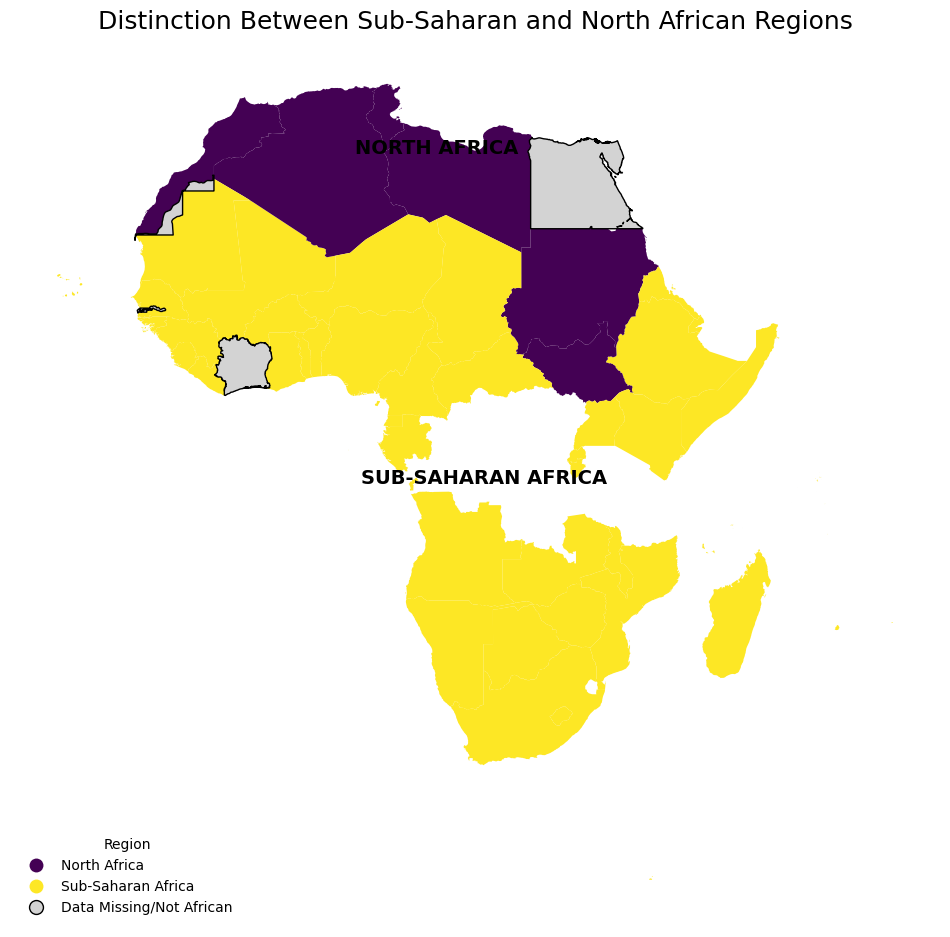

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Data and Prepare Regions 
df = pd.read_csv('africa_health_data_CLEANED_FOR_ANALYSIS.csv')

NORTH_AFRICA_COUNTRIES = [
    'Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia', 'Western Sahara', 'Sudan', 'South Sudan'
]
ALL_AFRICA_COUNTRIES = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde',
    'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Democratic Republic of Congo',
    'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia',
    'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast', 'Kenya',
    'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
    'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
    'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia',
    'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda',
    'Western Sahara', 'Zambia', 'Zimbabwe'
]

def determine_region(country):
    if country in NORTH_AFRICA_COUNTRIES:
        return 'North Africa'
    elif country in ALL_AFRICA_COUNTRIES:
        return 'Sub-Saharan Africa'
    return 'Unknown'

df['Region_Type'] = df['Country'].apply(determine_region)
df_map = df[df['Year'] == df['Year'].max()].copy()
df_map = df_map[['Country', 'Region_Type']].drop_duplicates()


# Load World Map Geometry
NATURAL_EARTH_URL = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
world = gpd.read_file(NATURAL_EARTH_URL)
africa_countries = world[world['name'].isin(ALL_AFRICA_COUNTRIES)].copy()
africa_countries_merged = africa_countries.merge(
    df_map[['Country', 'Region_Type']],
    left_on='name',
    right_on='Country',
    how='left'
)

# Plot the Map

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.set_title(
    'Distinction Between Sub-Saharan and North African Regions',
    fontdict={'fontsize': '18', 'fontweight': '5'}
)

# Plot the map
africa_countries_merged.plot(
    column='Region_Type',
    ax=ax,
    legend=True,
    categorical=True,
    legend_kwds={
        'loc': 'lower left',
        'title': 'Region',
        'frameon': False
    },
    cmap='viridis',
    missing_kwds={
        "color": "lightgrey",
        "label": "Data Missing/Not African",
        "edgecolor": "black"
    }
)

# Add Labels 

# Calculate the bounds to focus the map
africa_bbox = africa_countries.total_bounds
ax.set_xlim(africa_bbox[0] - 5, africa_bbox[2] + 5)
ax.set_ylim(africa_bbox[1] - 5, africa_bbox[3] + 5)


# Calculate the aggregate geometry for each region type
# Use dissolve() to create a single shape for all countries in a region
regional_geometry = africa_countries_merged.dropna(subset=['Region_Type']).dissolve(by='Region_Type')

# Find the centroid for each region's label placement
north_africa_geom = regional_geometry.loc['North Africa', 'geometry']
ssa_geom = regional_geometry.loc['Sub-Saharan Africa', 'geometry']

# Place the labels near the geographic center of each consolidated region
# Note: Coordinates are estimates for good visual placement
ax.text(
    x=15, y=30,  # Coordinates for North Africa
    s='NORTH AFRICA',
    fontsize=14,
    color='black',
    fontweight='bold',
    ha='center'
)

ax.text(
    x=20, y=-5,  # Coordinates for Sub-Saharan Africa 
    s='SUB-SAHARAN AFRICA',
    fontsize=14,
    color='black',
    fontweight='bold',
    ha='center'
)

ax.set_axis_off()

# Save the plot
plt.savefig('africa_regional_map_labeled.png')
print("africa_regional_map_labeled.png")

Life expectancy trends

The justification plot has been generated and saved as 'life_expectancy_justification_plot.png'.


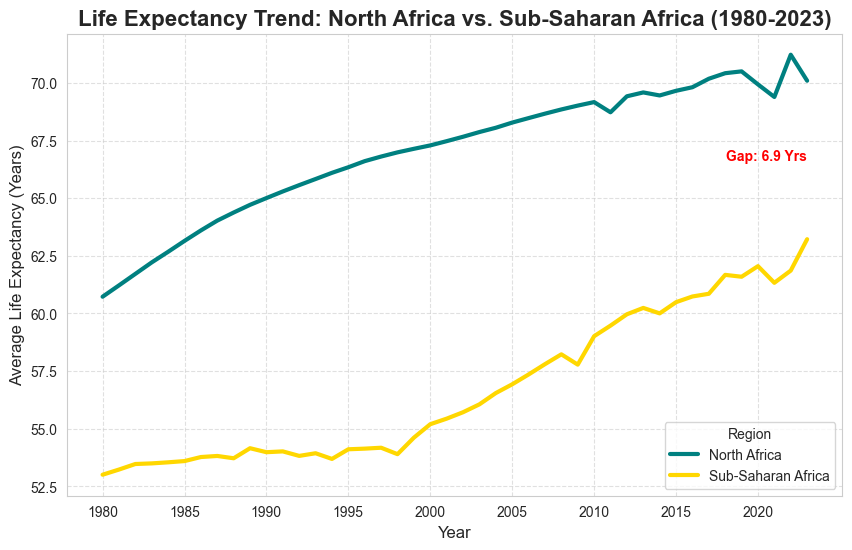

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset 
try:
    df = pd.read_csv('africa_health_data_CLEANED_FOR_ANALYSIS.csv')
except FileNotFoundError:
    print("Error: The file 'africa_health_data_CLEANED_FOR_ANALYSIS.csv' was not found.")
    print("Please ensure you have run the data cleaning steps and saved the file correctly.")
    exit()

# Defining Regions

# List of North African countries
NORTH_AFRICA_COUNTRIES = [
    'Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia', 'Western Sahara'
]

def determine_region(country):
    """Assigns countries to either North Africa or Sub-Saharan Africa."""
    if country in NORTH_AFRICA_COUNTRIES:
        return 'North Africa'
    # Assuming all other African countries in the dataset are Sub-Saharan
    elif pd.notna(country):
        return 'Sub-Saharan Africa'
    return 'Unknown'

df['Analysis_Region'] = df['Country'].apply(determine_region)

# Filter out 'Unknown' or countries outside of the two primary analysis groups
df_analysis = df[df['Analysis_Region'].isin(['North Africa', 'Sub-Saharan Africa'])].copy()

# Calculate Regional Averages over Time 

# Calculate the mean Life Expectancy for each region for each year
regional_avg = df_analysis.groupby(['Year', 'Analysis_Region'])['Life_Expectancy'].mean().reset_index()

# Ensure Life Expectancy is numeric and handle any residual NaNs by dropping them for the plot
regional_avg['Life_Expectancy'] = pd.to_numeric(regional_avg['Life_Expectancy'], errors='coerce')
regional_avg.dropna(subset=['Life_Expectancy'], inplace=True)

# Create Visualization

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

# Plot the time series using Seaborn
line_plot = sns.lineplot(
    data=regional_avg,
    x='Year',
    y='Life_Expectancy',
    hue='Analysis_Region',
    palette={'North Africa': '#008080', 'Sub-Saharan Africa': '#FFD700'}, 
    linewidth=3
)

# Customize the plot
plt.title(
    'Life Expectancy Trend: North Africa vs. Sub-Saharan Africa (1980-2023)',
    fontsize=16,
    fontweight='bold'
)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Life Expectancy (Years)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Add annotations to highlight the gap
latest_year = regional_avg['Year'].max()
na_le = regional_avg[regional_avg['Analysis_Region'] == 'North Africa']['Life_Expectancy'].iloc[-1]
ssa_le = regional_avg[regional_avg['Analysis_Region'] == 'Sub-Saharan Africa']['Life_Expectancy'].iloc[-1]

# Annotate the current gap in the latest year
plt.text(
    latest_year,
    (na_le + ssa_le) / 2,
    f'Gap: {na_le - ssa_le:.1f} Yrs',
    ha='right',
    color='red',
    fontsize=10,
    fontweight='bold'
)


plt.xticks(range(1980, 2025, 5))
plt.legend(title='Region', loc='lower right', frameon=True)

plt.savefig('life_expectancy_justification_plot.png', dpi=300, bbox_inches='tight')

print("The justification plot has been generated and saved as 'life_expectancy_justification_plot.png'.")